In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math 
import sklearn.preprocessing 
import random
import yaml
import h5py
import logging
import datetime
import os
import time

import pprint
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import torch.nn.functional as F


from load_matlab_timedata import get_data_from
from src.TSGenerator import f_Y, f_X, get_func_timeseries
from src.DataLoader import TimeSeriesDataset
from src.model_utils import init_logger, plot_shared_scale, plot_multiscale
from src.Model import LSTM
from src.Losses import myLoss, prognose_dy

from torch.optim.lr_scheduler import ReduceLROnPlateau  


## Loading config files, setup execution parameters, init objects

In [2]:
plt.rcParams['figure.figsize'] = 20, 7.
CONFIG_FILENAME = "model_params_tune.yaml"
# ! ls DC_motor_simulation
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
   
pprint.pprint(config)


p_net = config['network_params']

p_train = config['train_params']

p_gen = config['generator_params']

p_data = config['data_params']
need_normalize = p_data['need_normalize']

{'data_params': {'integration_step': 0.01,
                 'leave_nth': 13,
                 'mat_file': 'DC_motor_simulation/res.mat',
                 'need_normalize': True,
                 'test_size': 0.3,
                 'use_part_of_data': 1.0},
 'exp_path': 'only_batches',
 'generator_params': {'a': 0.5, 'b': 1.0, 'f_X': 'math.sin', 'f_Y': 'math.cos'},
 'is_debug': False,
 'network_params': {'dtype': 'torch.float',
                    'hidden_size': 16,
                    'input_size': 64,
                    'num_layers': 2,
                    'output_dim': 3,
                    'per_element': True,
                    'retrospective_steps': 128},
 'to_generate_data': False,
 'train_params': {'auto_loss': True,
                  'aux_loss': {'part_of_max_for_const': 0.3,
                               'scaling_order': 5,
                               'steady_state_threshold': 0.001},
                  'batch_size': 1024,
                  'core_loss': {'part_of_max_for_

# Set parameters

In [3]:

# # If `per_element` is True, then LSTM reads in one timestep at a time.
if  p_net['per_element']:
    lstm_input_size = 1
else:
    lstm_input_size = p_net['input_size']
    
# if is_debug:
#     x, y = get_func_timeseries(f_Y = f_Y, f_X = f_X, a=p_generate['a'], b=p_generate['b'])
to_generate_data = config['to_generate_data'] 
if to_generate_data:
    p_gen = config['generator_params']
    print("Data generator params:")
    pprint.pprint(p_gen)
    a = p_gen['a']
    b = p_gen['b']
is_debug = config['is_debug']


init_logger(config)

logging.info("Experiment started with params")
logging.info(f"data_par: {p_data}")
logging.info(f"net_par: {p_net}")
logging.info(f"train_par: {p_train}") 

logger inited to file [only_batcheslogs/exp_2019-05-04_22:32:27.log]


## Init data loader and get appropriate part of data

using 1.0 of data
X normalized, norms: [14.99712541]
x shape (76924, 1)
x_normalized shaoe (76924, 1)


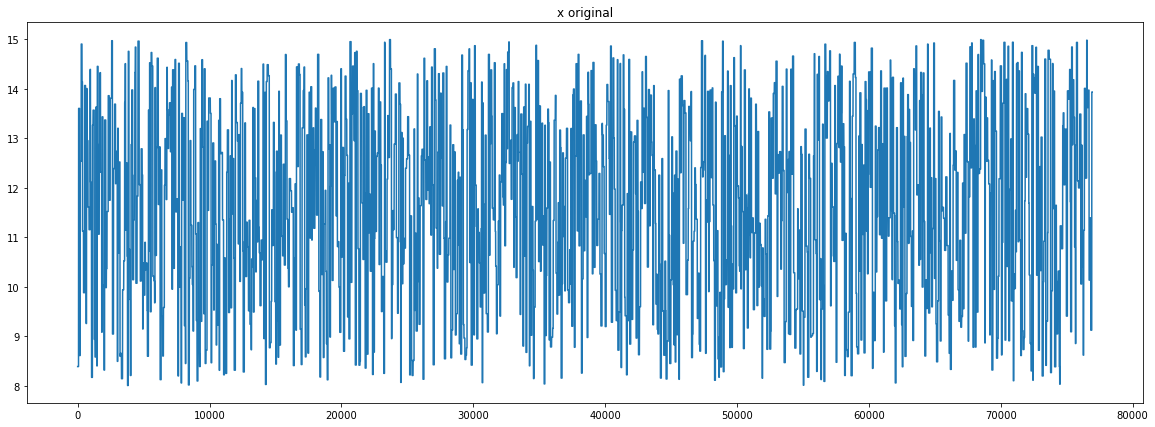

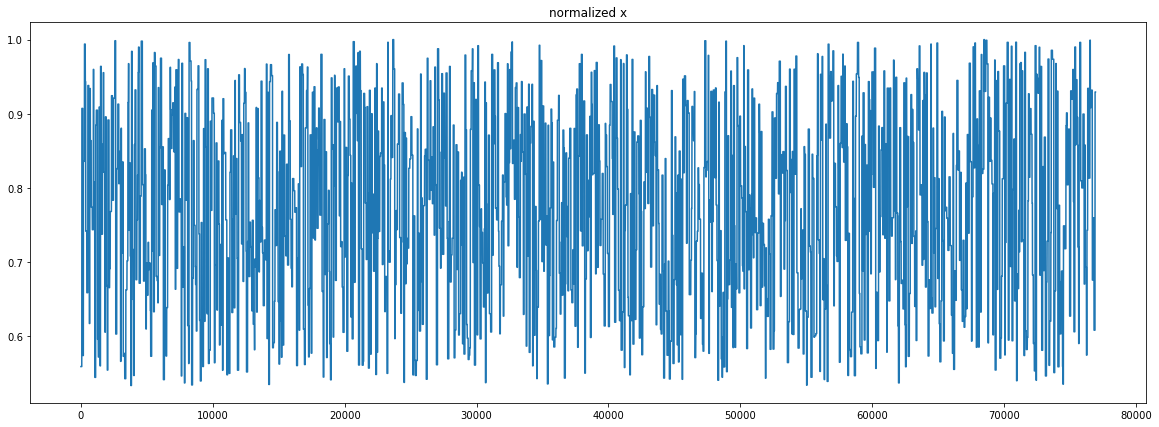

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (23078, 1)
output partition shape (23078, 1)
stacked Y shape  (22951, 1)
Y_tensor torch.Size([22951, 1])
X_tensor torch.Size([128, 22949, 1])
X normalized, norms: [14.99712541]
x shape (76924, 1)
x_normalized shaoe (76924, 1)


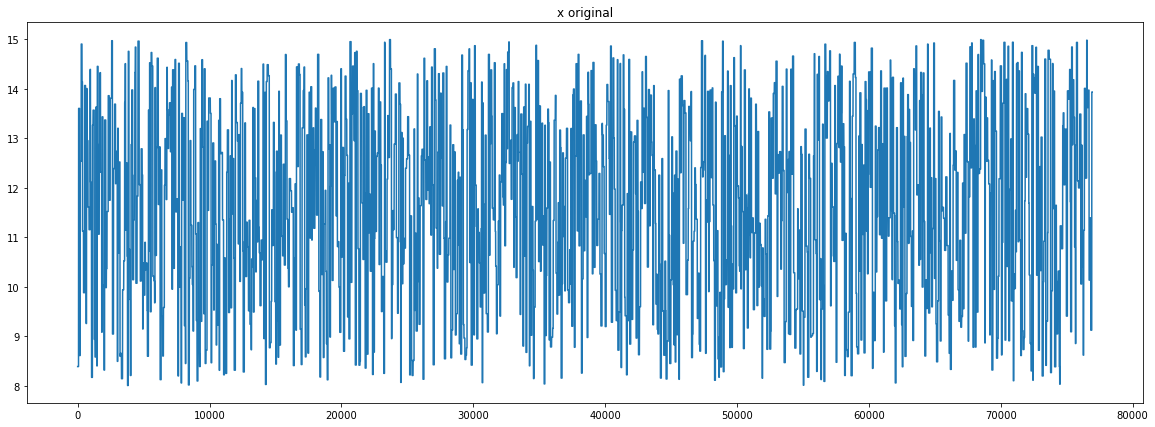

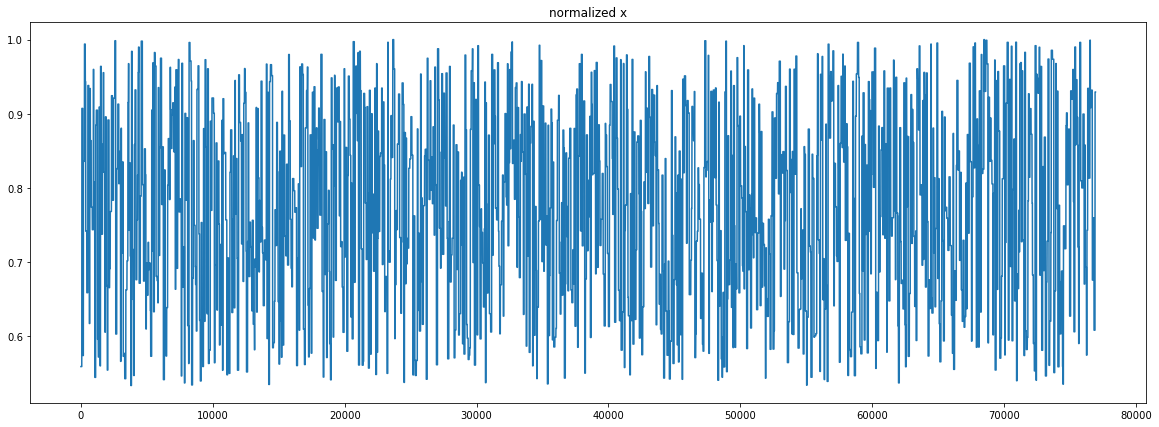

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (53846, 1)
output partition shape (53846, 1)
stacked Y shape  (53719, 1)
Y_tensor torch.Size([53719, 1])
X_tensor torch.Size([128, 53717, 1])
train set: [53719] batches
test set: [22951] batches
data_loading time 32.63958668708801 secs


In [4]:
# todo add time tracking for this cell
use_part = p_data['use_part_of_data']
print(f"using {use_part} of data")

t_tick = time.time()

test_ts_ds = TimeSeriesDataset(config=config,
                               partition=(use_part - use_part*p_data['test_size'], use_part),                        
                               logging=logging)

train_ts_ds = TimeSeriesDataset(config=config,
                                partition=(0, use_part - use_part*p_data['test_size']),
                                logging=logging)

print(f"train set: [{len(train_ts_ds)}] batches")
print(f"test set: [{len(test_ts_ds)}] batches")

if need_normalize:
    config['x_norm'] = train_ts_ds.x_norms[0]
    config['y_norm'] = train_ts_ds.y_norms[0]
    config['x_norm']
else:
    config['x_norm'] = 1
    config['y_norm'] = 1
    config['x_norm']

train_dl = DataLoader(dataset = train_ts_ds,
                      batch_sampler = BatchSampler(
                          sampler = SequentialSampler(train_ts_ds), 
                          batch_size = p_train['batch_size'],
                          drop_last = True)
                     )
test_dl = DataLoader(dataset = test_ts_ds,
                     batch_sampler = BatchSampler(
                     sampler = SequentialSampler(test_ts_ds), 
                     batch_size = p_train['batch_size'], 
                     drop_last = True)
                    )    
    
t_tock = time.time()
dataload_time = t_tock - t_tick
print(f"data_loading time {dataload_time} secs")

## Inspecting data we have, get several batches and look inside on pretty large scale to see individual iterations:

x [batch_size, retrospective_steps, channels] :torch.Size([1024, 128, 1])
y [batch_size, channels]: torch.Size([1024, 1])
y_last [slice_size]: (150,)


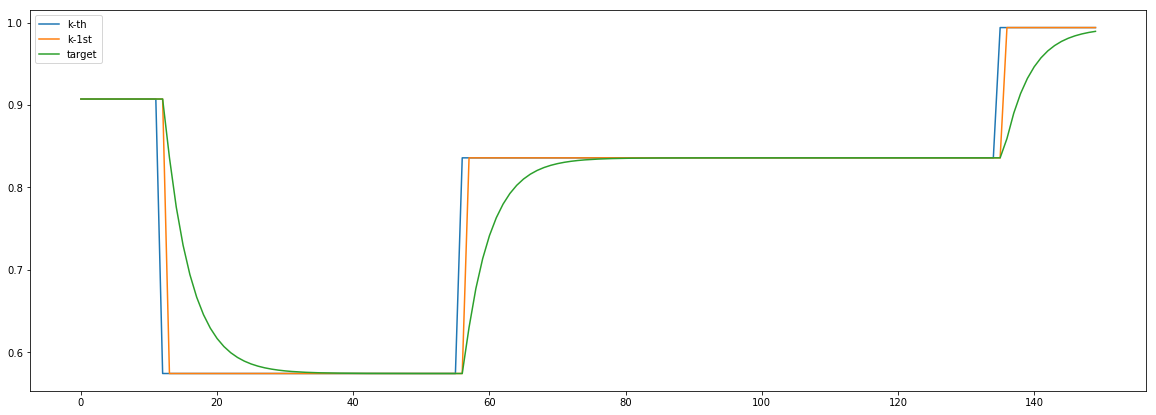

x [batch_size, retrospective_steps, channels] :torch.Size([1024, 128, 1])
y [batch_size, channels]: torch.Size([1024, 1])
y_last [slice_size]: (150,)


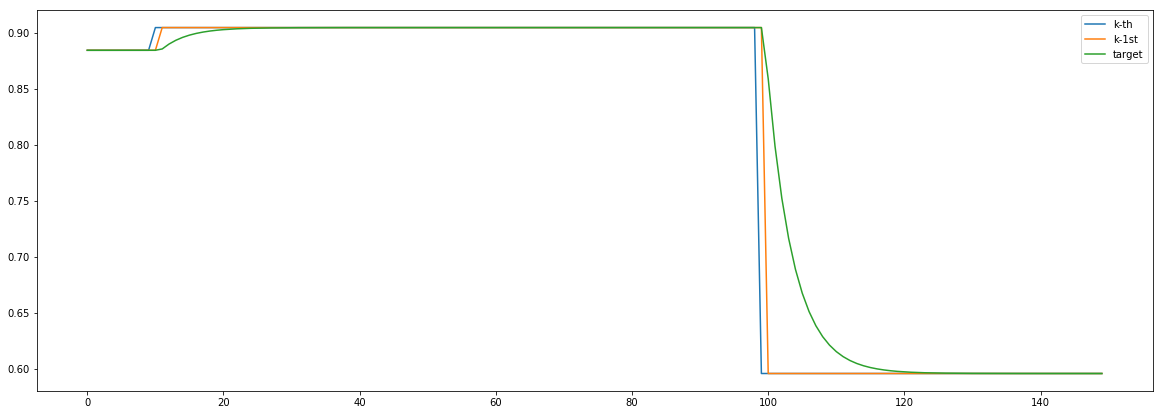

In [5]:
f, t = 0, 150
for i, batch in enumerate(train_dl):
    x, y, ind = batch
    print(f"x [batch_size, retrospective_steps, channels] :{x.shape}")
    print(f"y [batch_size, channels]: {y.shape}")
    y_kth = y.detach().numpy()[f:t, 0]
    print(f"y_last [slice_size]: {y_kth.shape}")
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-1][f:t], label='k-th')
    plt.plot(x.detach().numpy()[-2][f:t], label='k-1st')
    plt.plot(y_kth, label='target')
    plt.legend()
    plt.show()
    if i == 1:
        break

## Creating objects from imported files

In [6]:
from src.Model import LSTM
from src.Losses import myLoss, prognose_dy  # imports here for faster rerun and debug procedure

model = LSTM(lstm_input_size,
             p_net['hidden_size'],
             batch_size=p_train['batch_size'],
             output_dim=p_net['output_dim'],
             num_layers=p_net['num_layers'])

loss_fn = myLoss

# if p_train['loss_fn'] == 'mse':  
#     loss_fn = torch.nn.MSELoss(reduction=p_train['reduction'])
# elif p_train['loss_fn'] == 'l1':  
#     loss_fn = torch.nn.L1Loss(reduction=p_train['reduction'])

p_optim = p_train['optimizer']
wd = p_optim['weight_decay']
lr = p_optim['learning_rate']

if p_optim['optimizer'] == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

logging.info(f"Model n params: {model.get_num_params()}")
print(f"model has [{model.get_num_params()}] params")
num_epochs = p_train['num_epochs']
logging.info("Training process INITIALIZED")
optimizer

model has [3443.0] params


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [7]:
for name, parameter in model.named_parameters():
    print(name, '\t\t', parameter.shape)

lstm.weight_ih_l0 		 torch.Size([64, 1])
lstm.weight_hh_l0 		 torch.Size([64, 16])
lstm.bias_ih_l0 		 torch.Size([64])
lstm.bias_hh_l0 		 torch.Size([64])
lstm.weight_ih_l1 		 torch.Size([64, 16])
lstm.weight_hh_l1 		 torch.Size([64, 16])
lstm.bias_ih_l1 		 torch.Size([64])
lstm.bias_hh_l1 		 torch.Size([64])
linear.weight 		 torch.Size([3, 16])
linear.bias 		 torch.Size([3])


In [8]:
# #####################
# # 
# #####################
# from torch.nn import init
# for layer_p in a._all_weights:
#     for p in layer_p:
#         if 'weight' in p:
#             # print(p, a.__getattr__(p))
#             init.normal(a.__getattr__(p), 0.0, 0.02)

In [9]:
logging.info("History INITIALIZED")

hist = {
    "train":{
        "batches":{
            "main":np.zeros(len(train_dl)),
            "aux":np.zeros(len(train_dl)),
            "const":np.zeros(len(train_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "const":np.zeros(num_epochs)
        }
    },
    "eval_train":{
        "batches":{
            "main":np.zeros(len(train_dl)),
            "aux":np.zeros(len(train_dl)),
            "const":np.zeros(len(train_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "const":np.zeros(num_epochs)
        }
    },
    "eval_test":{
        "batches":{
            "main":np.zeros(len(test_dl)),
            "aux":np.zeros(len(test_dl)),
            "const":np.zeros(len(test_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "const":np.zeros(num_epochs)
        }
    },
    'mean_params_sample':
    {
        '1':np.zeros(num_epochs),
        '2':np.zeros(num_epochs),            
    },
    'lr': np.zeros(num_epochs),
    'loss_rate': np.zeros(num_epochs),
    'weights_sum': np.zeros(num_epochs), 
    'weights_var': np.zeros(num_epochs)
}

In [20]:
def batch_iteration(iter_index, model, optimizer, batch_data, backprop, hist_part):
    
    x_batch, y_batch, indexes = data
    x_batch.transpose_(0, 1) # todo get rid of it
    model.hidden = model.init_hidden()

    y_pred = model(x_batch)
    losses = loss_fn(y_pred, y_batch, x_batch, config)
    main_loss, aux_loss, const_loss = losses
    main_loss -= main_loss
    aux_loss *= 1000
    param_decay =  (y_pred[:, 1].mean() +  y_pred[:, 2].mean()) * (aux_loss / 10)
    losses = [main_loss * 0, aux_loss, const_loss, param_decay]
#         print(f"losses before scaling: m[{main_loss.item()}] a[{aux_loss.item()}] c[{const_loss.item()}]")
    
    
    if backprop:
        max_loss = max(losses)
        combined_loss = sum(losses)

        optimizer.zero_grad()

        combined_loss.backward()
    # TODO or manually add weight decay here when grad is ready
    #         print(f"losses after scaling: m[{main_loss.item()}] a[{aux_loss.item()}] c[{const_loss.item()}]")

        optimizer.step()
    
    hist_part["main"][iter_index] = main_loss.item()
    hist_part["aux"][iter_index] = aux_loss.item()
    hist_part["const"][iter_index] = const_loss.item()
    
    return y_pred

In [21]:
def update_long_term_hist(batches_hist, long_term_hist):
    mean_main = np.average(batches_hist["main"])
    mean_aux = np.average(batches_hist["aux"])
    mean_const = np.average(batches_hist["const"])
    long_term_hist["main"][t] = mean_main
    long_term_hist["aux"][t] = mean_aux
    long_term_hist["const"][t] = mean_const
    return mean_main, mean_aux, mean_const

In [22]:
def slice_loss_sum(losses_dict, index):
    return sum([val[index] for val in losses_dict.values()])

In [23]:
p_sched = p_train['lr_scheduler']
scheduler = ReduceLROnPlateau(optimizer=optimizer,
                              mode='min',
                              patience=p_sched['patience'],
                              cooldown=p_sched['cooldown'],
                              threshold=p_sched['threshold'],
                              threshold_mode='rel',
                            factor=p_sched['lr_drop'],
                             min_lr=10**p_sched['early_stop_order'],
                             verbose=True)
print("LR scheduler set_uped")
scheduler.state_dict()

LR scheduler set_uped


{'factor': 0.3,
 'min_lrs': [1e-07],
 'patience': 2,
 'verbose': True,
 'cooldown': 3,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 0.01,
 'threshold_mode': 'rel',
 'best': inf,
 'num_bad_epochs': 0,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': -1}

## Train model


aux preds: 0.14432364702224731 0.21049803495407104
main loss 0.0
aux loss 1016253.3365384615
const loss 0.004204357087683792
combined loss 1016253.3407428185 


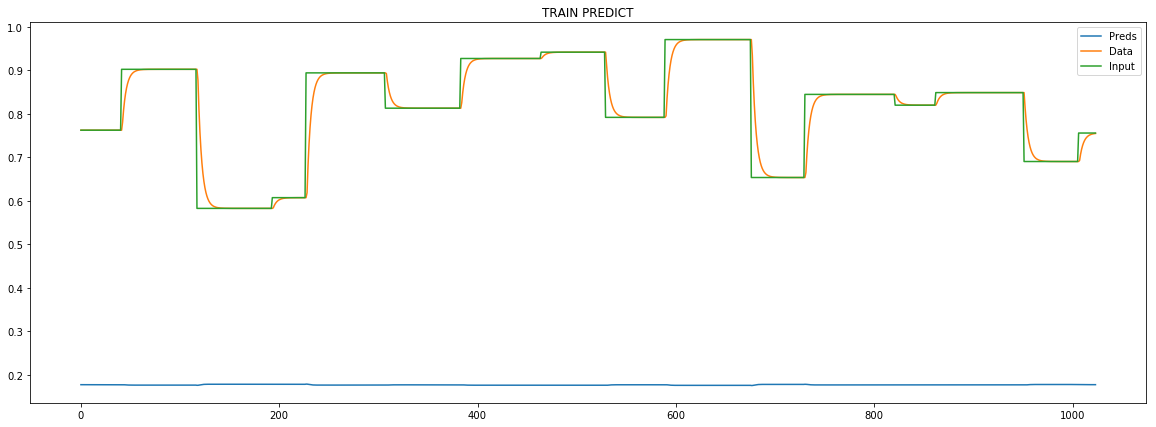

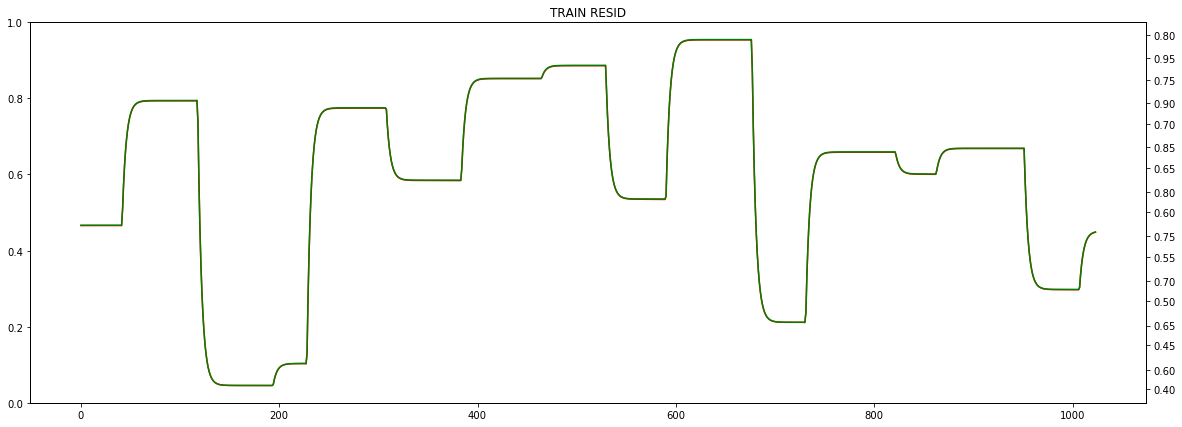

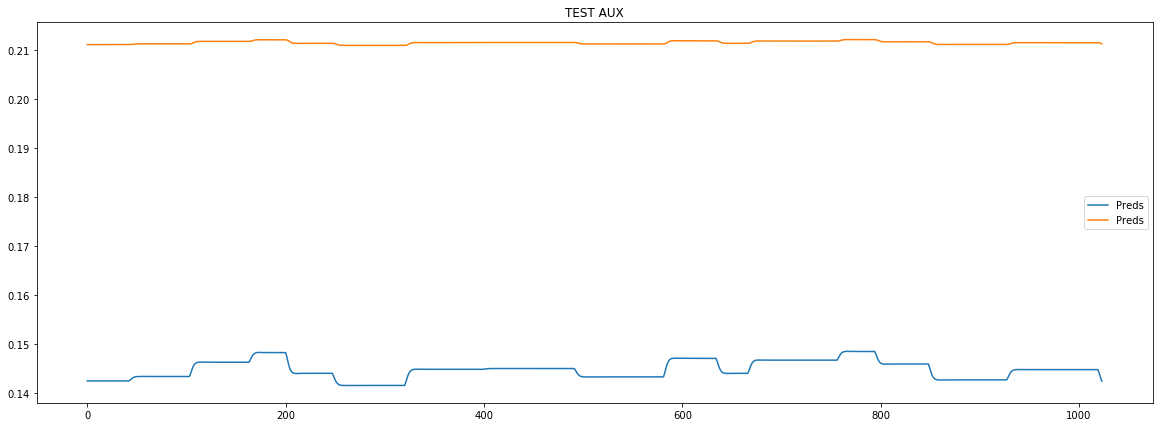

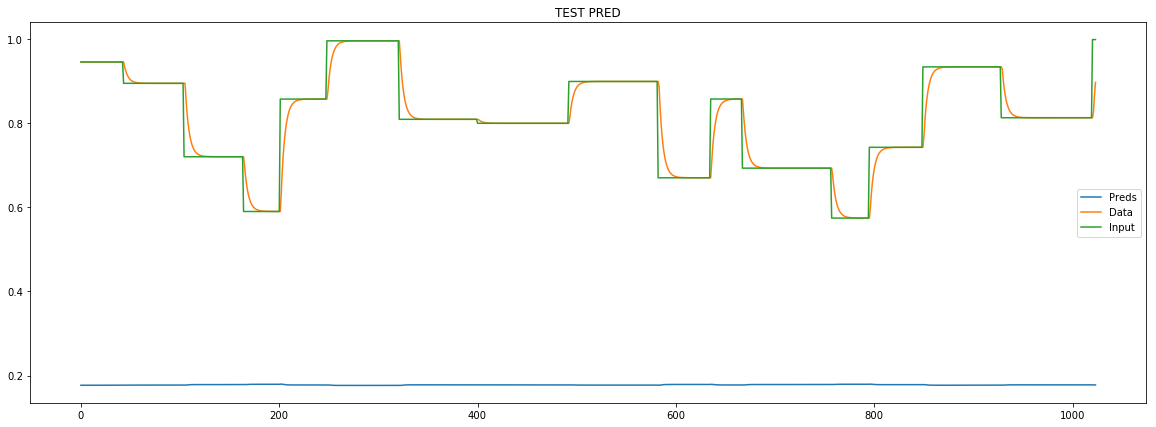

Epoch [0] 
     train_loss[1016253.3407428185] 
     eval_train[892775.223120473] 
     eval_test[916008.7152241399]



aux preds: 0.15873625874519348 0.27212831377983093
main loss 0.0
aux loss 791633.0757211539
const loss 0.004611884176623649
combined loss 791633.080333038 


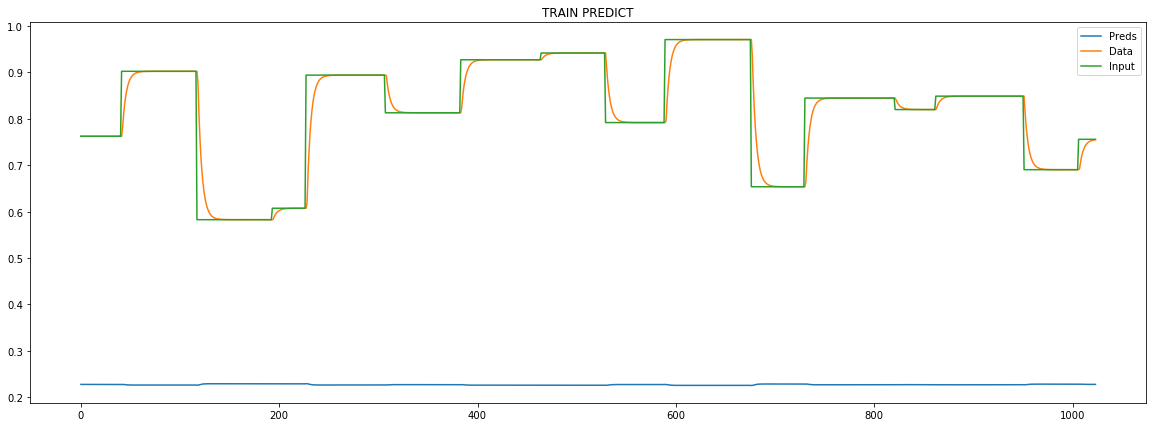

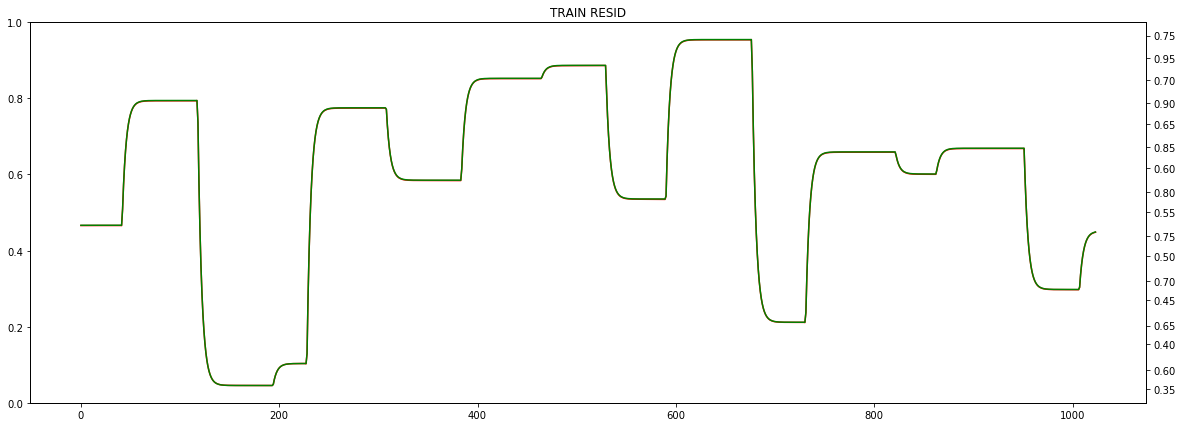

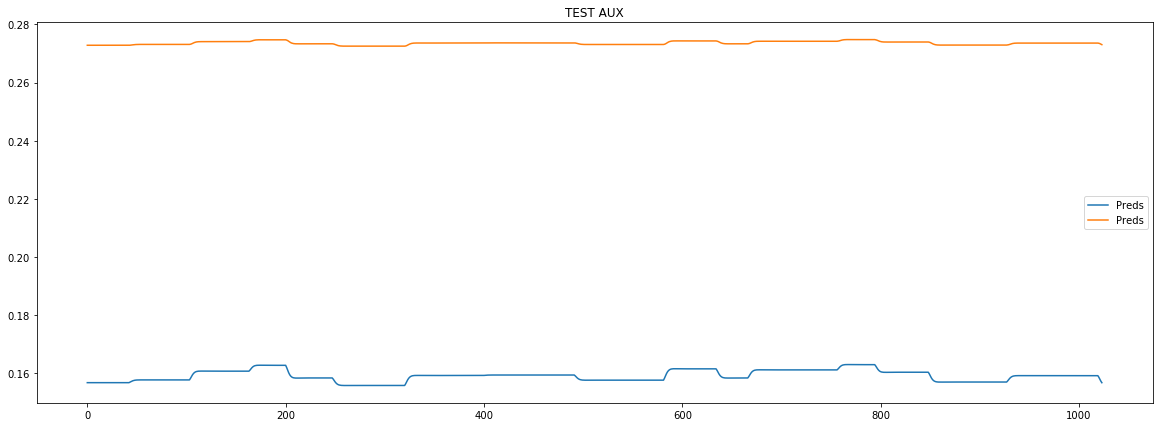

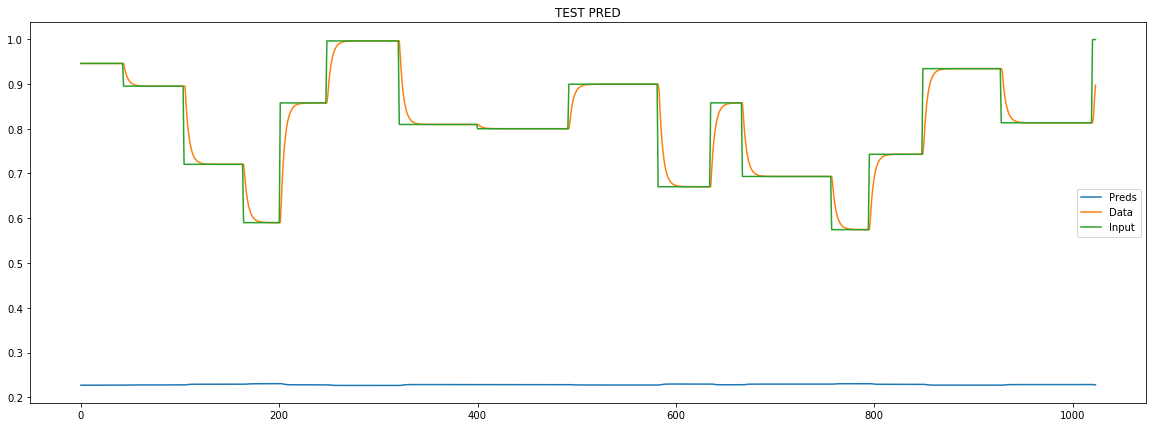

Epoch [1] 
     train_loss[791633.080333038] 
     eval_train[690360.1269566043] 
     eval_test[708759.5369280201]



aux preds: 0.17330148816108704 0.35598224401474
main loss 0.0
aux loss 602349.3551682692
const loss 0.0054548281388214
combined loss 602349.3606230974 


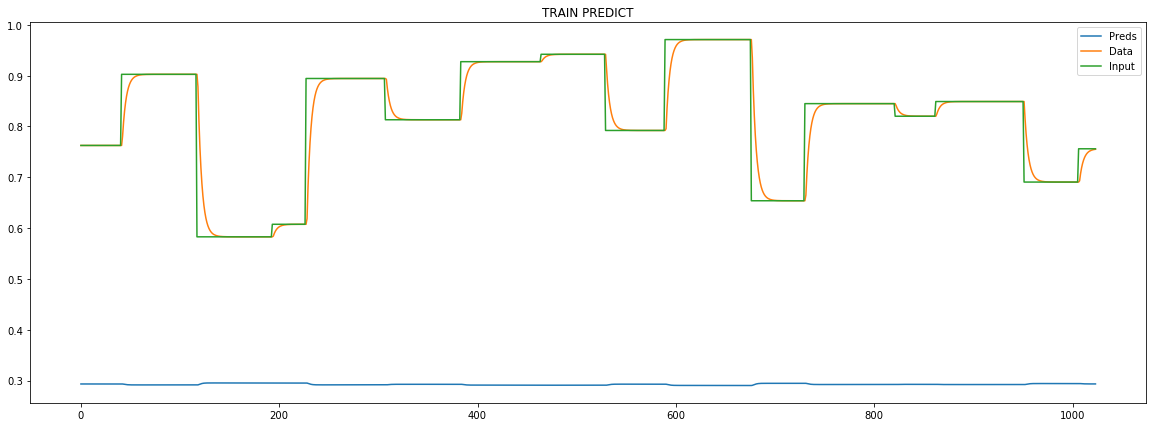

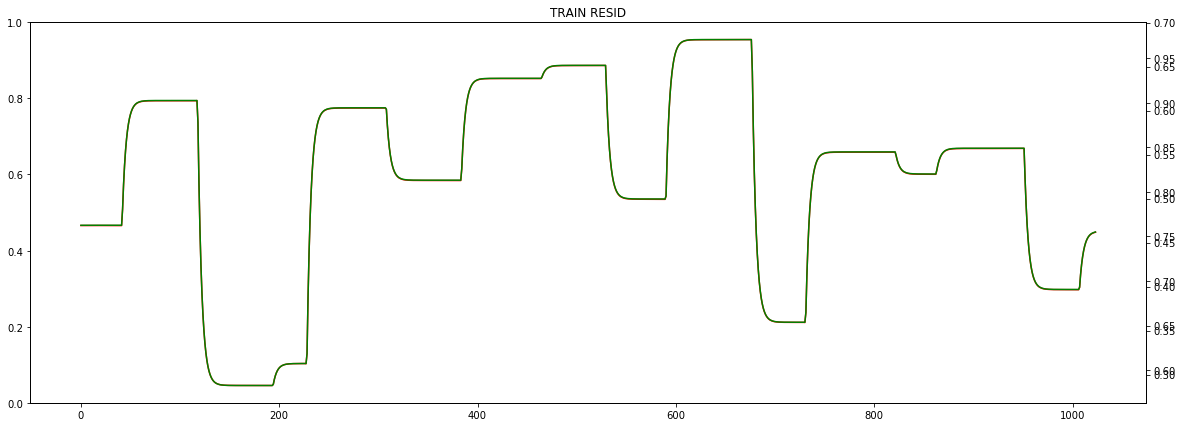

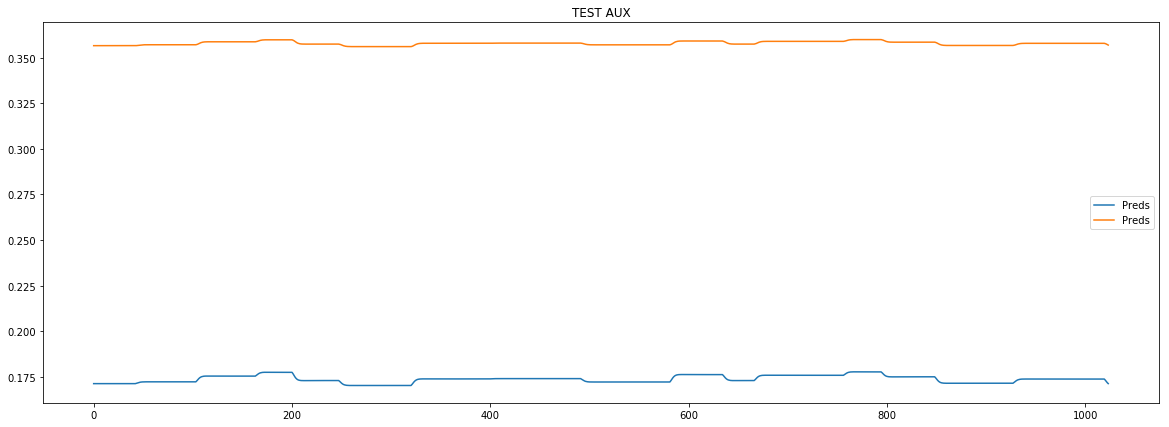

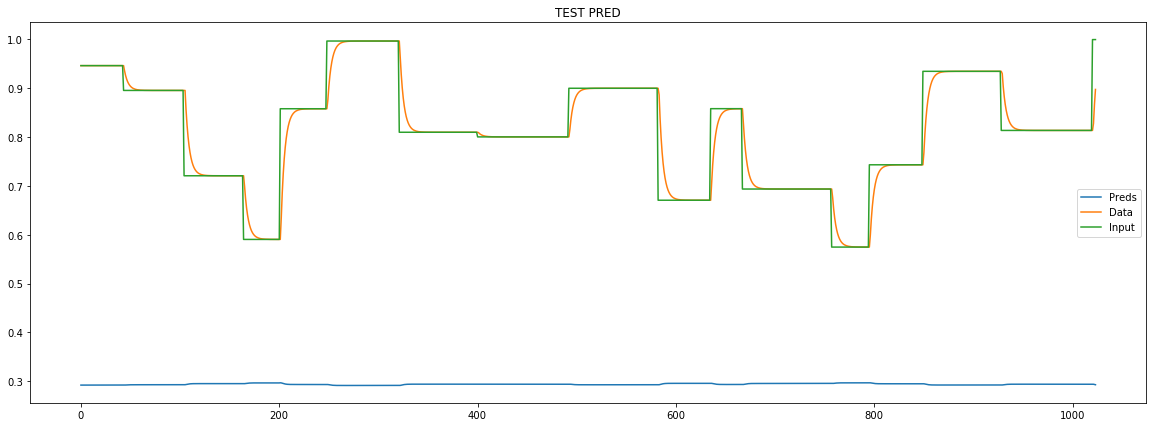

Epoch [2] 
     train_loss[602349.3606230974] 
     eval_train[513503.91301722557] 
     eval_test[527853.5638813383]



aux preds: 0.18749675154685974 0.4622996151447296
main loss 0.0
aux loss 434774.28395432694
const loss 0.0071504145744256675
combined loss 434774.2911047415 


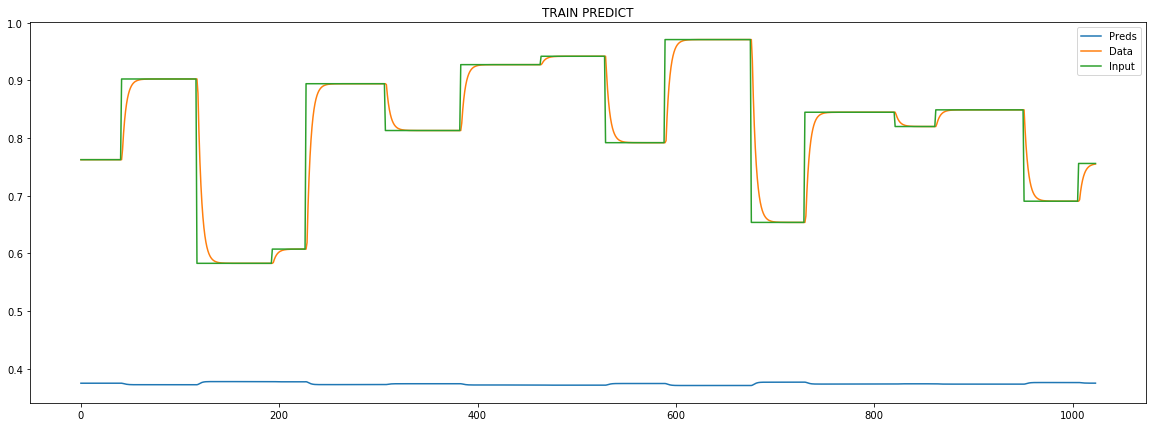

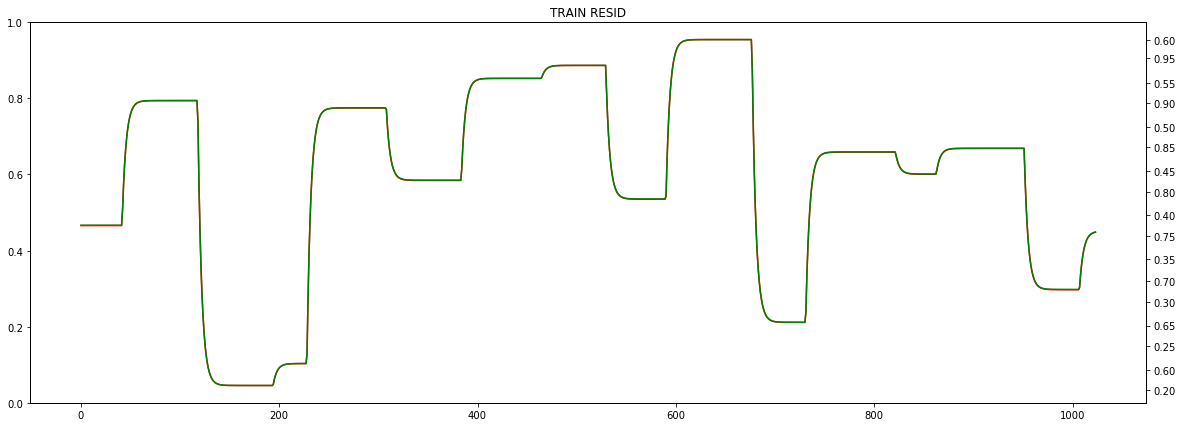

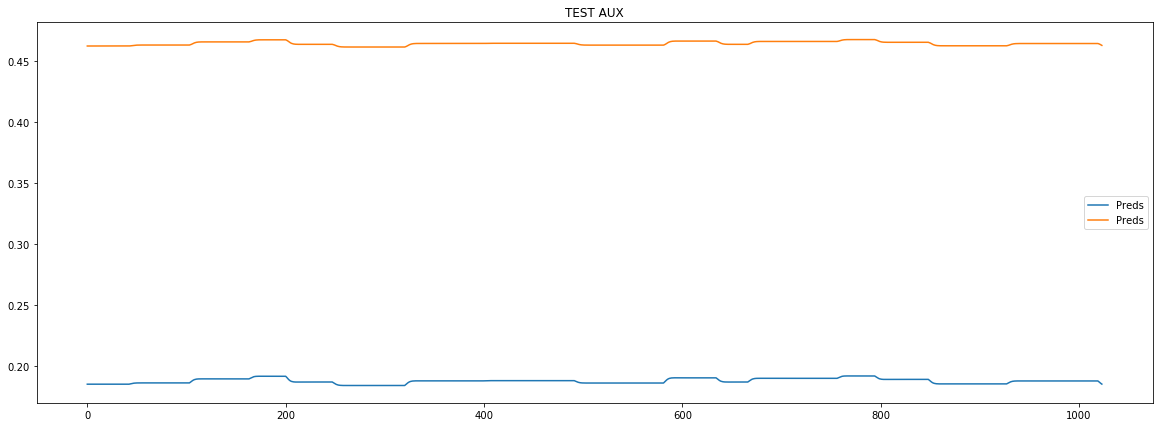

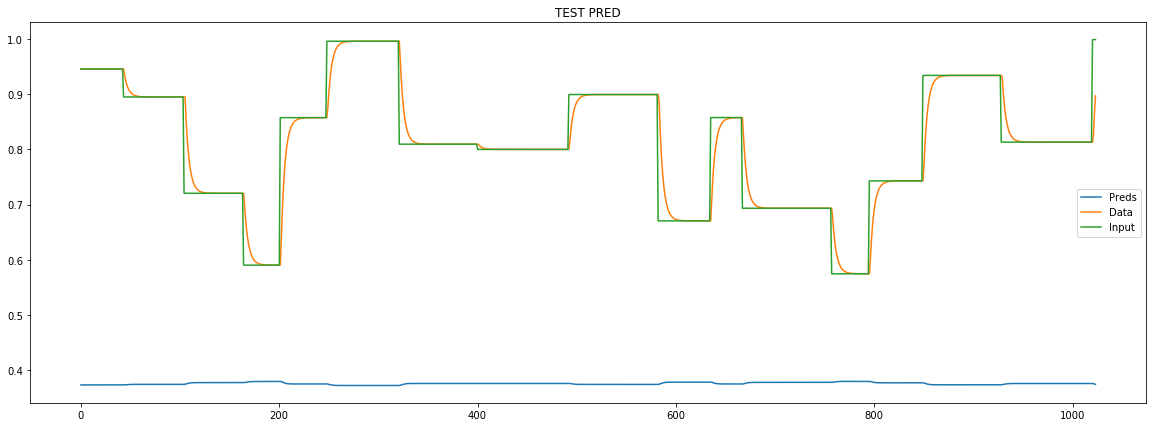

Epoch [3] 
     train_loss[434774.2911047415] 
     eval_train[354887.82645589265] 
     eval_test[365737.42457054387]



aux preds: 0.20086033642292023 0.5875873565673828
main loss 0.0
aux loss 284640.6544471154
const loss 0.010403547561369263
combined loss 284640.6648506629 


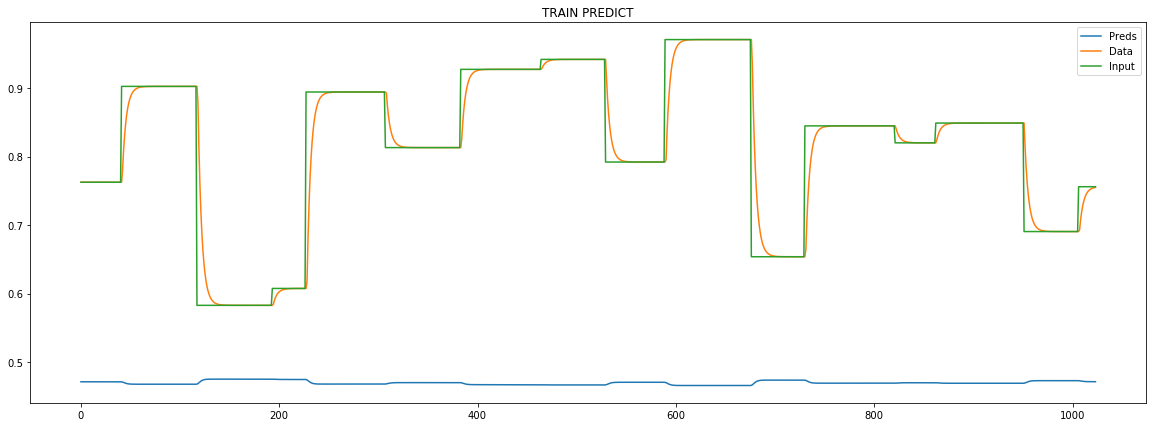

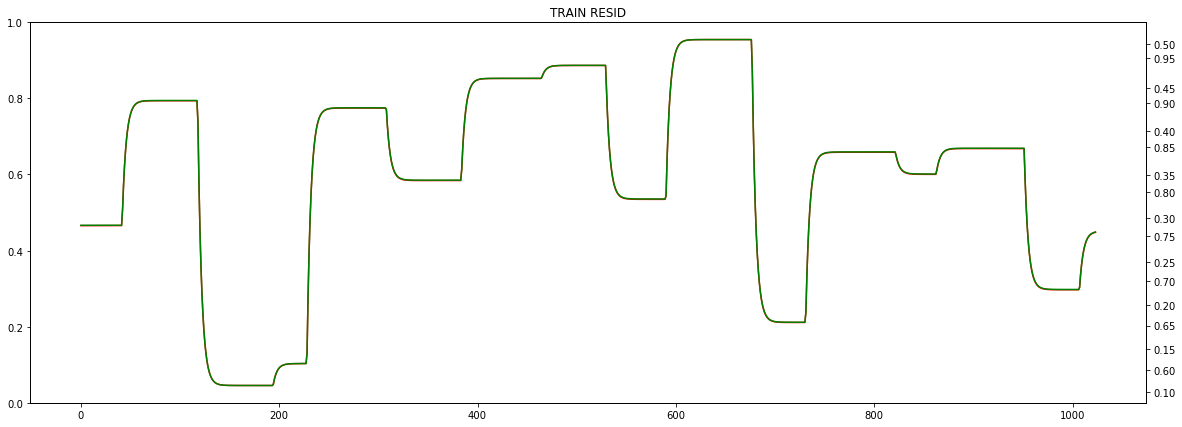

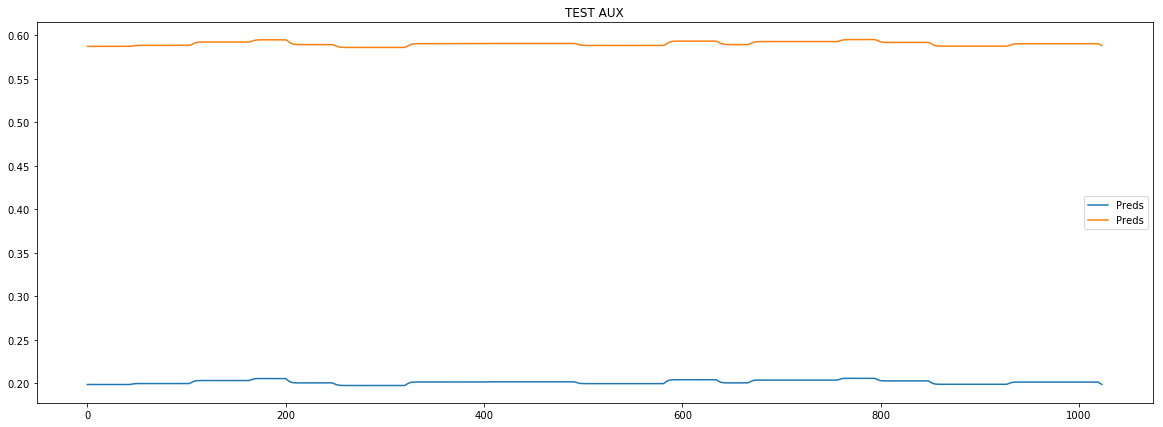

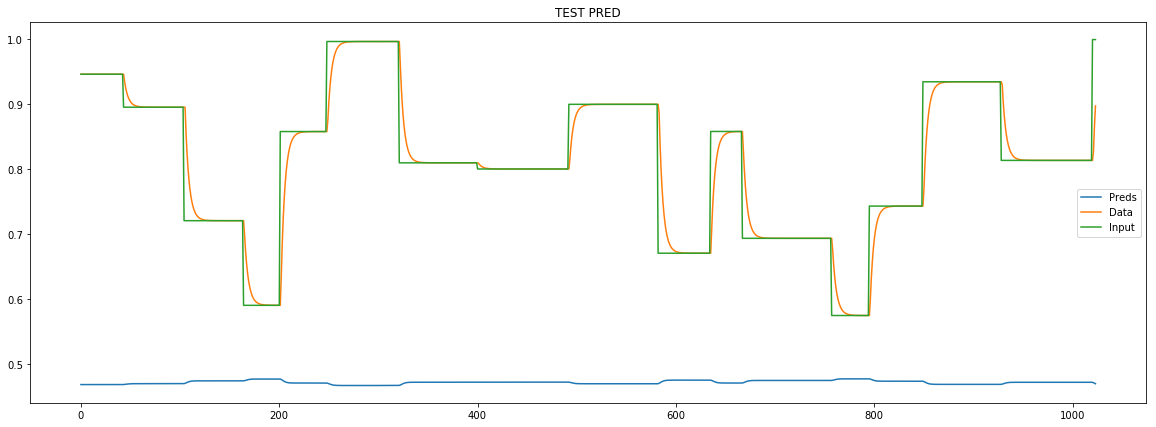

loss rate [0.5836215204468164]
Epoch [4] 
     train_loss[284640.6648506629] 
     eval_train[214636.4928416107] 
     eval_test[222394.75848964293]



aux preds: 0.21281448006629944 0.7218071818351746
main loss 0.0
aux loss 157491.15760216347
const loss 0.016192693442392807
combined loss 157491.1737948569 


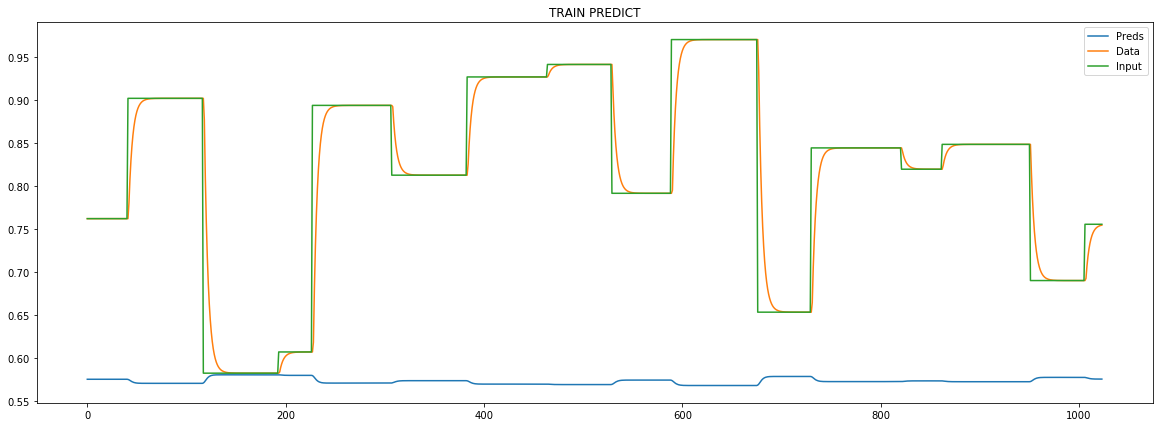

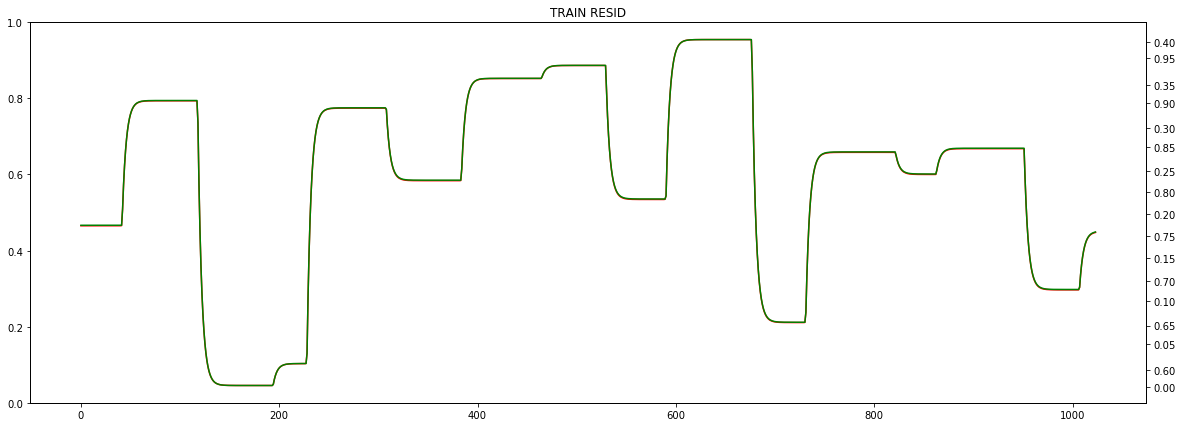

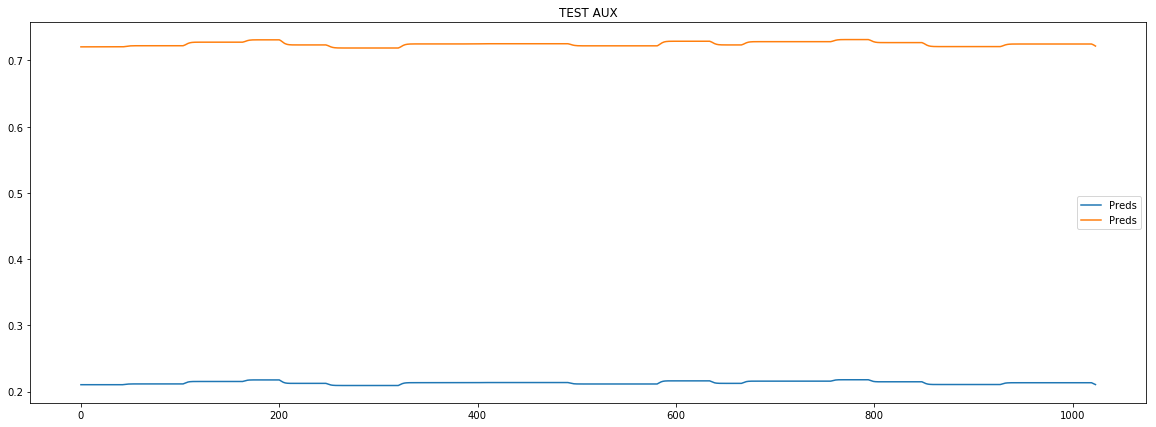

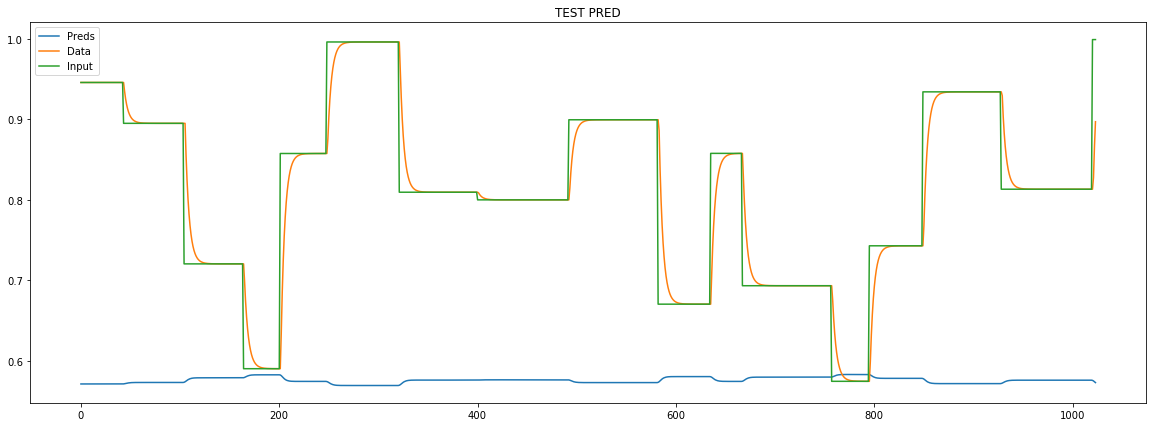

loss rate [0.7070562297122726]
Epoch [5] 
     train_loss[157491.1737948569] 
     eval_train[103855.95497611436] 
     eval_test[108973.69076547204]



aux preds: 0.22252824902534485 0.845370352268219
main loss 0.0
aux loss 67480.52760667067
const loss 0.025311481315069474
combined loss 67480.55291815198 


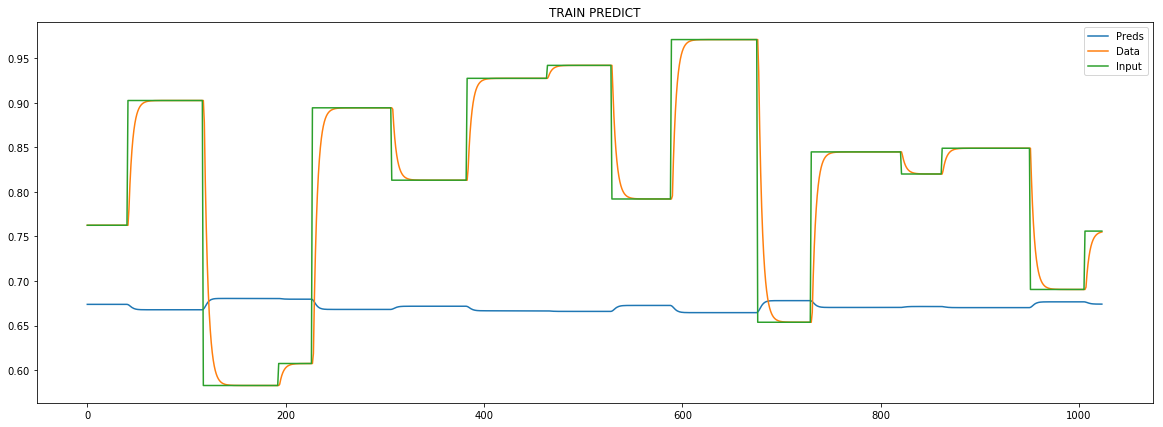

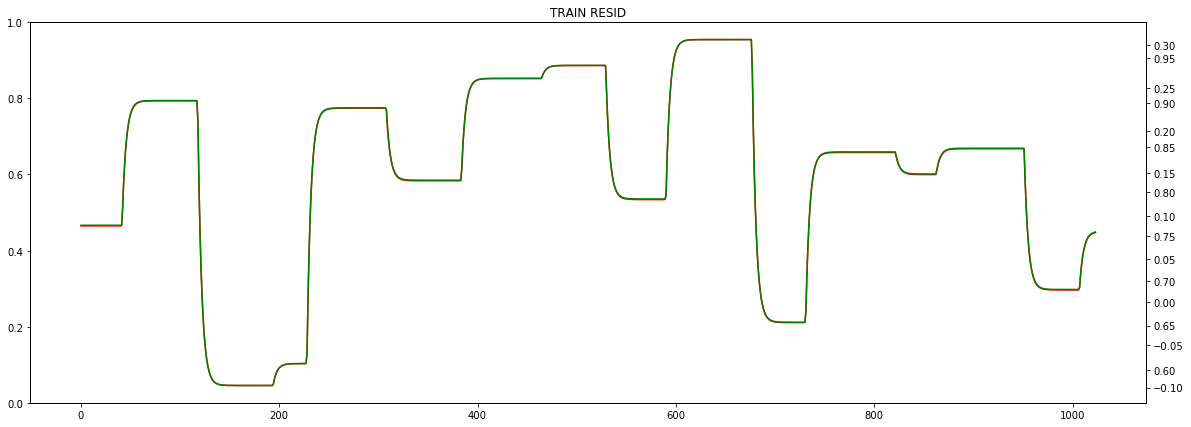

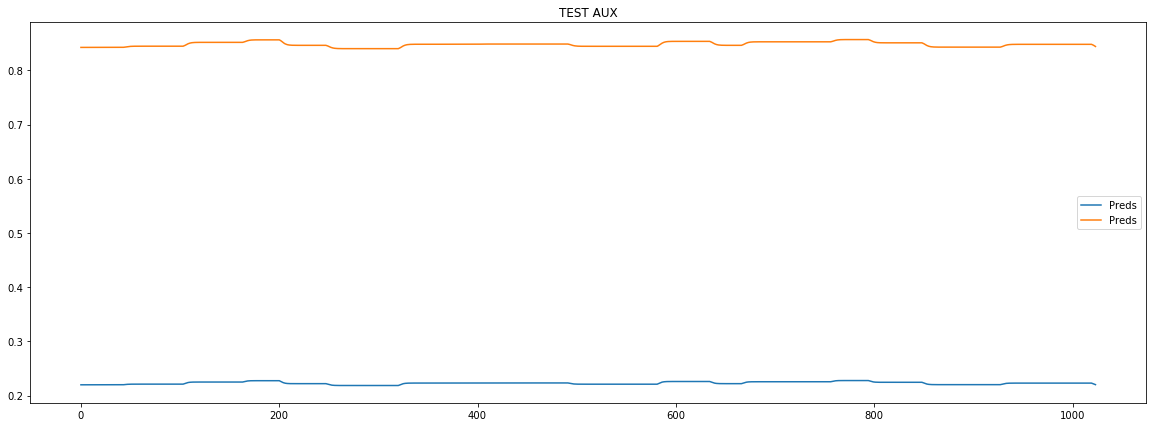

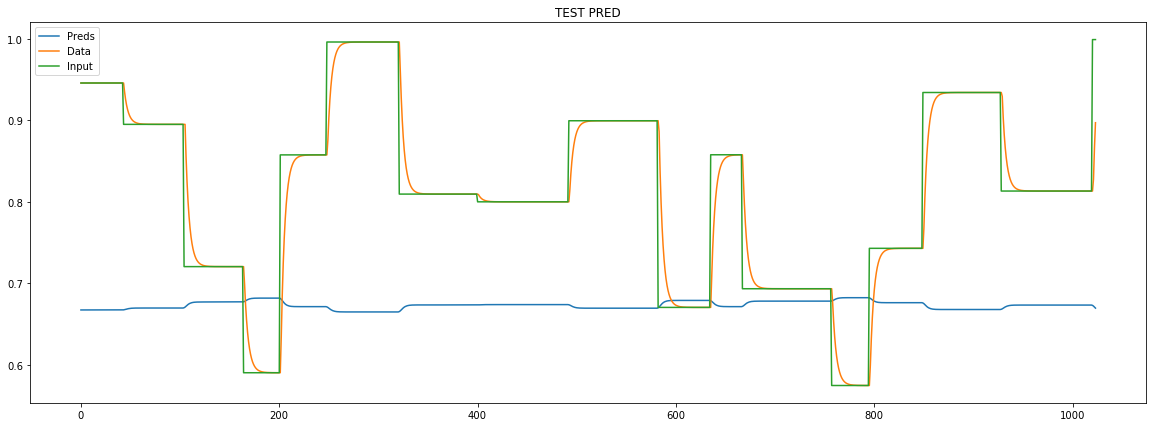

loss rate [0.8254835001979403]
Epoch [6] 
     train_loss[67480.55291815198] 
     eval_train[37421.88195489279] 
     eval_test[40552.159030503426]



aux preds: 0.22900746762752533 0.9318050146102905
main loss 0.0
aux loss 23296.414128230168
const loss 0.0365706690085622
combined loss 23296.450698899178 


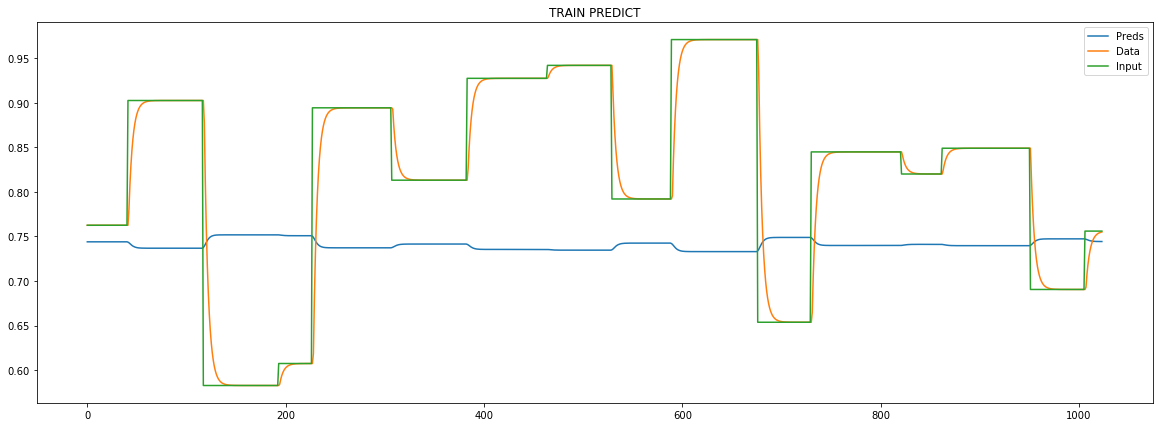

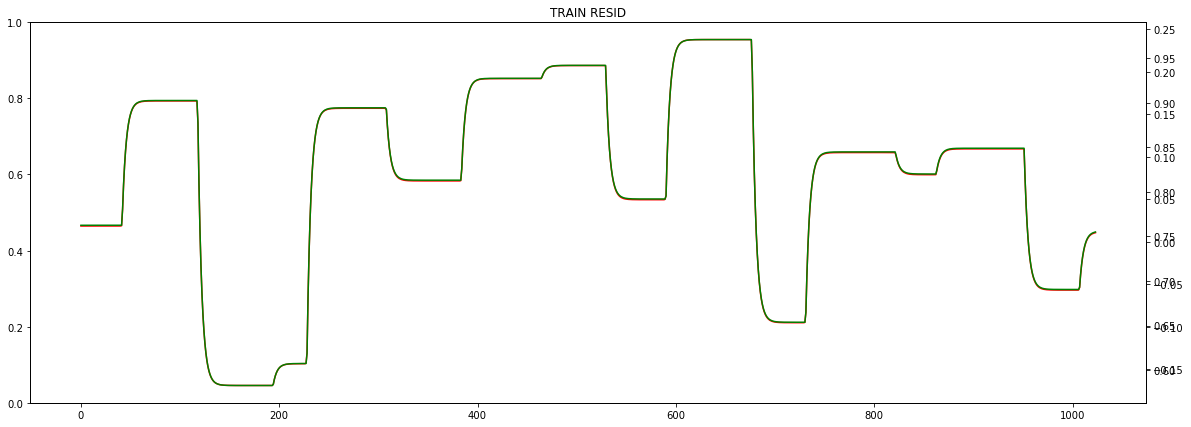

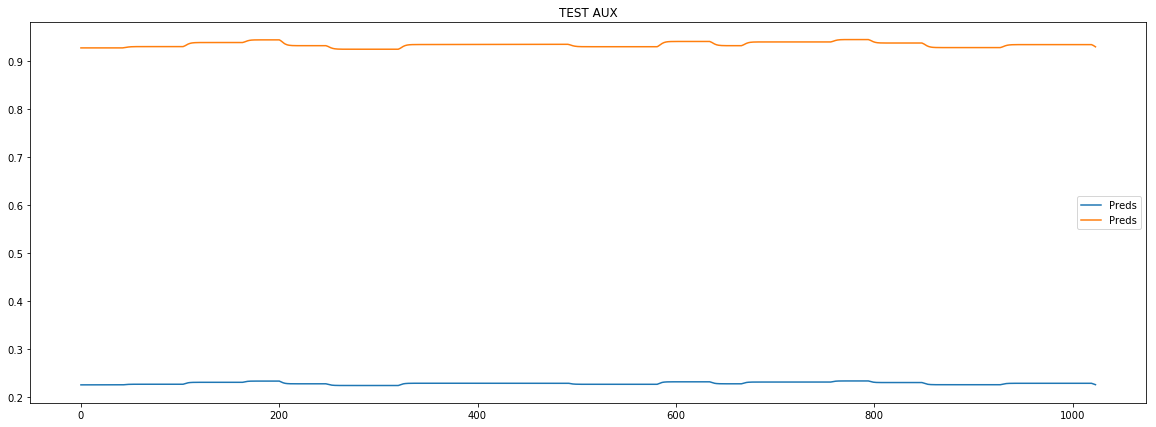

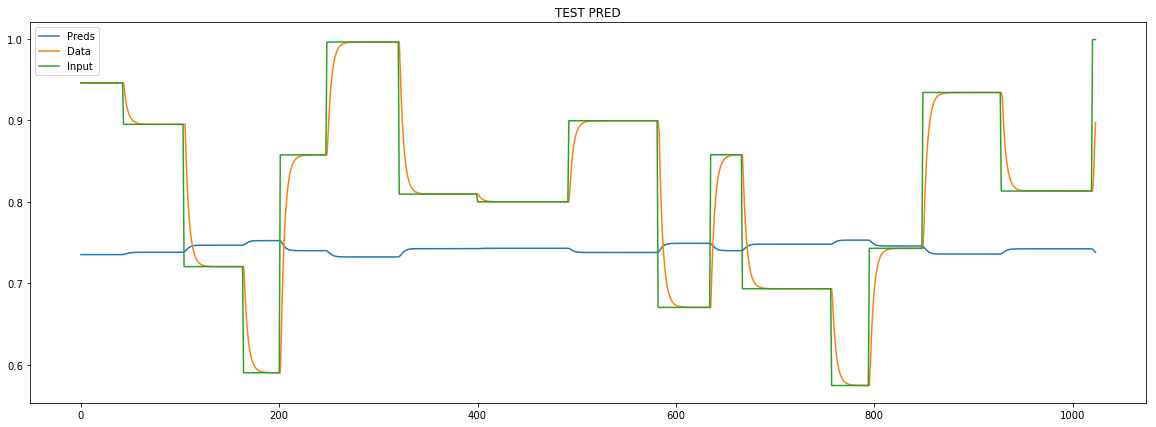

loss rate [0.8717881833797686]
Epoch [7] 
     train_loss[23296.450698899178] 
     eval_train[13923.976216465593] 
     eval_test[15894.87227560021]



aux preds: 0.23217160999774933 0.9700471758842468
main loss 0.0
aux loss 11522.039259690504
const loss 0.04527645884081721
combined loss 11522.084536149345 


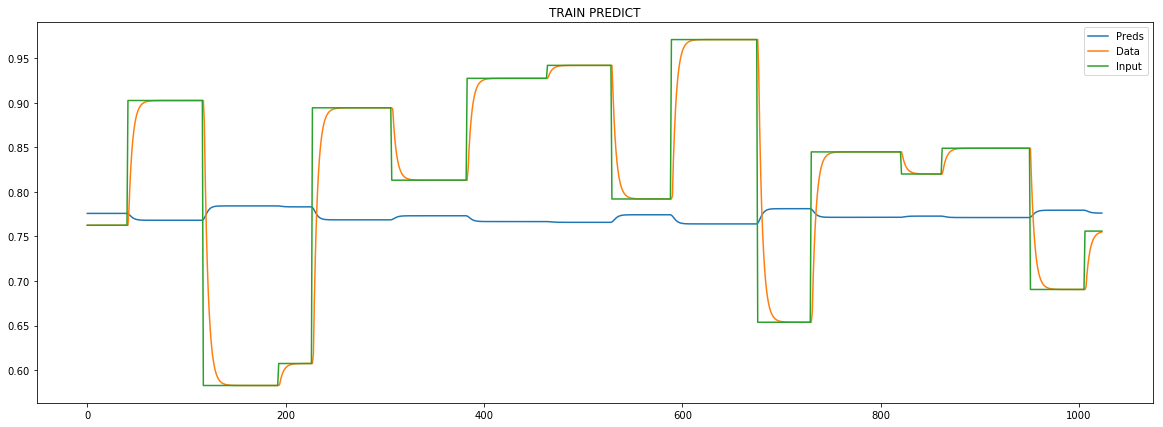

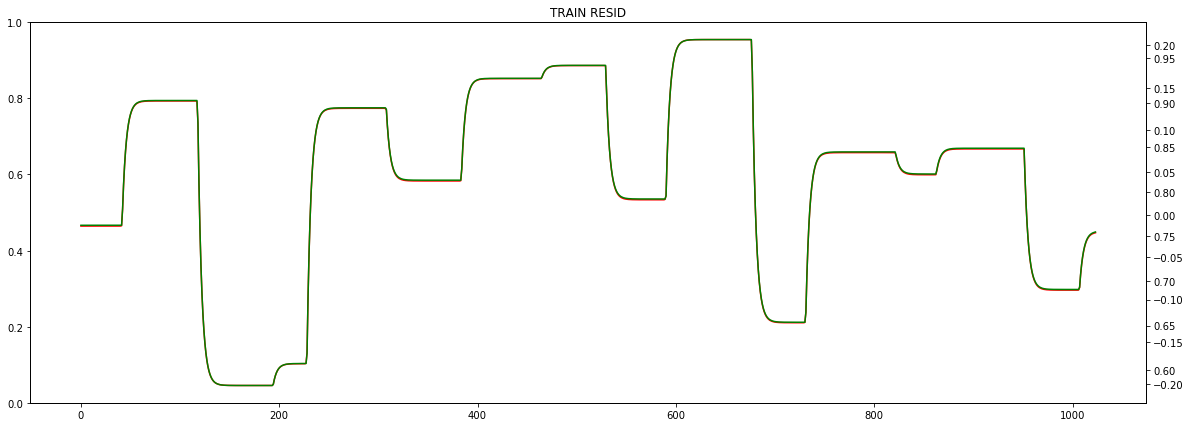

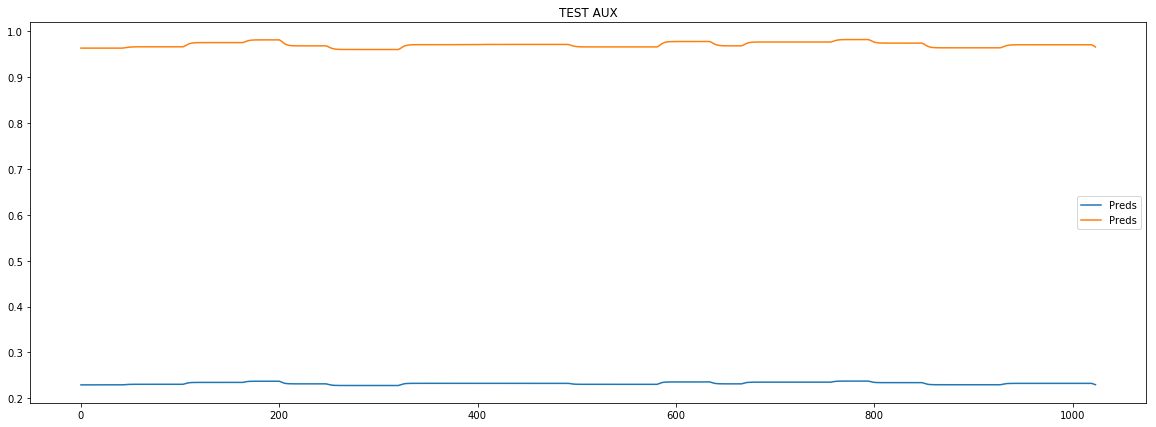

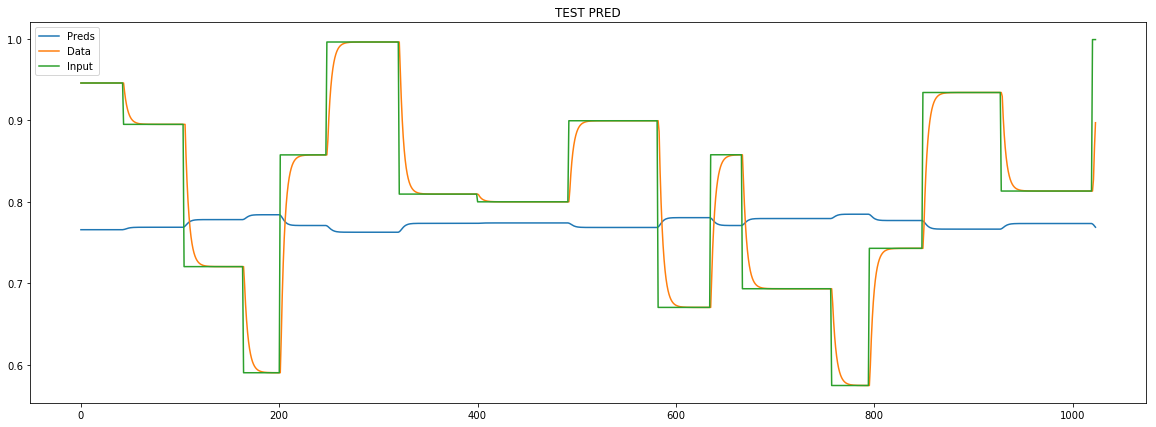

loss rate [0.7865871690103021]
Epoch [8] 
     train_loss[11522.084536149345] 
     eval_train[10252.747261125309] 
     eval_test[11767.634867218323]



aux preds: 0.23350922763347626 0.979593813419342
main loss 0.0
aux loss 10087.618239182691
const loss 0.04858828461370789
combined loss 10087.666827467305 


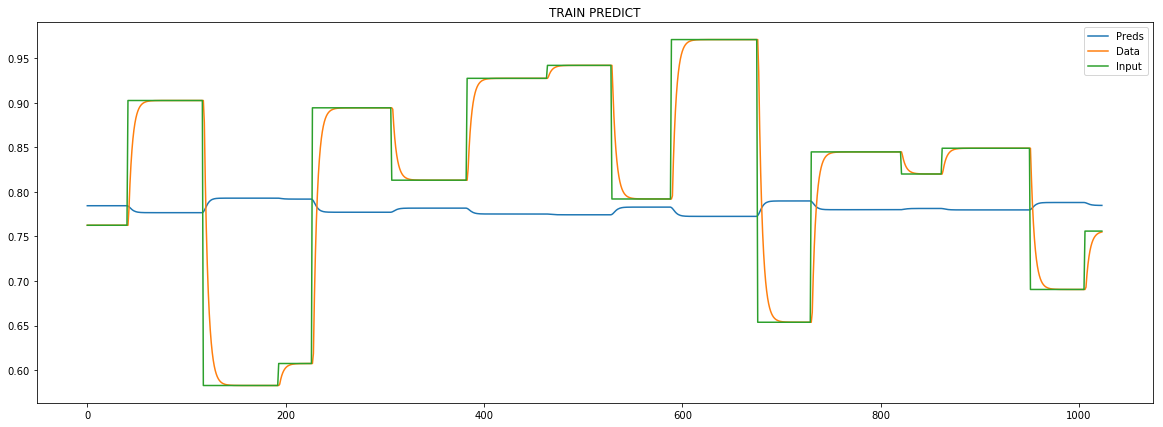

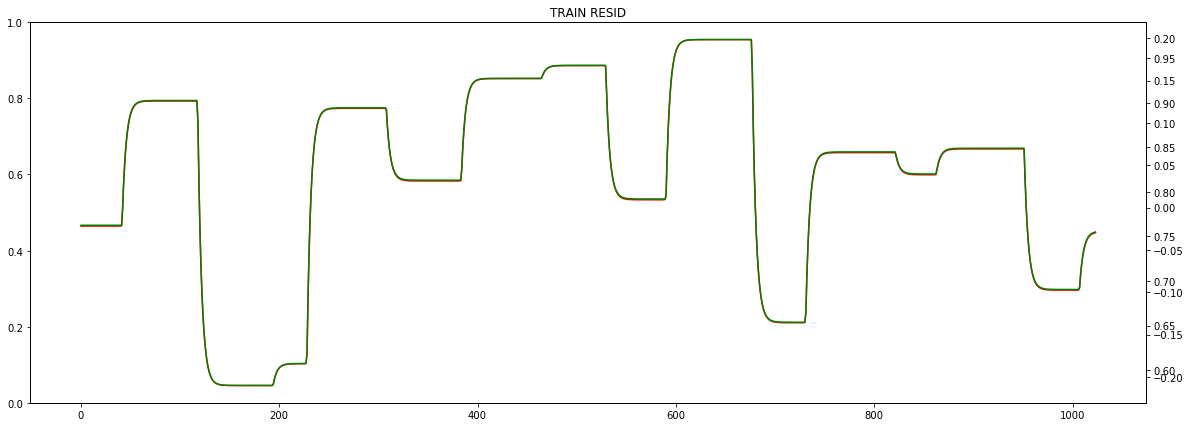

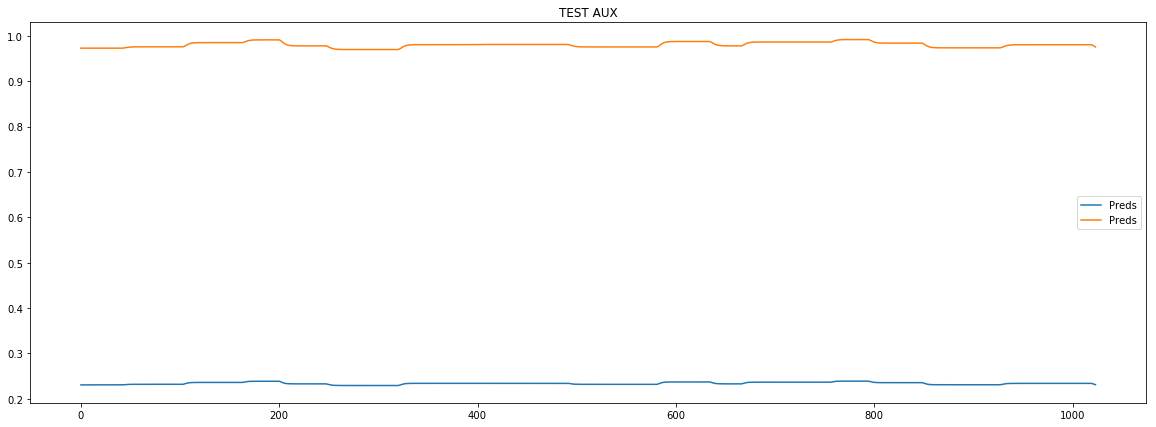

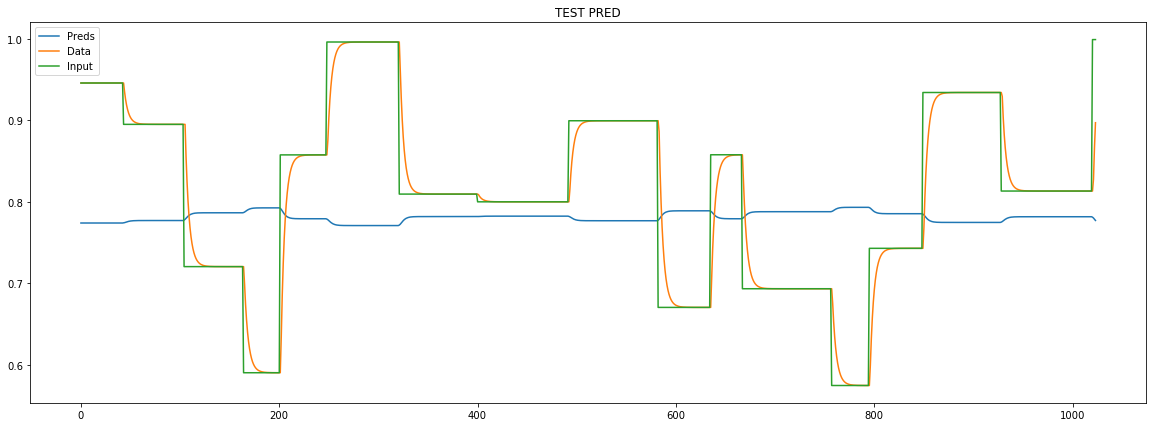

loss rate [0.5000662924703471]
Epoch [9] 
     train_loss[10087.666827467305] 
     eval_train[9970.507759581105] 
     eval_test[11367.603655975481]



aux preds: 0.2343481332063675 0.9807236194610596
main loss 0.0
aux loss 9939.673743614783
const loss 0.048864673608197615
combined loss 9939.722608288392 


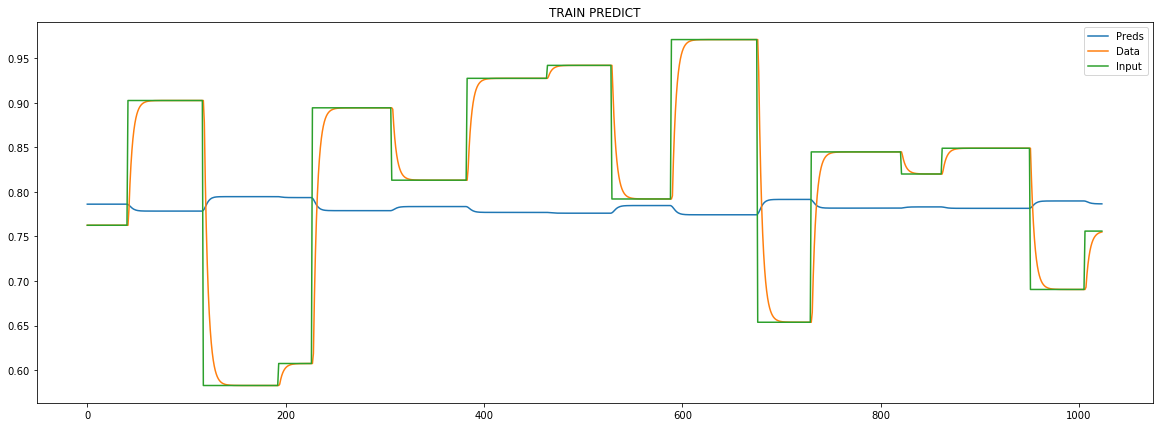

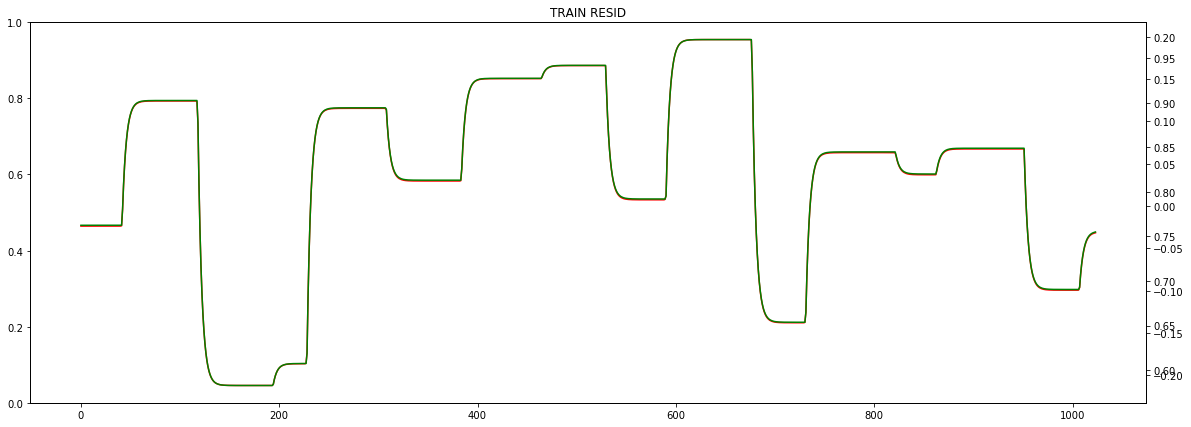

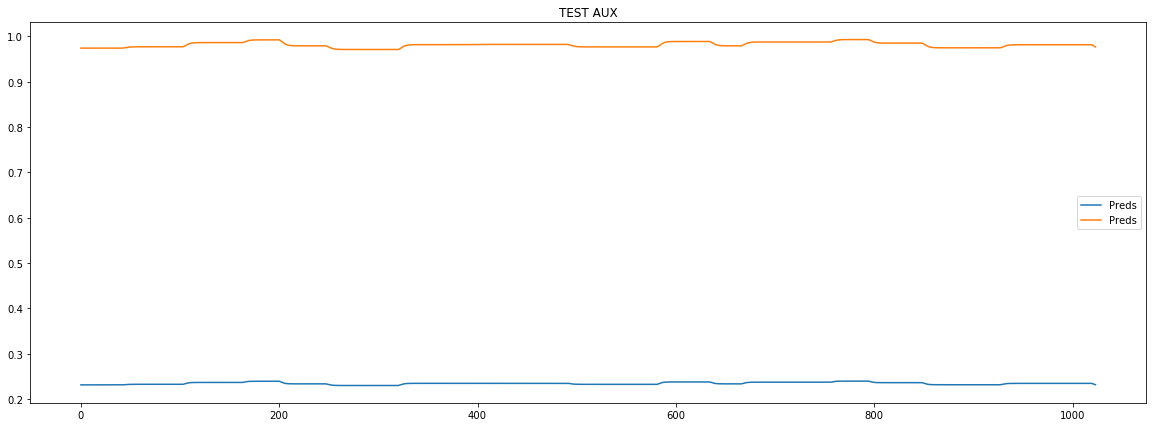

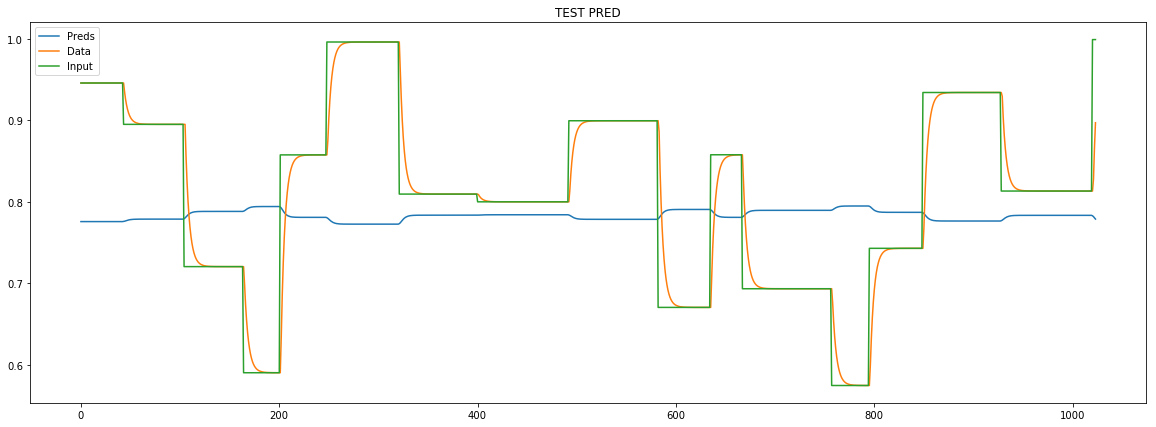

loss rate [0.1344826260518608]
Epoch [10] 
     train_loss[9939.722608288392] 
     eval_train[9890.375538987071] 
     eval_test[11260.413001159035]



aux preds: 0.2351355254650116 0.9803839325904846
main loss 0.0
aux loss 9860.488900991586
const loss 0.04835438853702866
combined loss 9860.537255380123 


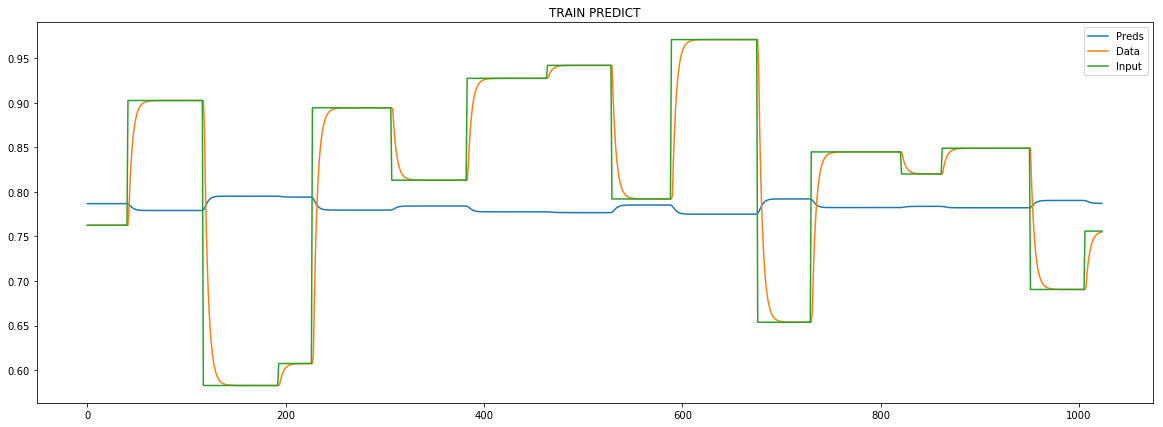

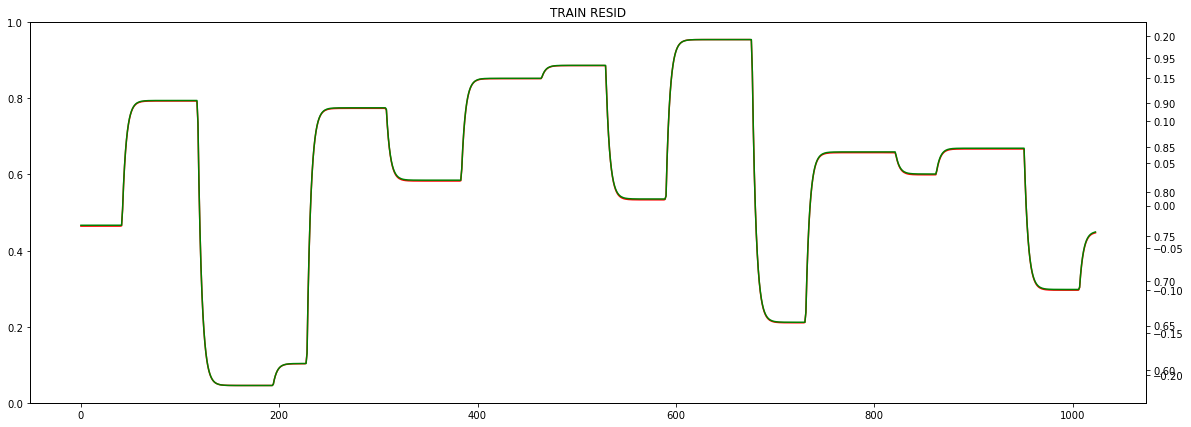

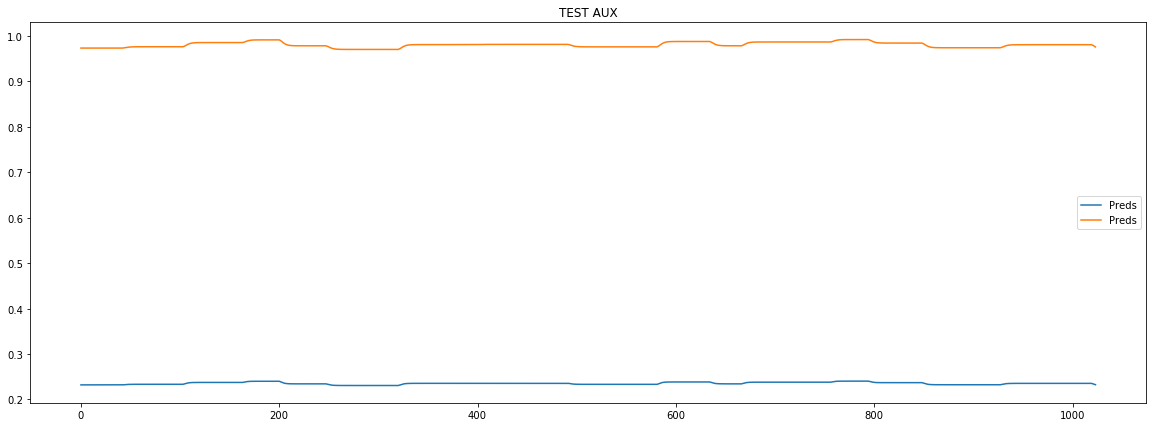

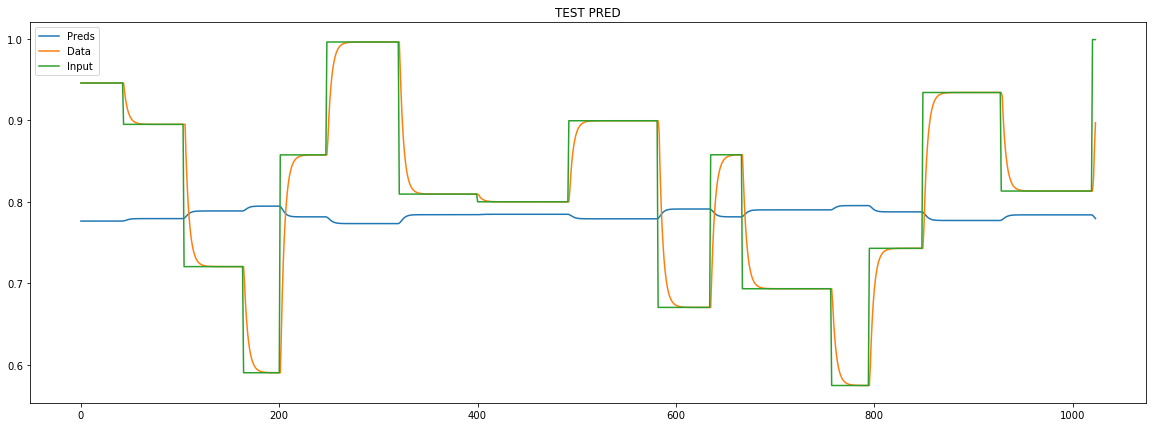

loss rate [0.02568650759732638]
Epoch [11] 
     train_loss[9860.537255380123] 
     eval_train[9813.068655427867] 
     eval_test[11170.715786719187]



aux preds: 0.23595312237739563 0.979850709438324
main loss 0.0
aux loss 9781.872774564303
const loss 0.047705653947419845
combined loss 9781.92048021825 


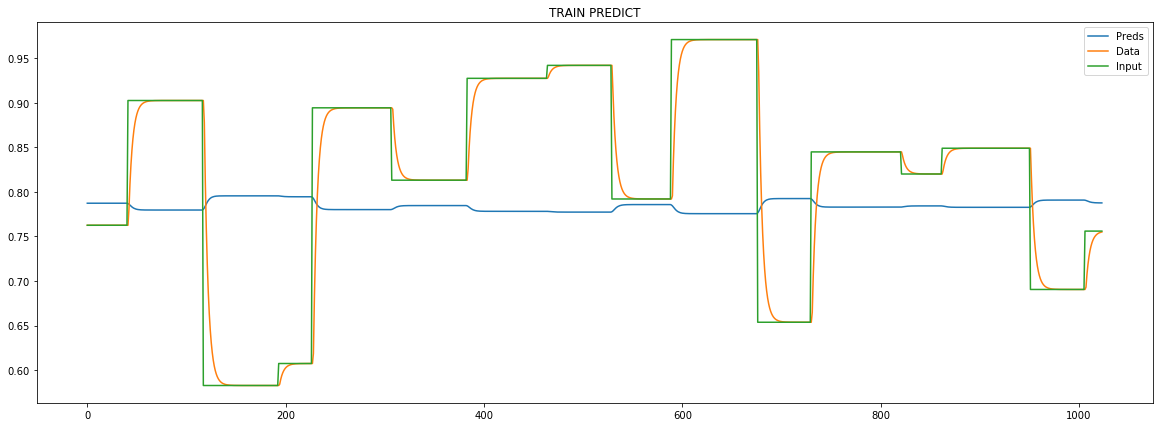

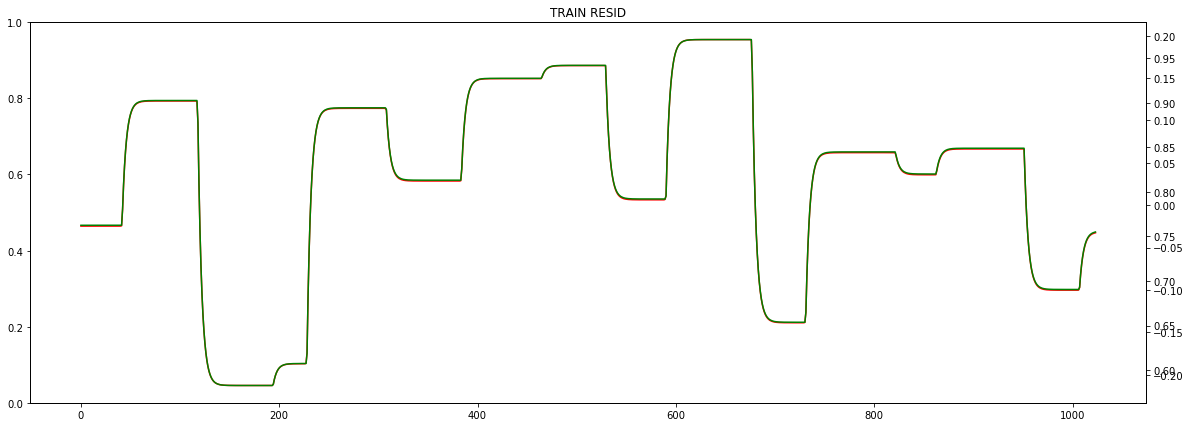

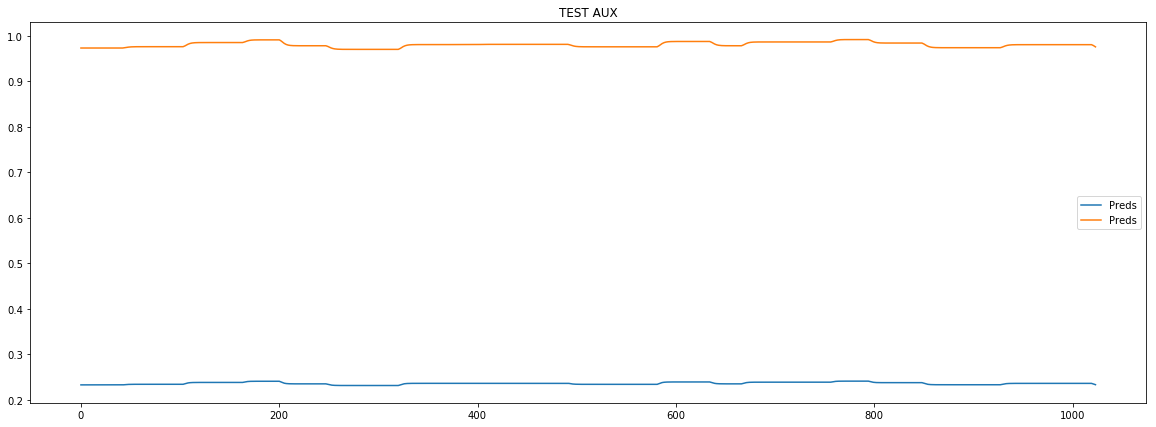

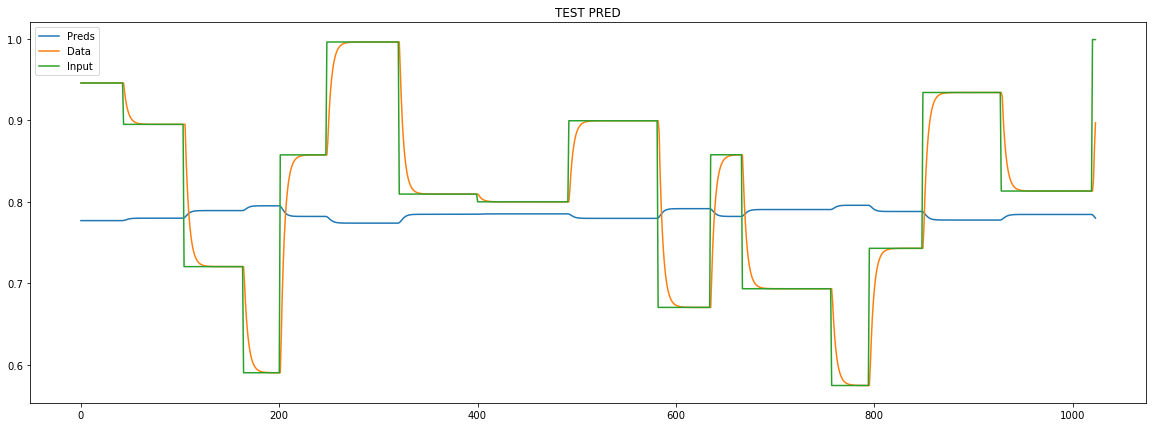

loss rate [0.016584473957119372]
Epoch [12] 
     train_loss[9781.92048021825] 
     eval_train[9732.851816096738] 
     eval_test[11079.399415284988]



aux preds: 0.23681136965751648 0.9792863130569458
main loss 0.0
aux loss 9700.536630483773
const loss 0.047021832317113876
combined loss 9700.58365231609 


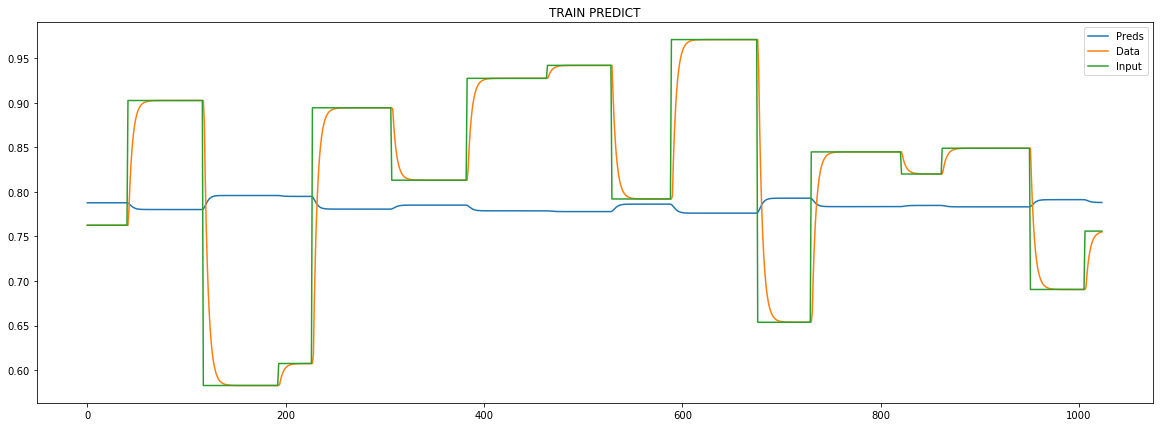

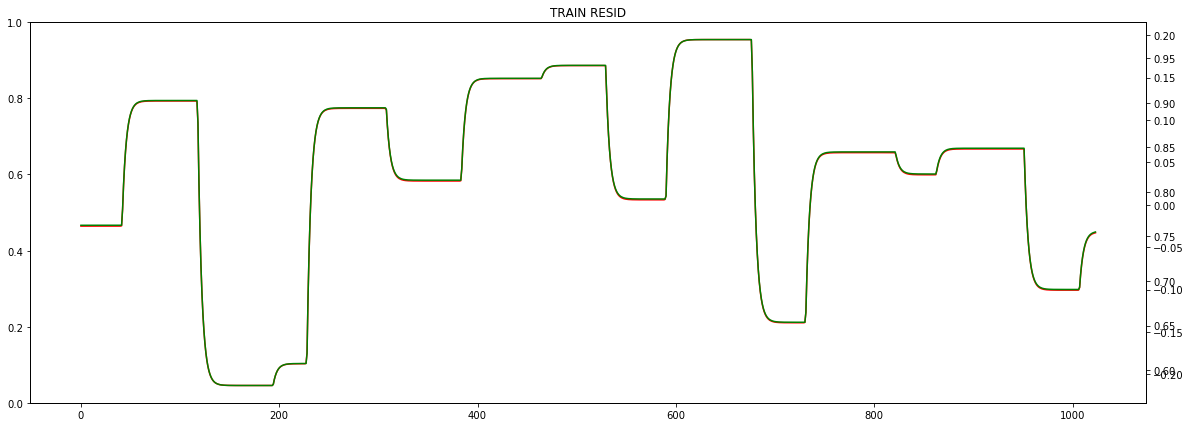

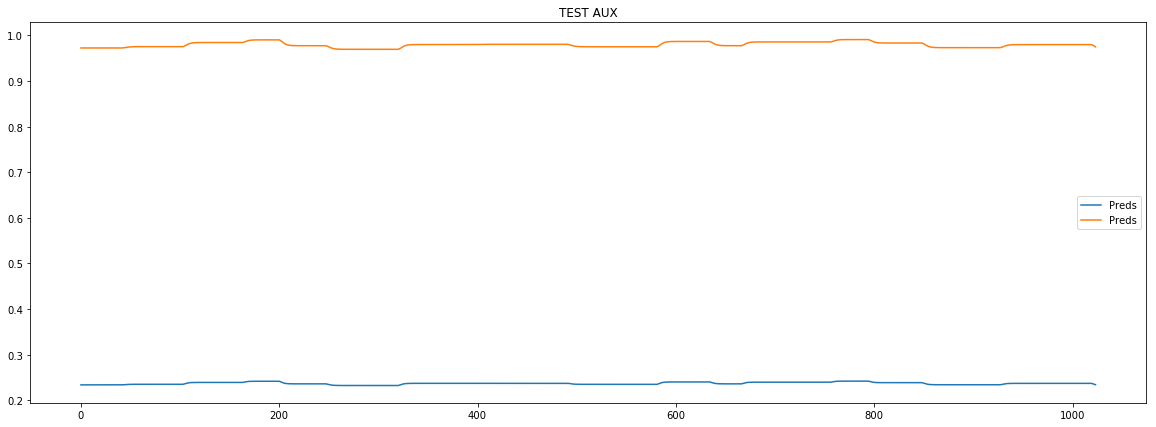

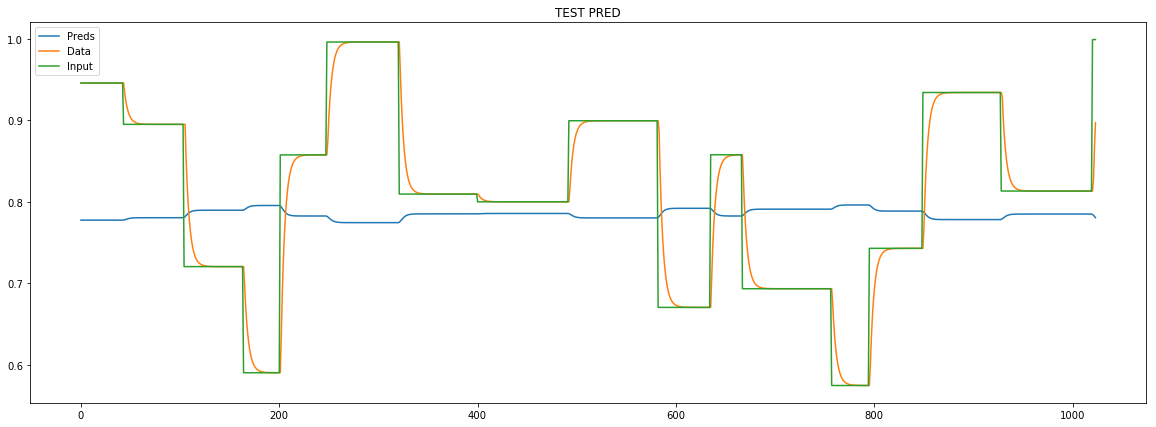

loss rate [0.016590834737886473]
Epoch [13] 
     train_loss[9700.58365231609] 
     eval_train[9649.72424100454] 
     eval_test[10984.853522588415]



aux preds: 0.23771005868911743 0.9786950945854187
main loss 0.0
aux loss 9616.321054311898
const loss 0.046314307810881965
combined loss 9616.367368619709 


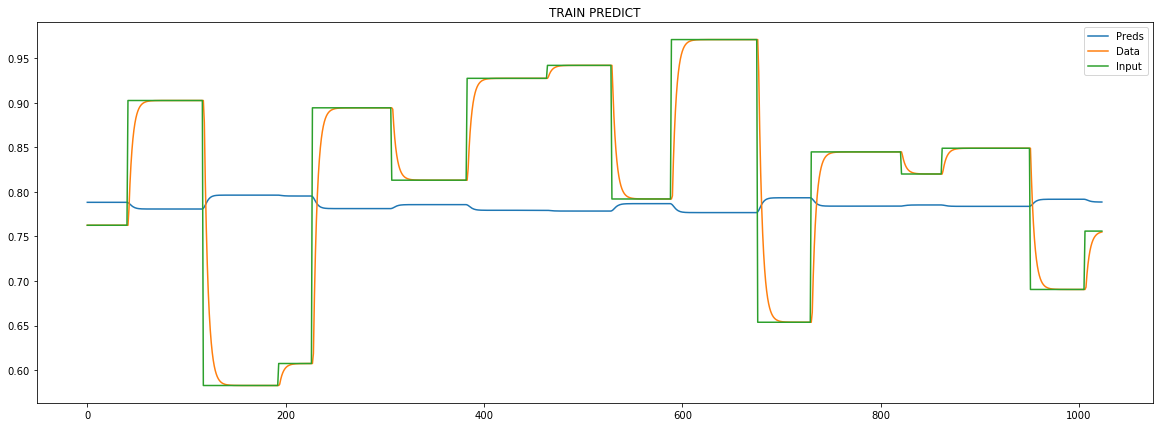

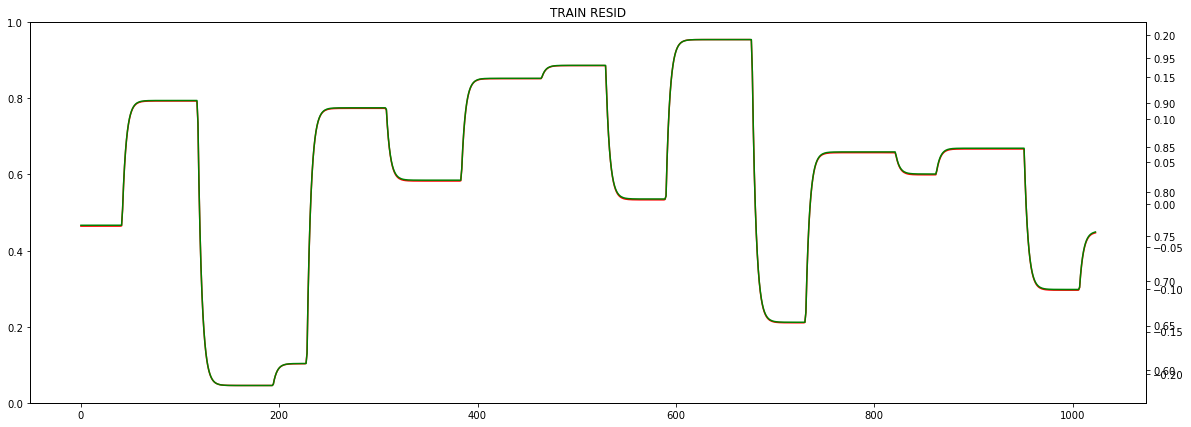

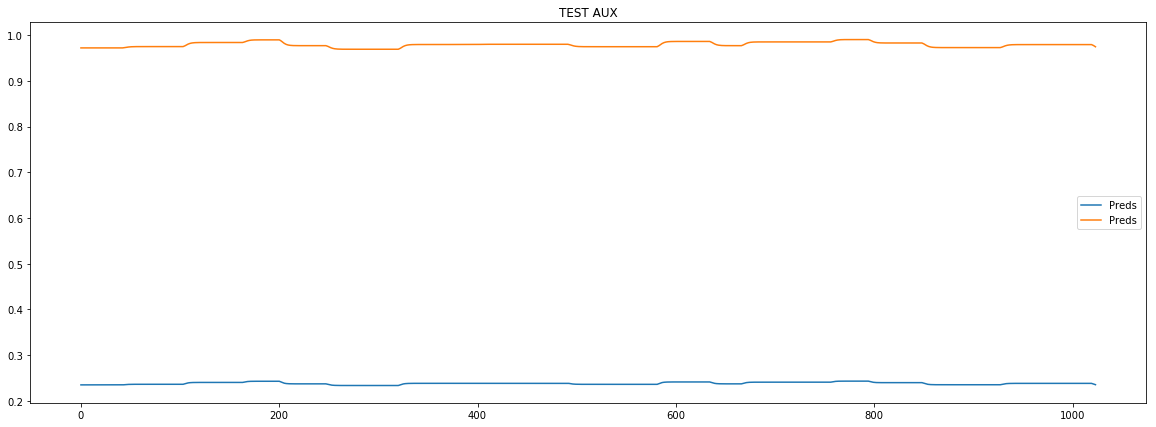

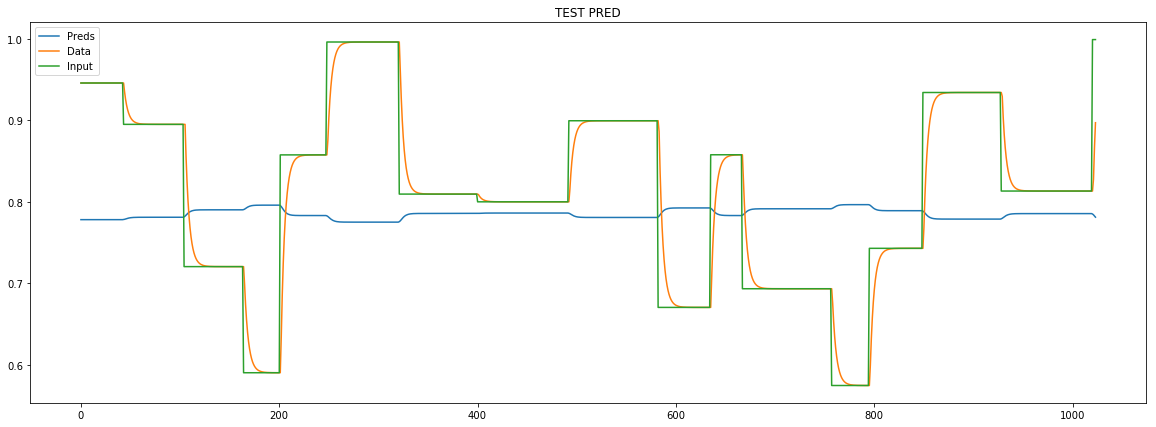

loss rate [0.01726204403343856]
Epoch [14] 
     train_loss[9616.367368619709] 
     eval_train[9563.777166619575] 
     eval_test[10887.088410339573]



aux preds: 0.238648921251297 0.9780733585357666
main loss 0.0
aux loss 9529.315880408654
const loss 0.04558502101840881
combined loss 9529.361465429673 


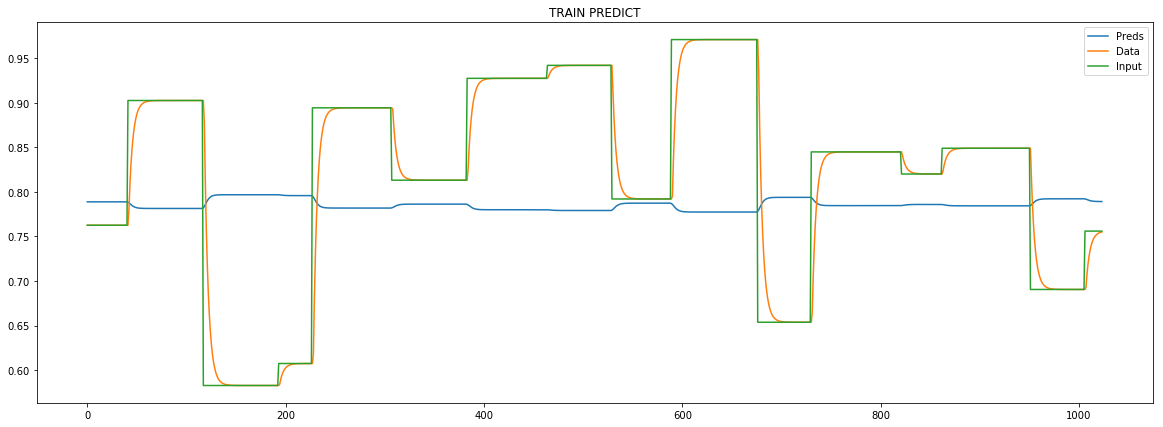

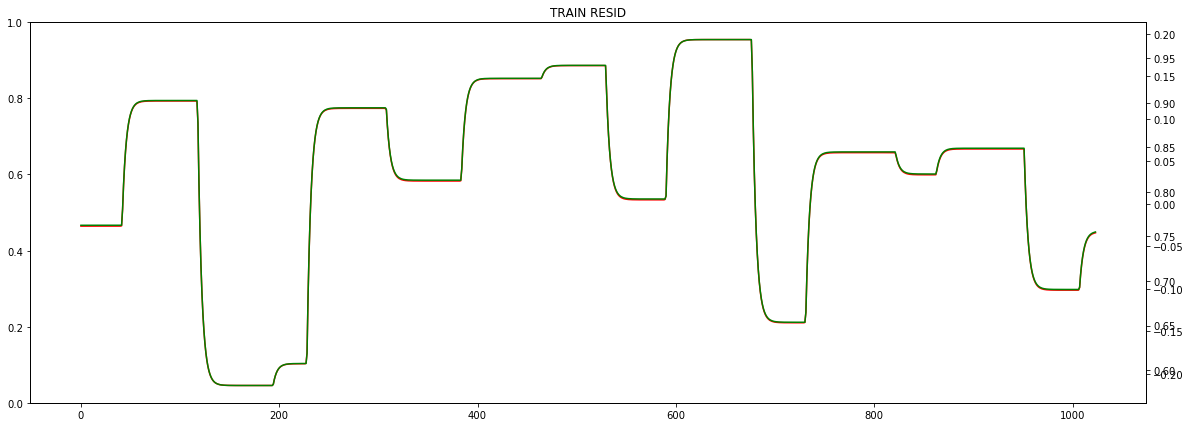

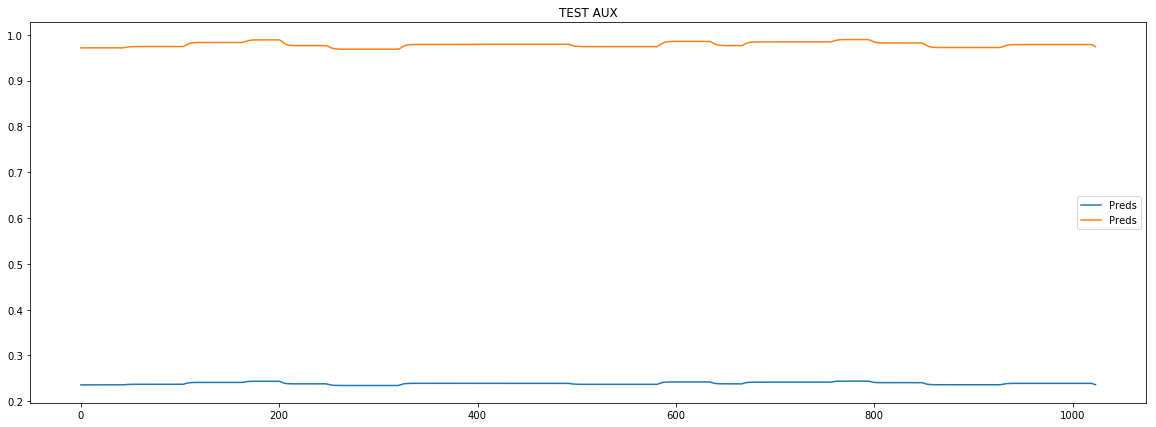

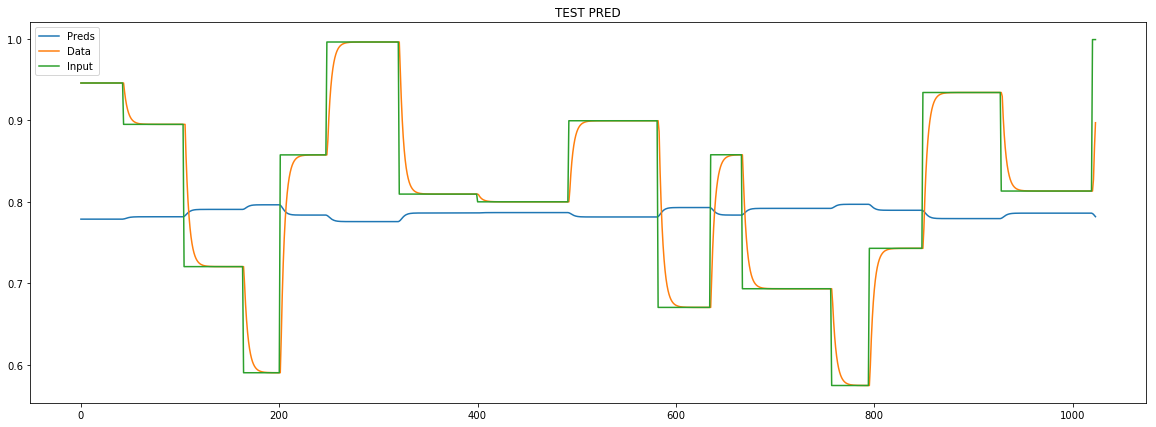

loss rate [0.017980904014722188]
Epoch [15] 
     train_loss[9529.361465429673] 
     eval_train[9475.154233568097] 
     eval_test[10786.282147424803]



aux preds: 0.23962976038455963 0.9774265289306641
main loss 0.0
aux loss 9439.720271183895
const loss 0.04483507670318851
combined loss 9439.765106260598 


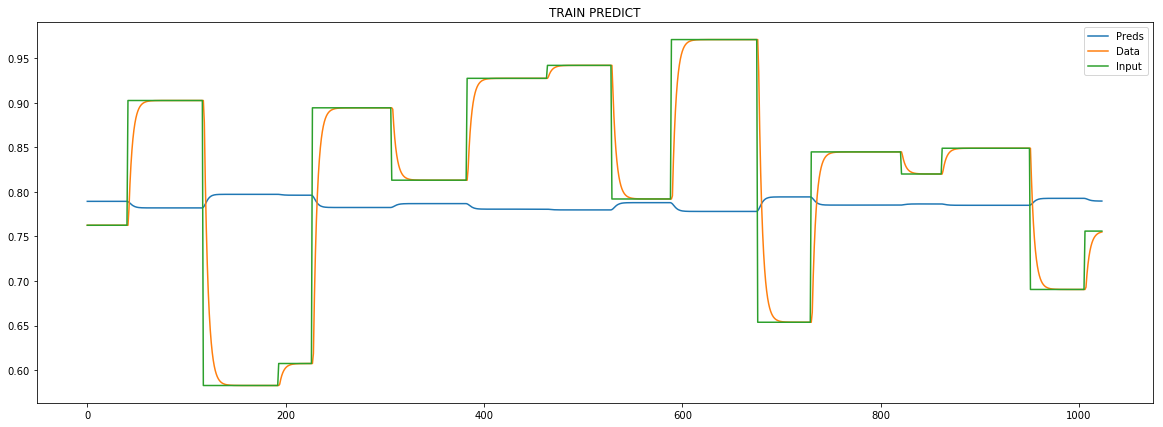

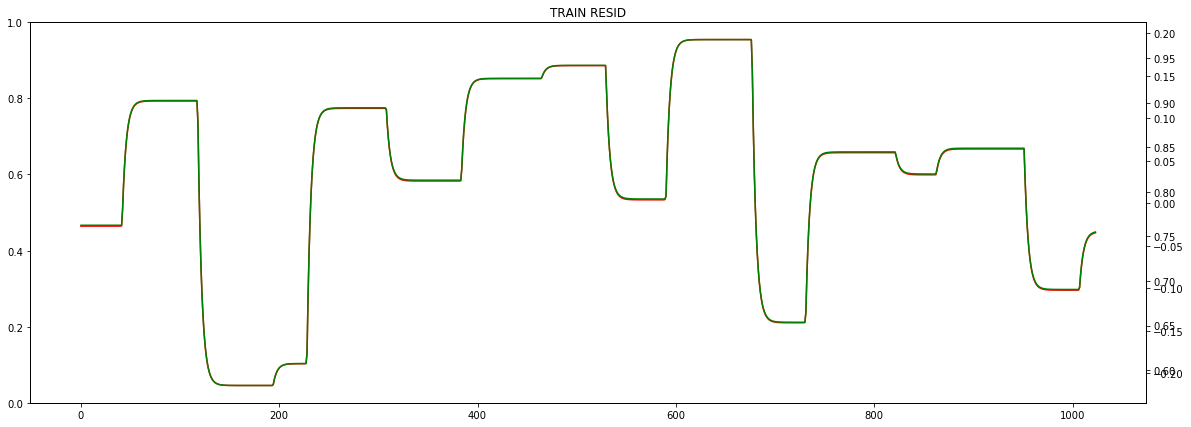

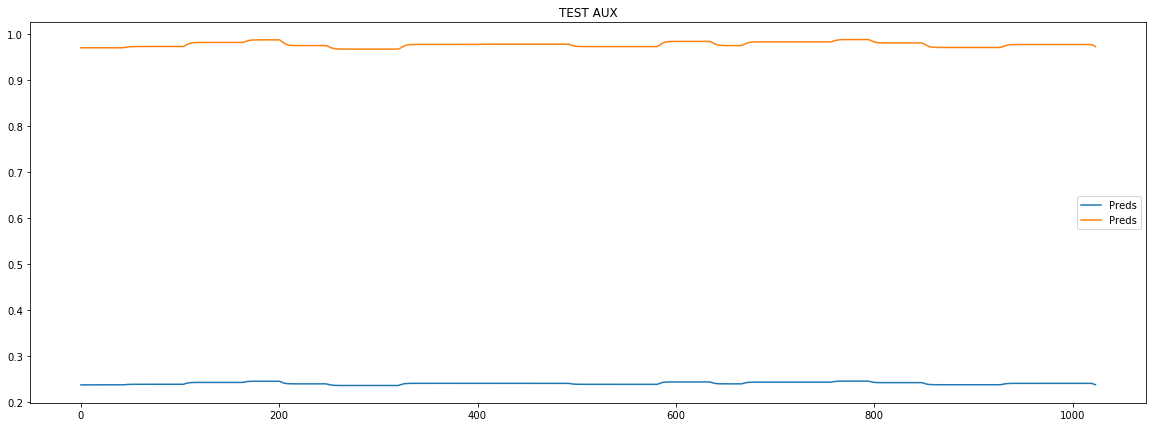

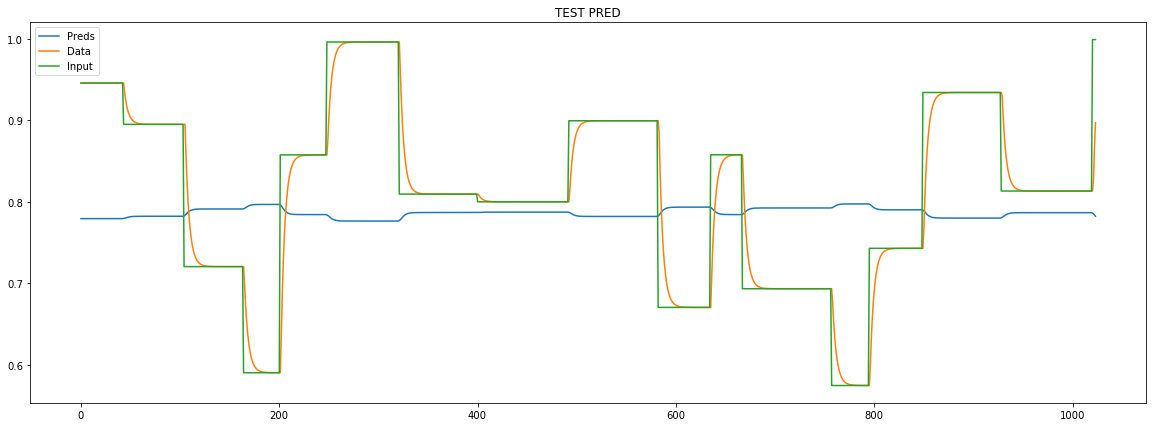

loss rate [0.018689739132276117]
Epoch [16] 
     train_loss[9439.765106260598] 
     eval_train[9383.965841308738] 
     eval_test[10682.61679725586]



aux preds: 0.24064989387989044 0.9767625331878662
main loss 0.0
aux loss 9347.59835111178
const loss 0.044065568381204054
combined loss 9347.64241668016 


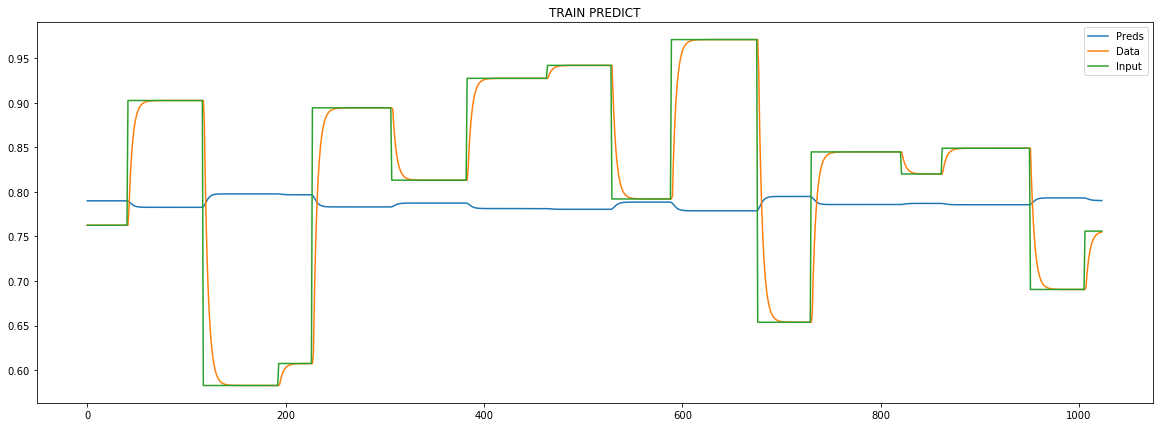

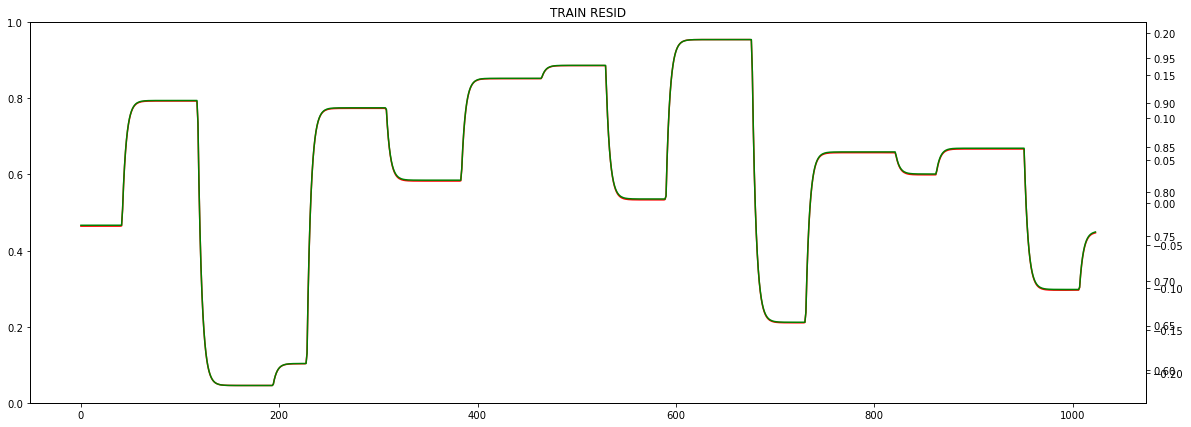

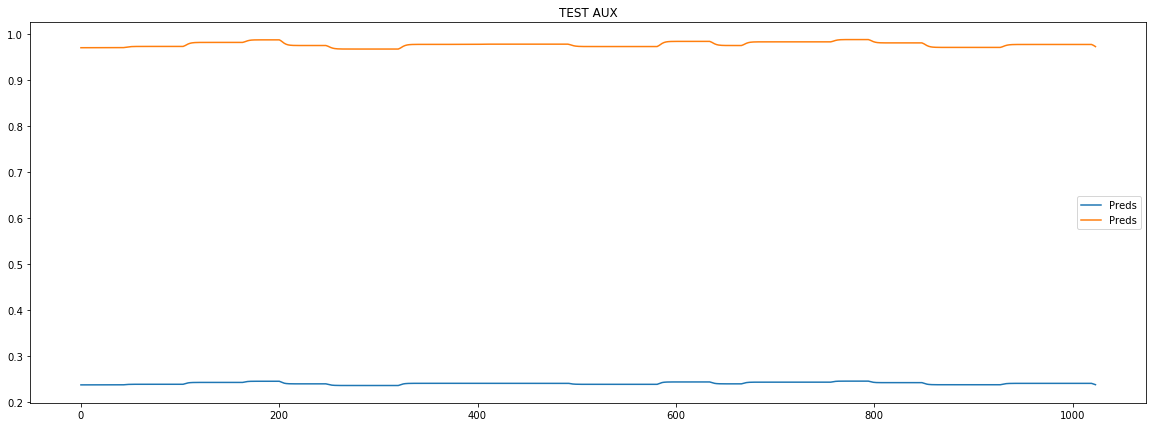

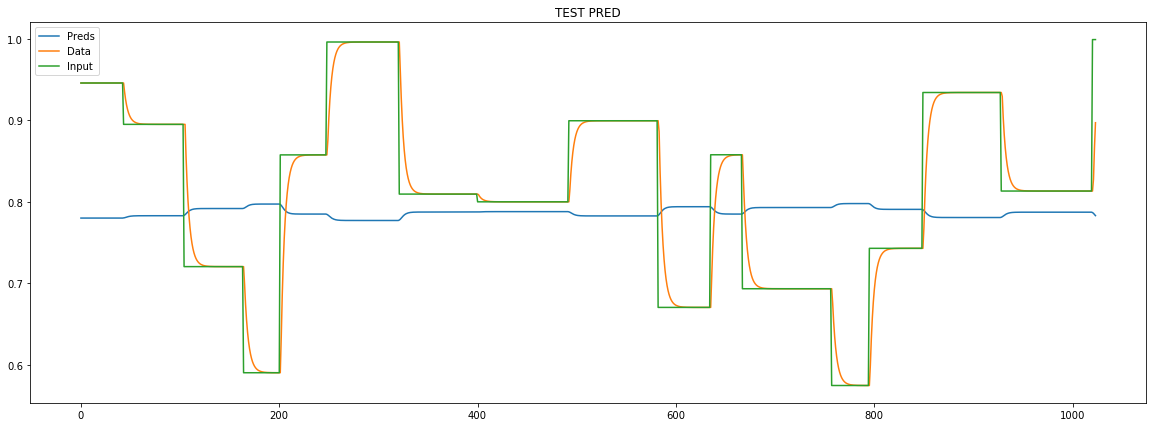

loss rate [0.01939939464341922]
Epoch [17] 
     train_loss[9347.64241668016] 
     eval_train[9290.328962470297] 
     eval_test[10576.10026241424]



aux preds: 0.24171224236488342 0.97606360912323
main loss 0.0
aux loss 9253.067542442908
const loss 0.04327752978469317
combined loss 9253.110819972693 


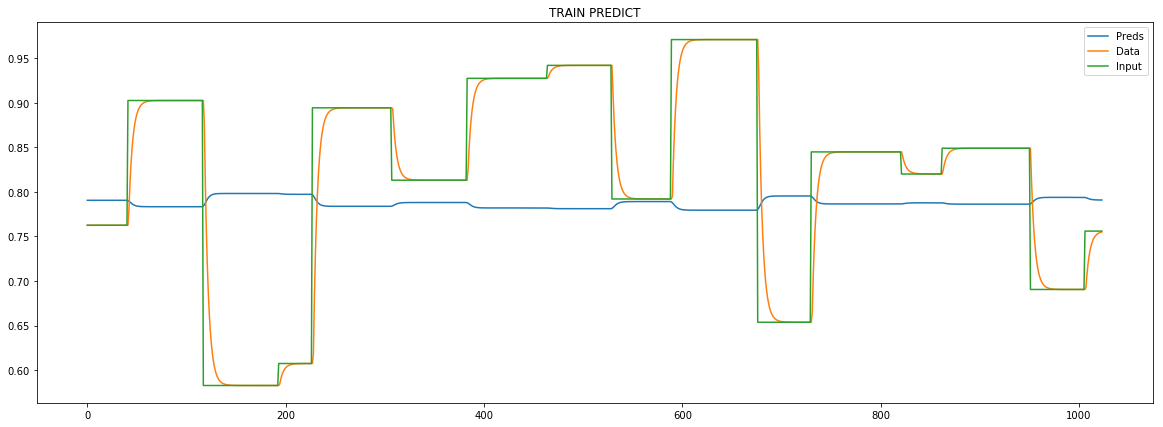

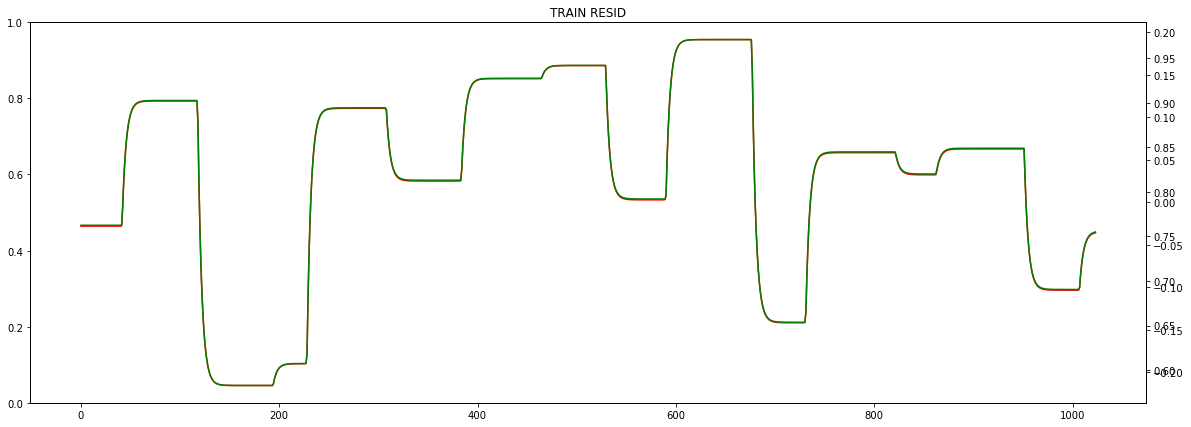

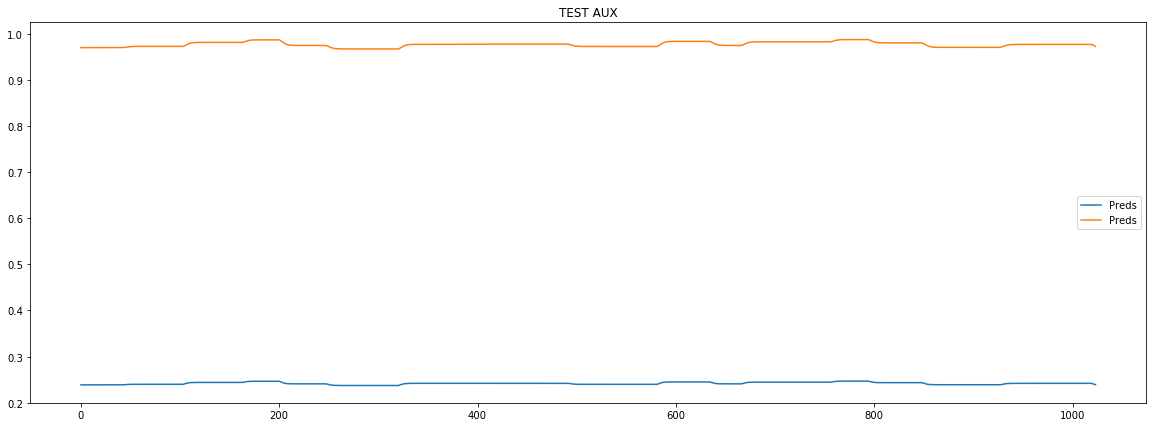

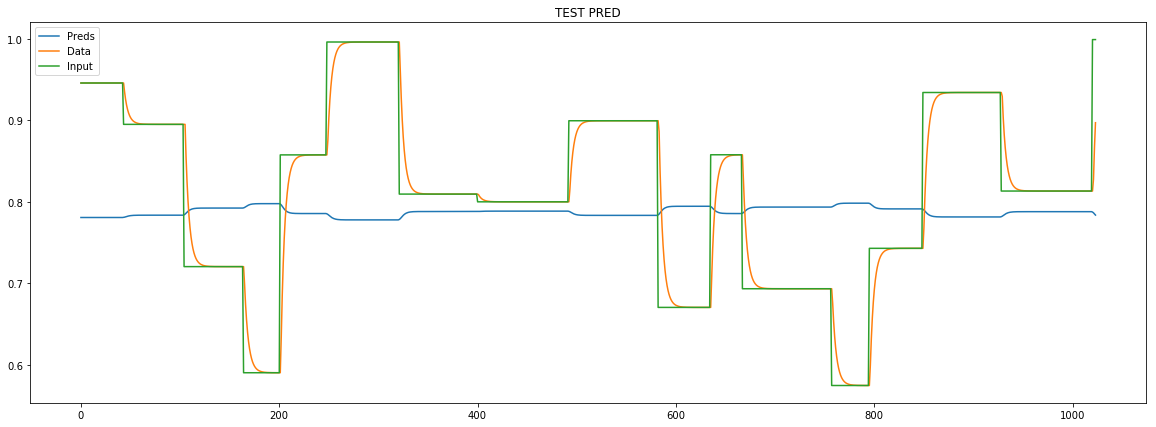

loss rate [0.02010441824265674]
Epoch [18] 
     train_loss[9253.110819972693] 
     eval_train[9194.34680380769] 
     eval_test[10466.917713483286]



aux preds: 0.24281717836856842 0.9753482341766357
main loss 0.0
aux loss 9156.265258789062
const loss 0.04247194521415692
combined loss 9156.307730734277 


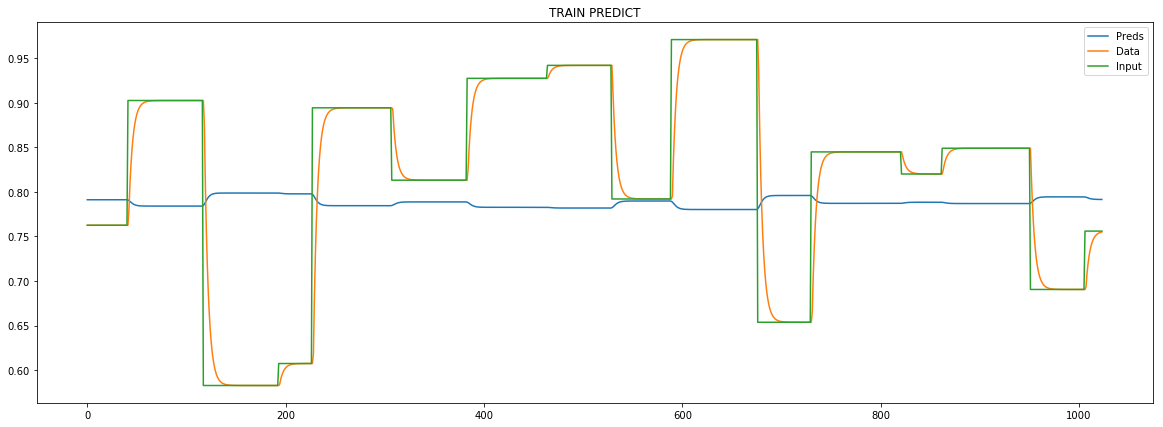

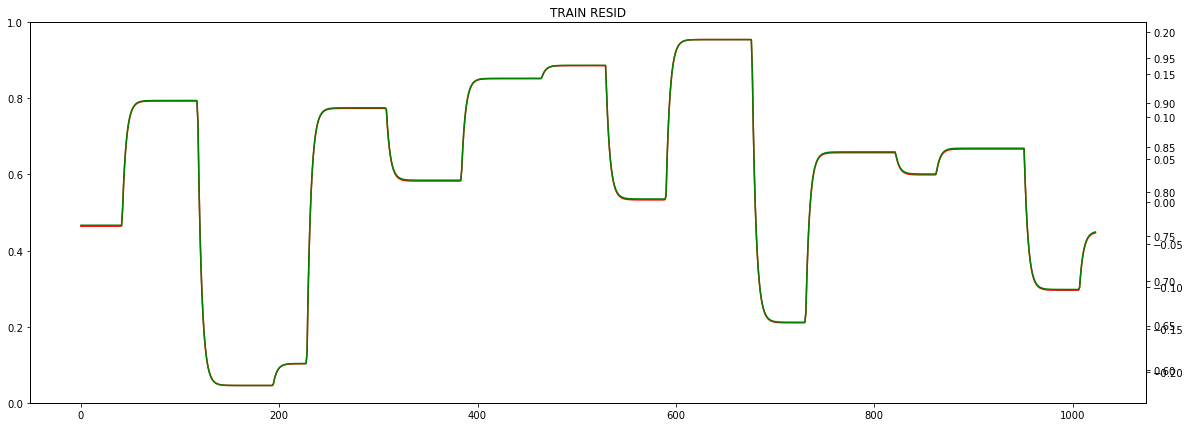

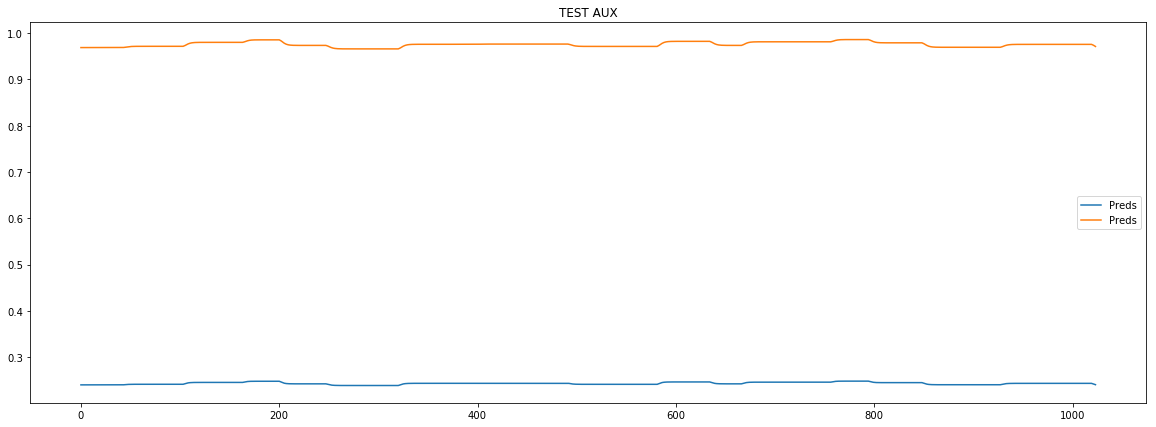

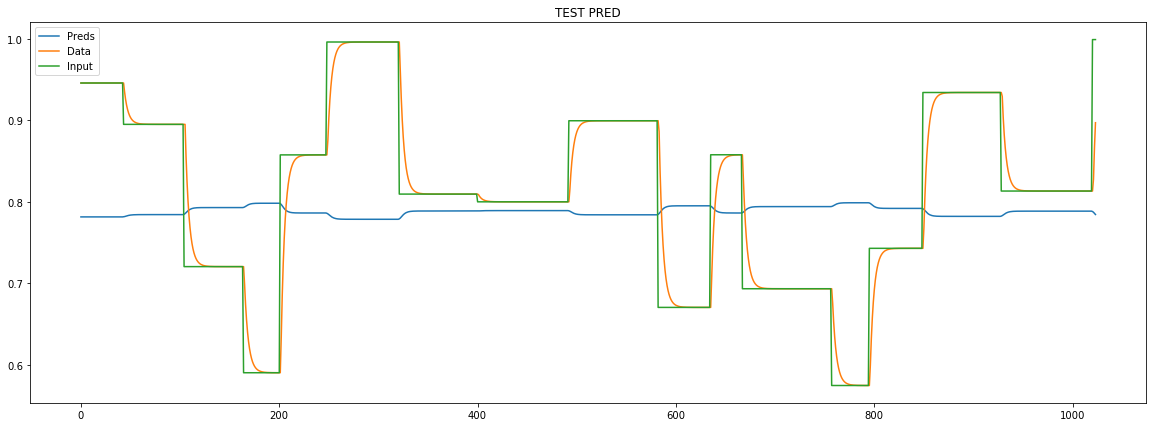

loss rate [0.020799546025924598]
Epoch [19] 
     train_loss[9156.307730734277] 
     eval_train[9096.13924874437] 
     eval_test[10355.25199082917]



aux preds: 0.2439640462398529 0.9746003746986389
main loss 0.0
aux loss 9057.237351637621
const loss 0.04164966568350792
combined loss 9057.279001303305 


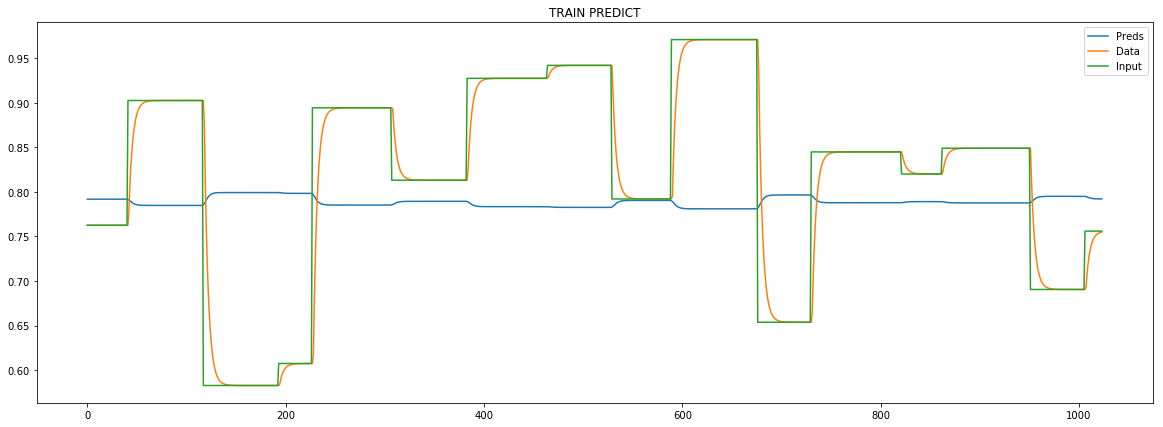

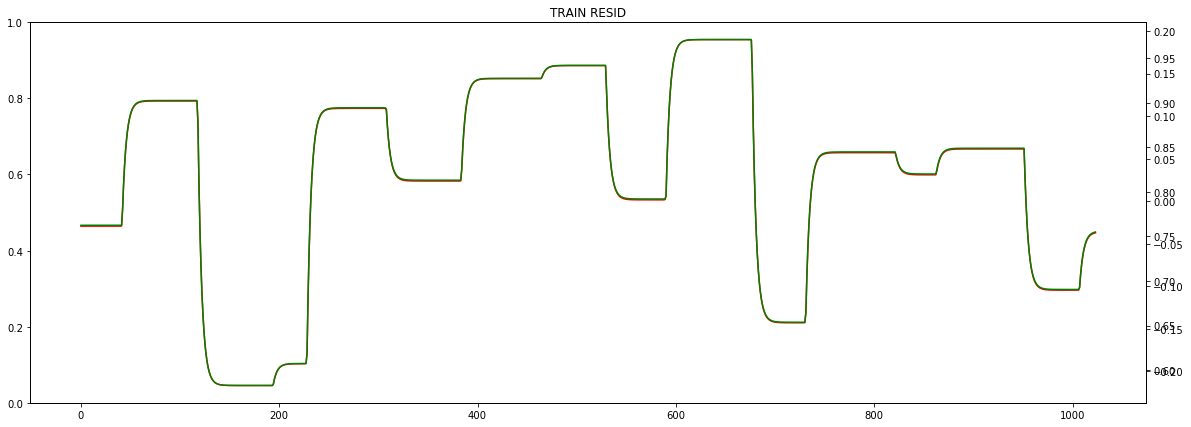

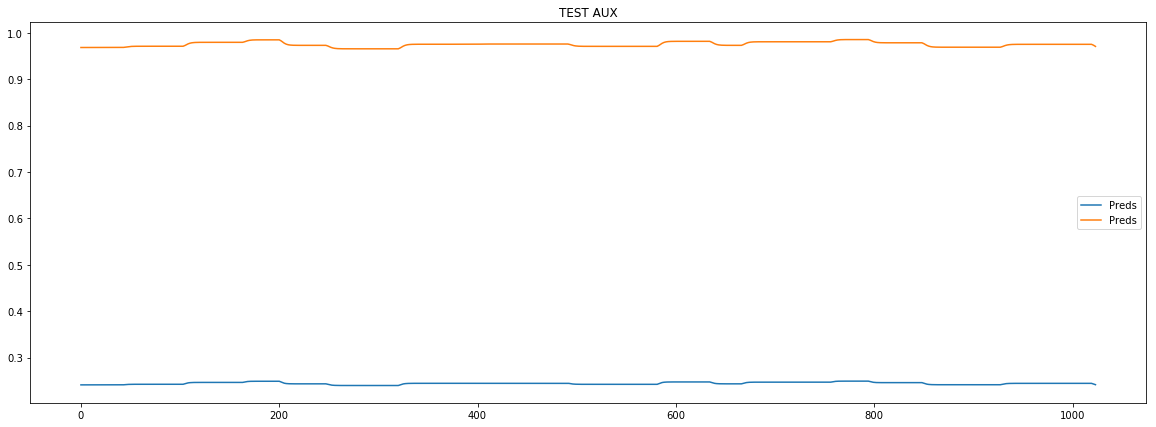

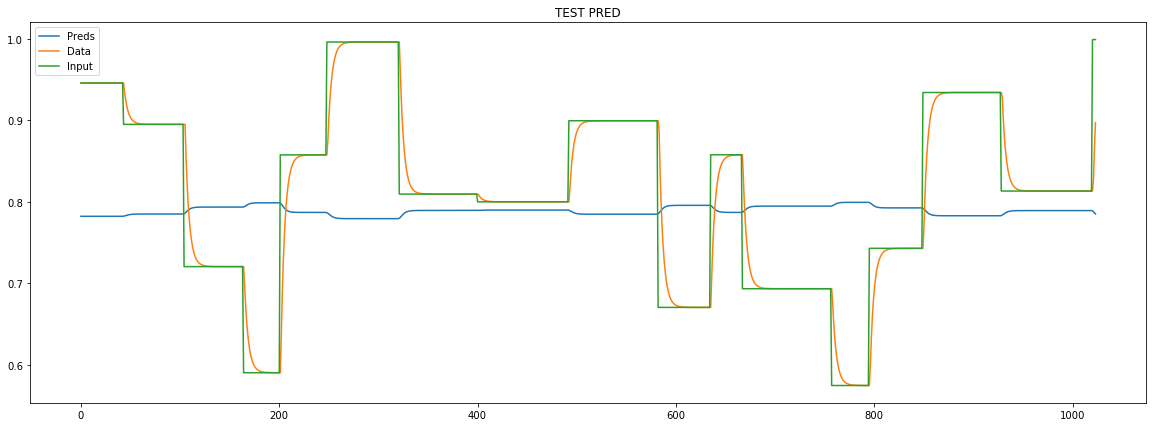

loss rate [0.021490082377830344]
Epoch [20] 
     train_loss[9057.279001303305] 
     eval_train[8995.831833262031] 
     eval_test[10241.172852873462]



aux preds: 0.24515283107757568 0.9738295674324036
main loss 0.0
aux loss 8956.171264648438
const loss 0.04081167058589367
combined loss 8956.212076319023 


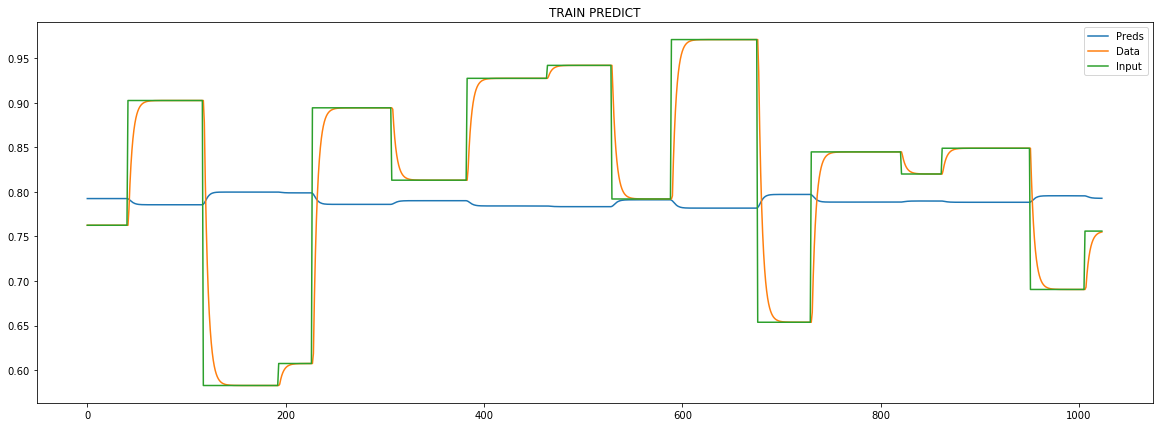

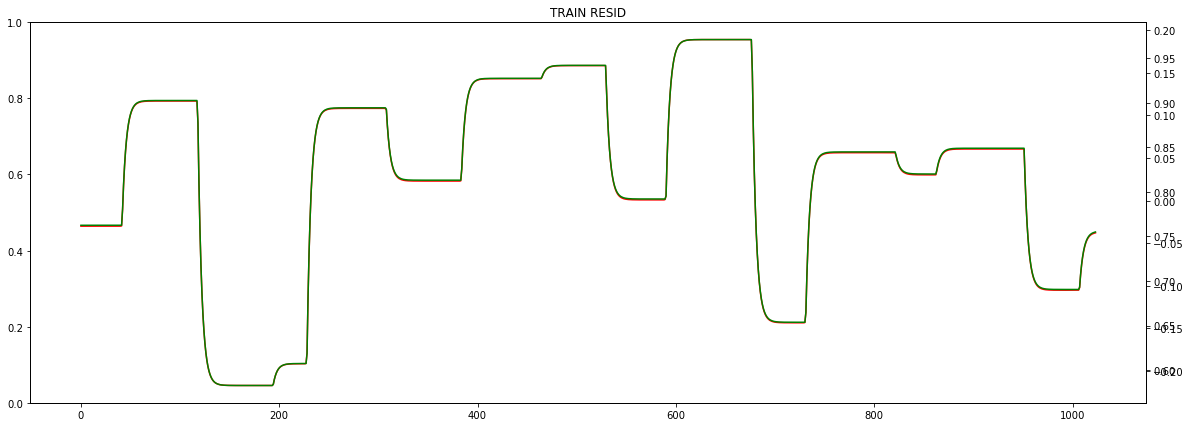

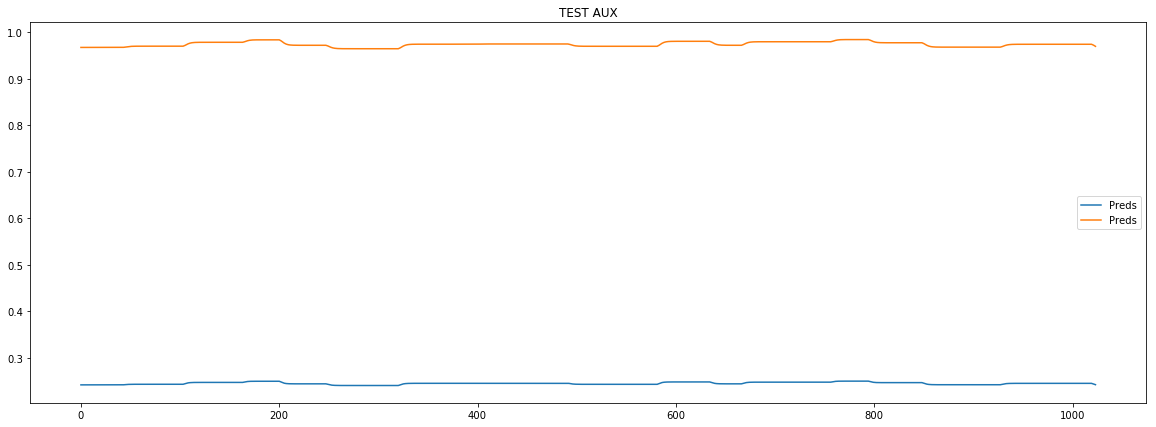

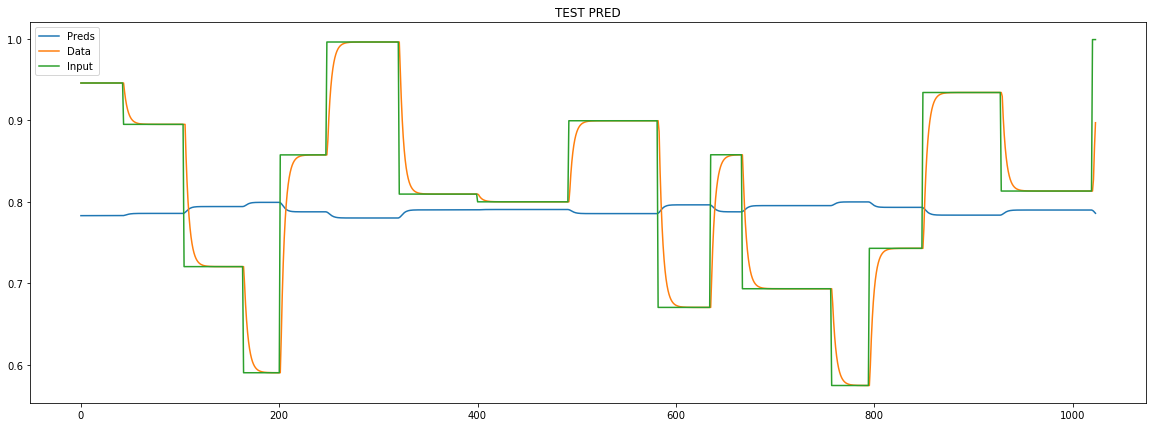

loss rate [0.02217883535567544]
Epoch [21] 
     train_loss[8956.212076319023] 
     eval_train[8893.472569739053] 
     eval_test[10124.797932337715]



aux preds: 0.24638424813747406 0.9730308055877686
main loss 0.0
aux loss 8853.12539438101
const loss 0.03995893763091702
combined loss 8853.16535331864 


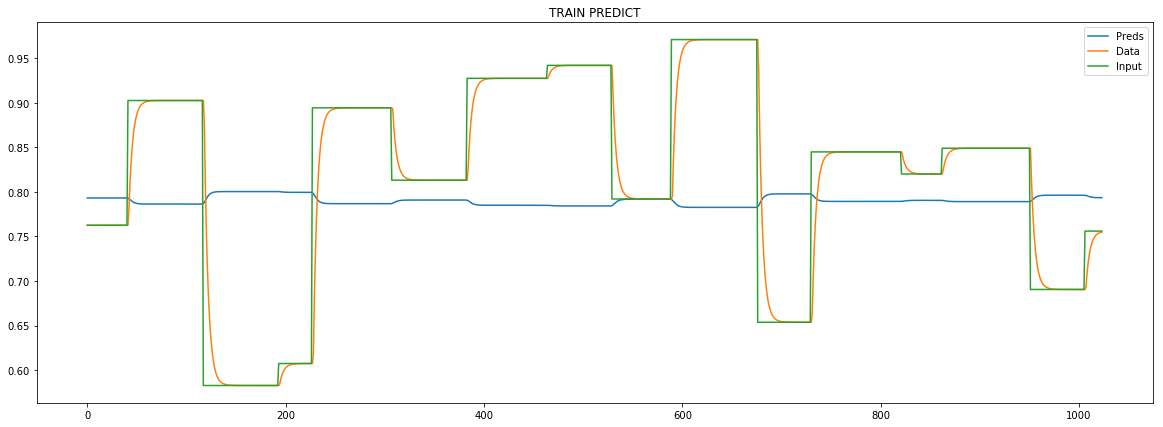

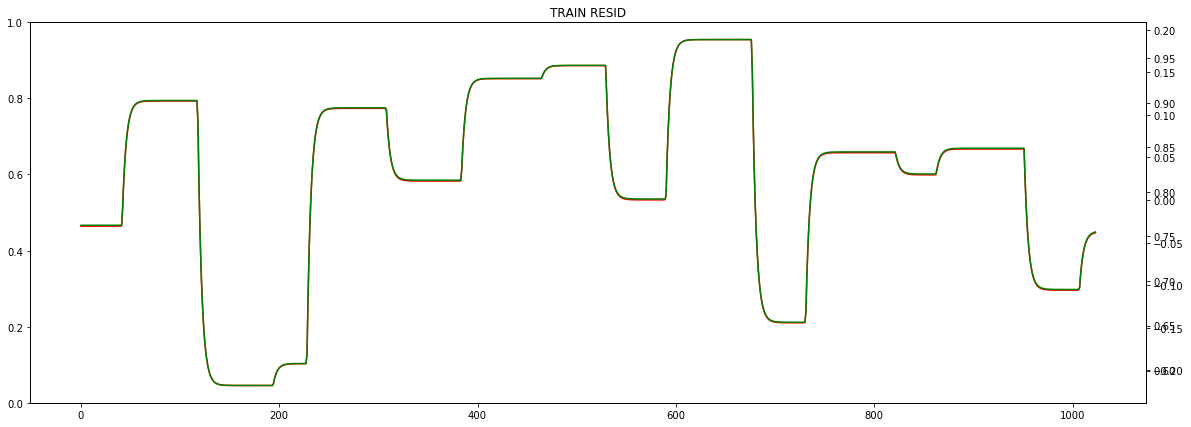

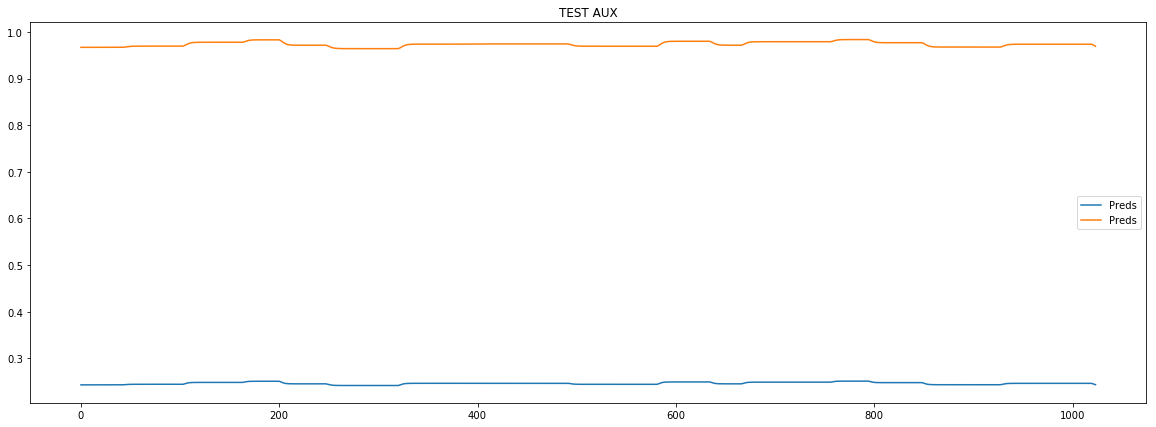

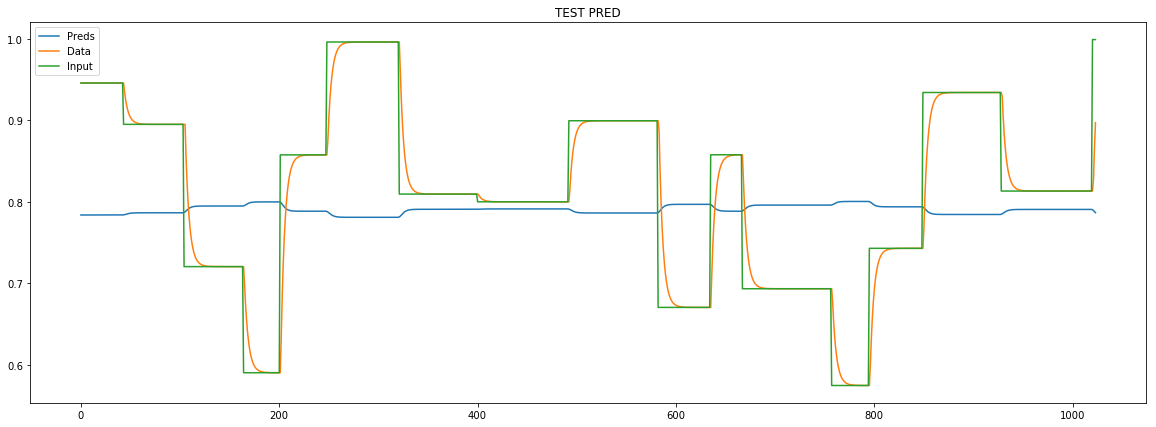

loss rate [0.022864010345019614]
Epoch [22] 
     train_loss[8853.16535331864] 
     eval_train[8789.231418316396] 
     eval_test[10006.270806892437]



aux preds: 0.24765972793102264 0.9722086787223816
main loss 0.0
aux loss 8748.185490534855
const loss 0.03909219808589954
combined loss 8748.22458273294 


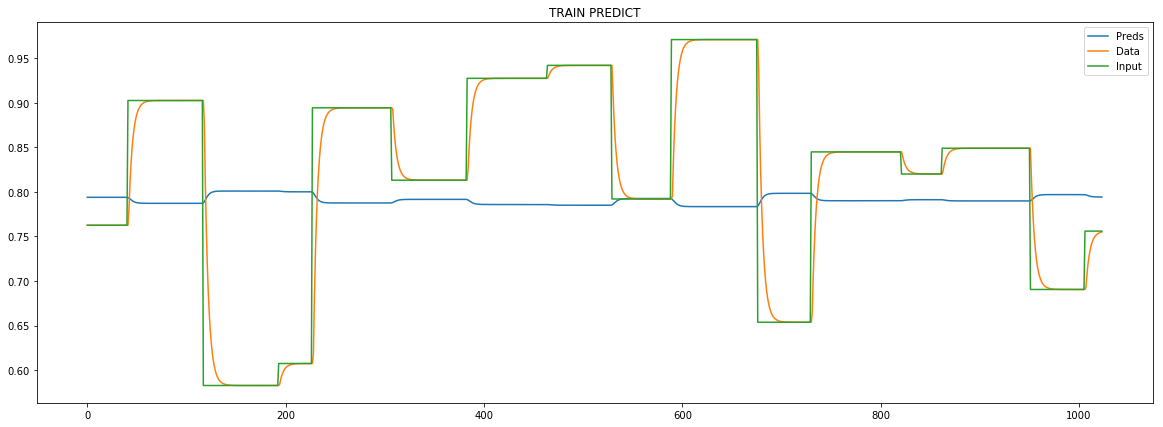

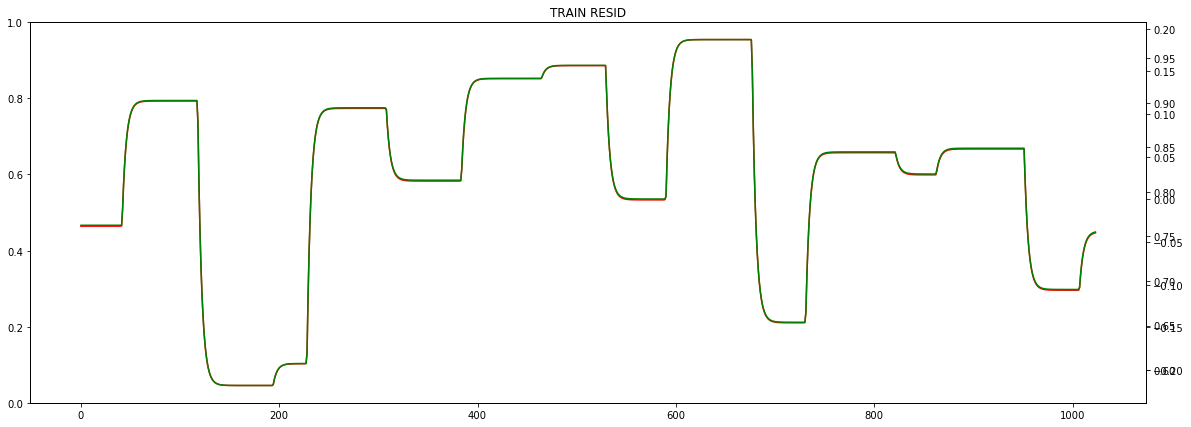

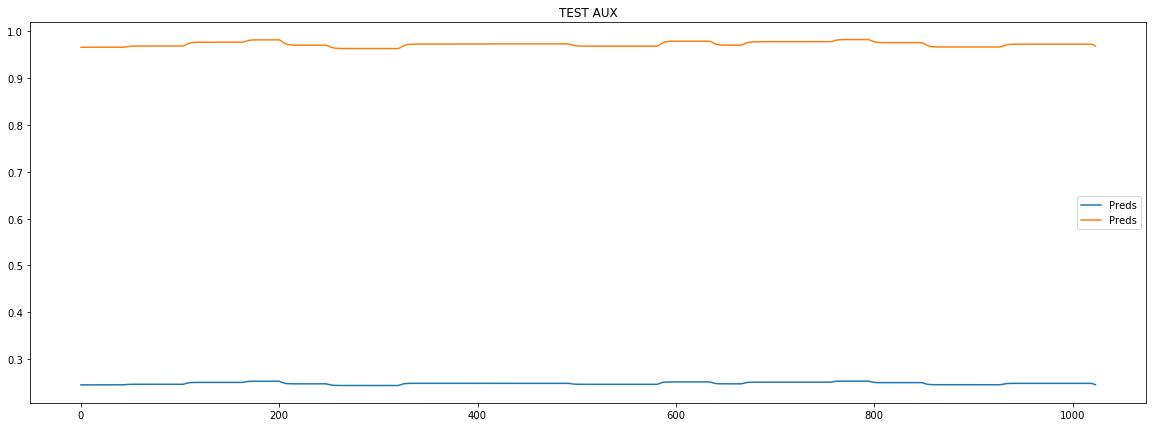

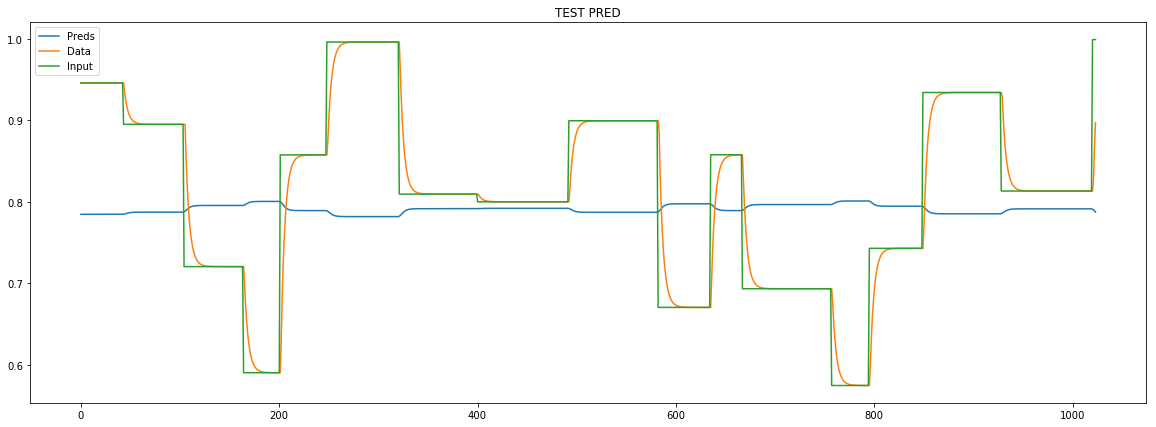

loss rate [0.023559441620903065]
Epoch [23] 
     train_loss[8748.22458273294] 
     eval_train[8683.132502807734] 
     eval_test[9885.562846472827]



aux preds: 0.24898162484169006 0.9713550806045532
main loss 0.0
aux loss 8641.473510742188
const loss 0.03821226936550094
combined loss 8641.511723011554 


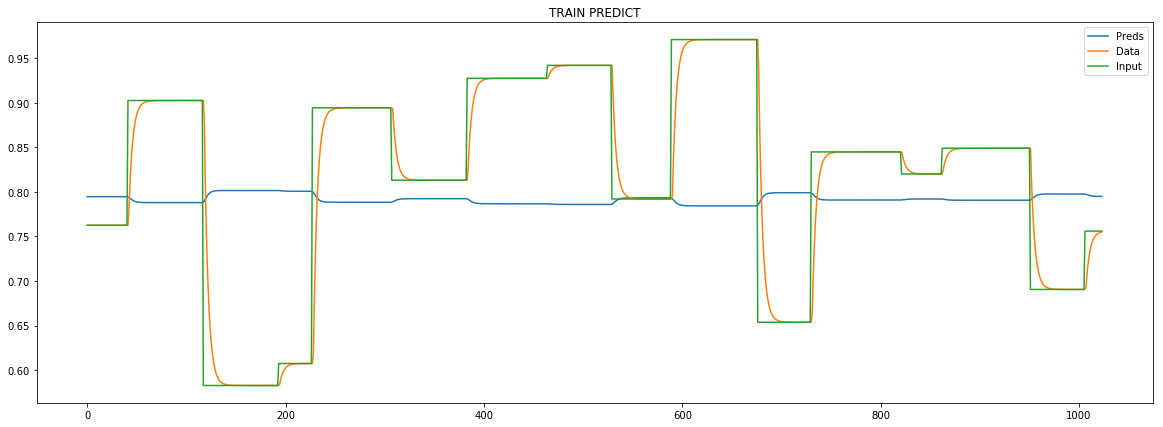

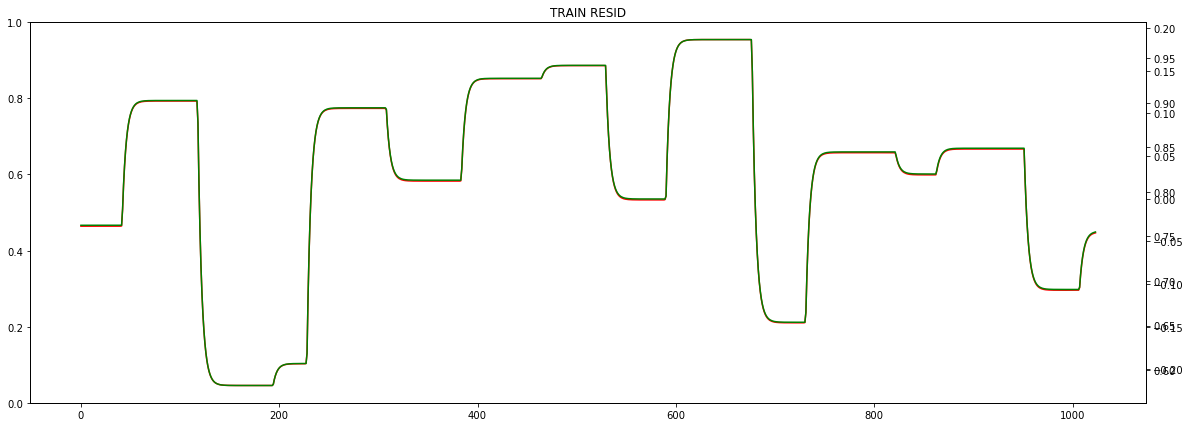

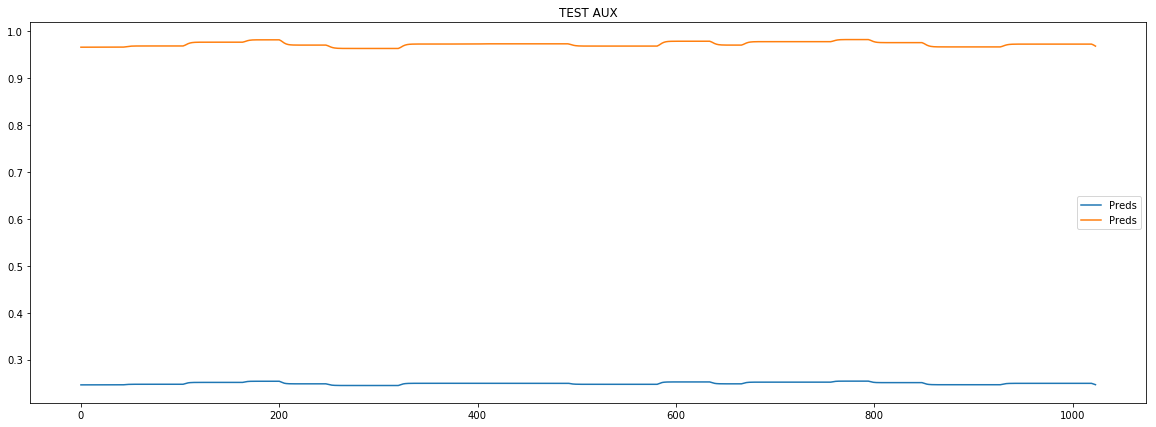

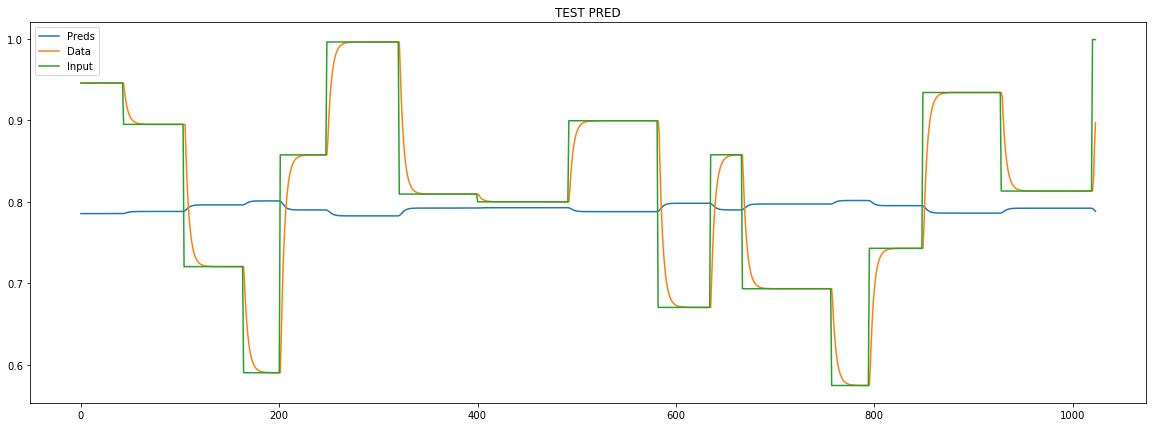

loss rate [0.02424786803359491]
Epoch [24] 
     train_loss[8641.511723011554] 
     eval_train[8575.295640656188] 
     eval_test[9762.930754733272]



aux preds: 0.250348299741745 0.9704776406288147
main loss 0.0
aux loss 8533.018479567309
const loss 0.037319937792535014
combined loss 8533.0557995051 


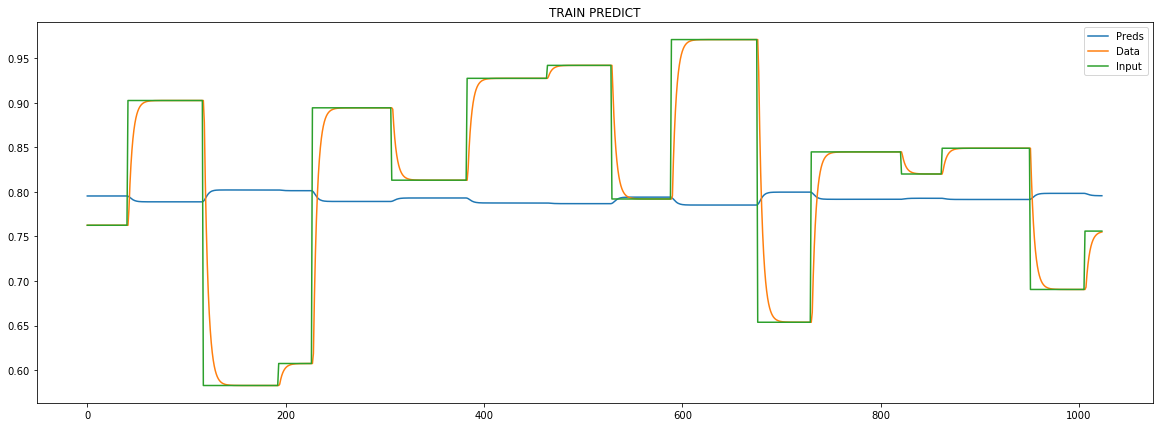

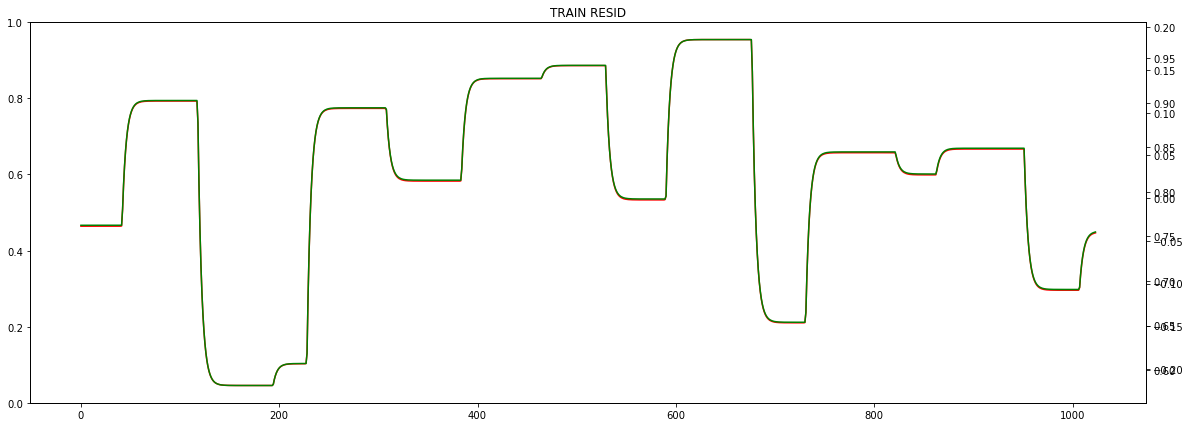

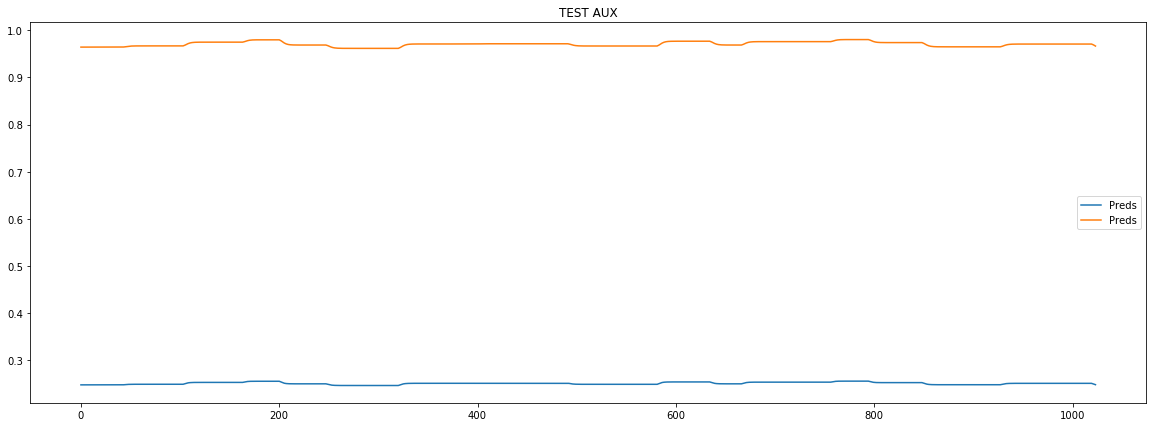

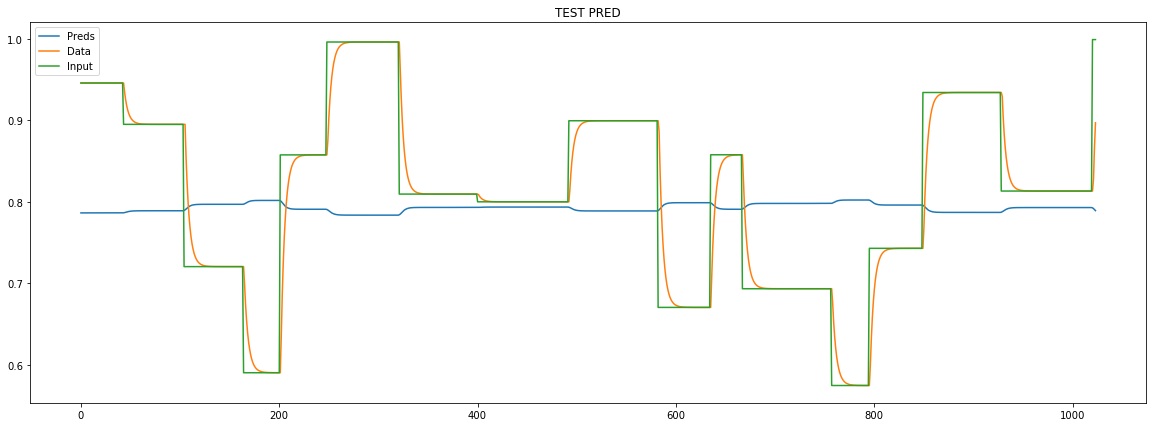

loss rate [0.02493687846919357]
Epoch [25] 
     train_loss[8533.0557995051] 
     eval_train[8465.812948743956] 
     eval_test[9638.422384007072]



aux preds: 0.25176069140434265 0.9695800542831421
main loss 0.0
aux loss 8422.972524789664
const loss 0.03641596264564074
combined loss 8423.00894075231 


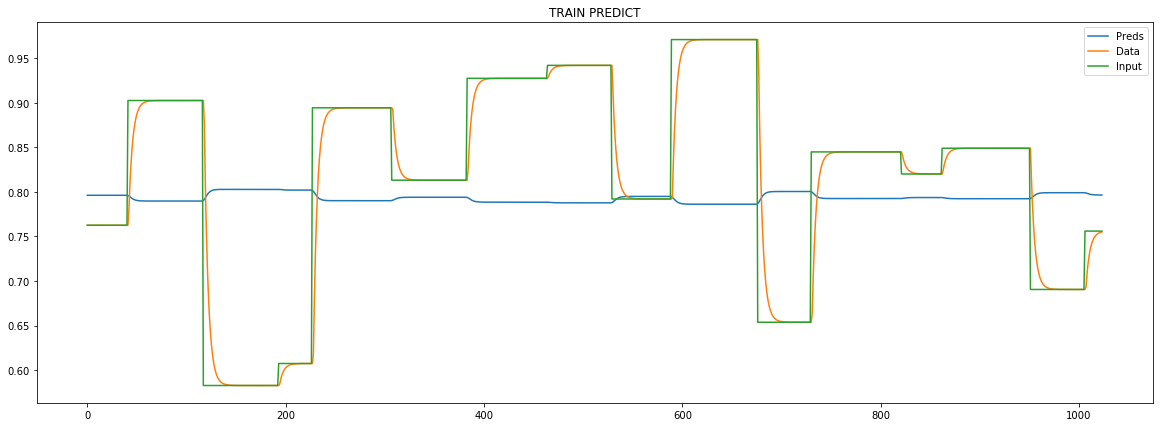

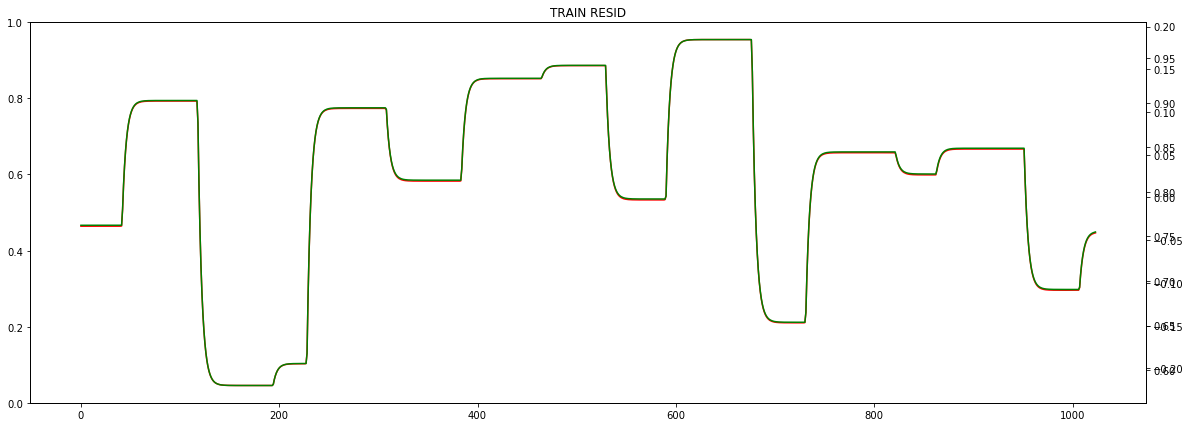

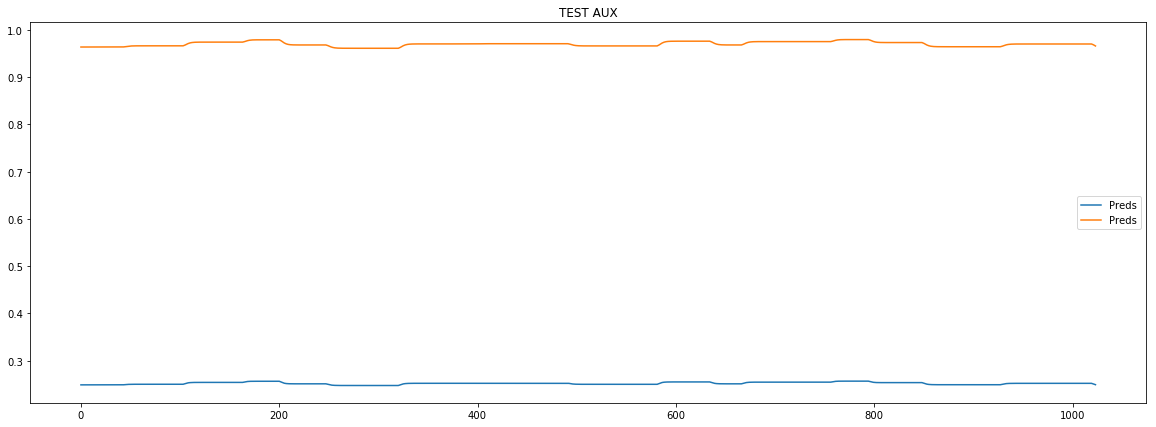

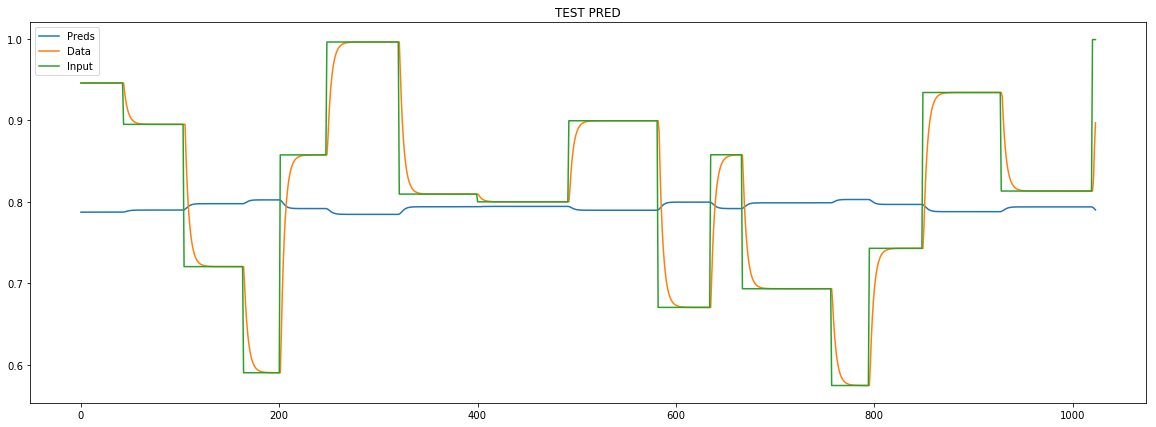

loss rate [0.02562723129363298]
Epoch [26] 
     train_loss[8423.00894075231] 
     eval_train[8354.774675526225] 
     eval_test[9512.124471794306]



aux preds: 0.25321993231773376 0.9686493277549744
main loss 0.0
aux loss 8311.402691180889
const loss 0.03550107175341019
combined loss 8311.438192252643 


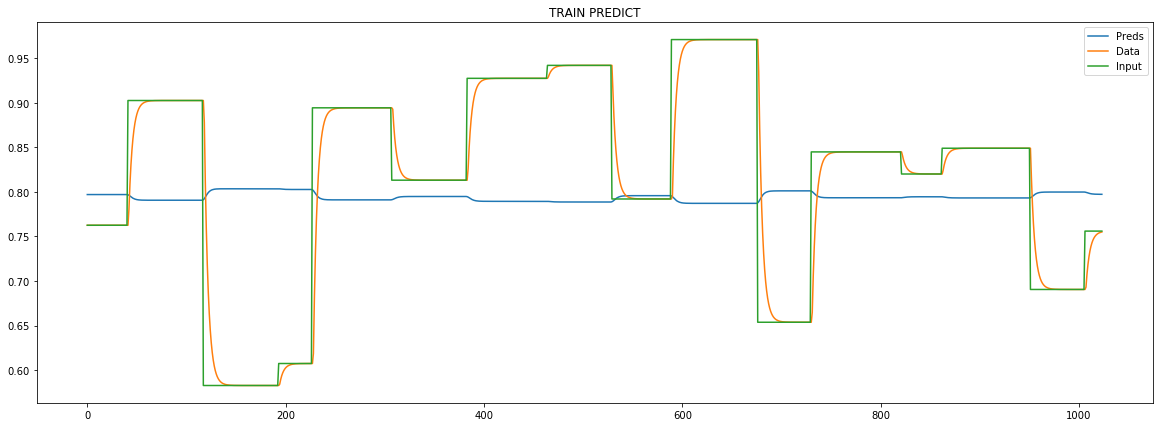

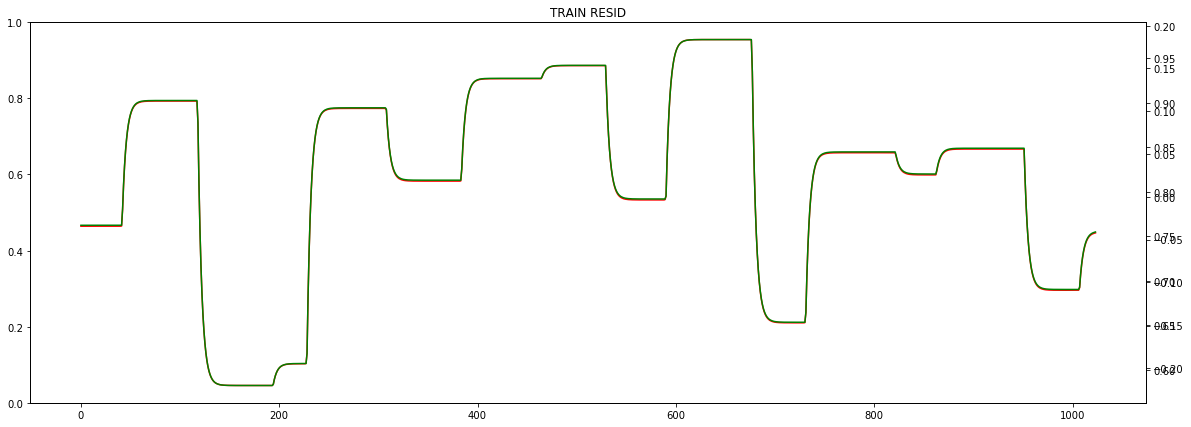

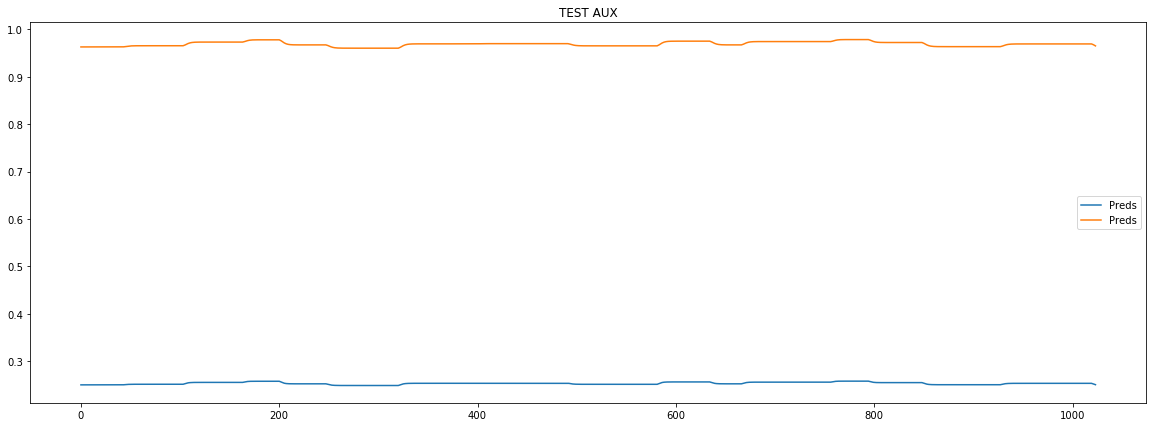

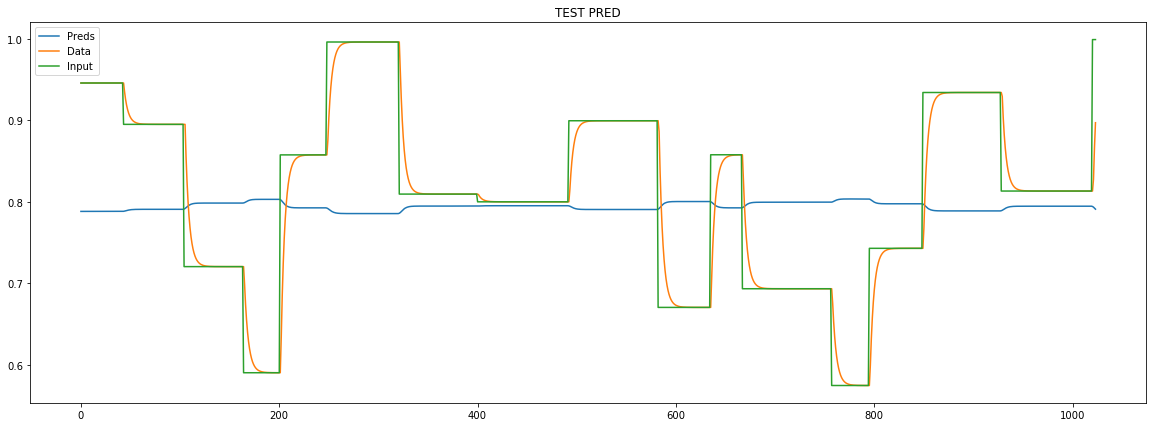

loss rate [0.026317580023352383]
Epoch [27] 
     train_loss[8311.438192252643] 
     eval_train[8242.271529142314] 
     eval_test[9384.181616588665]



aux preds: 0.25472959876060486 0.967698872089386
main loss 0.0
aux loss 8198.372774564303
const loss 0.03457598230586602
combined loss 8198.40735054661 


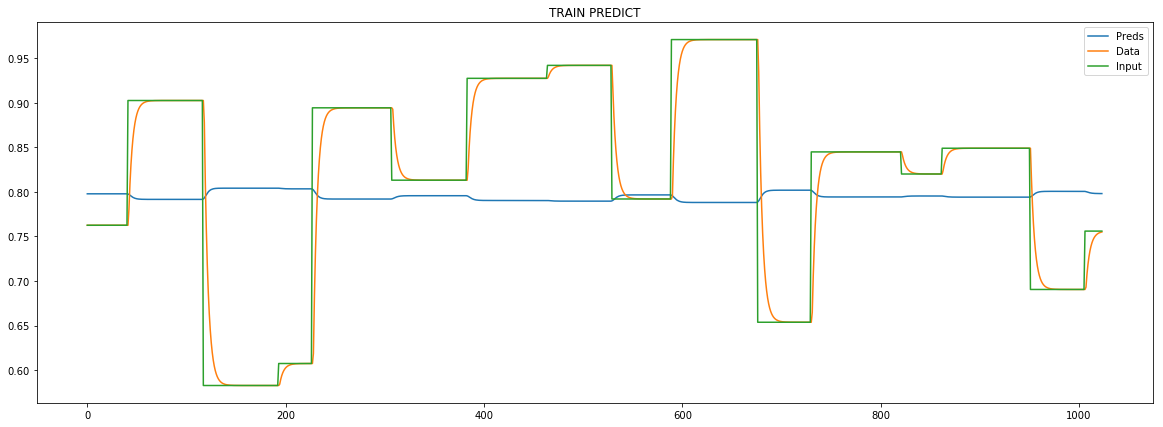

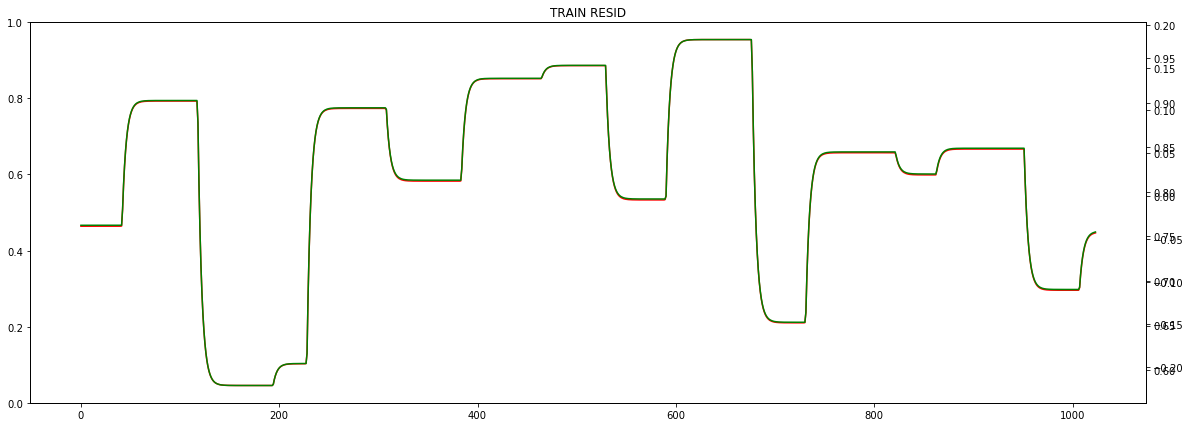

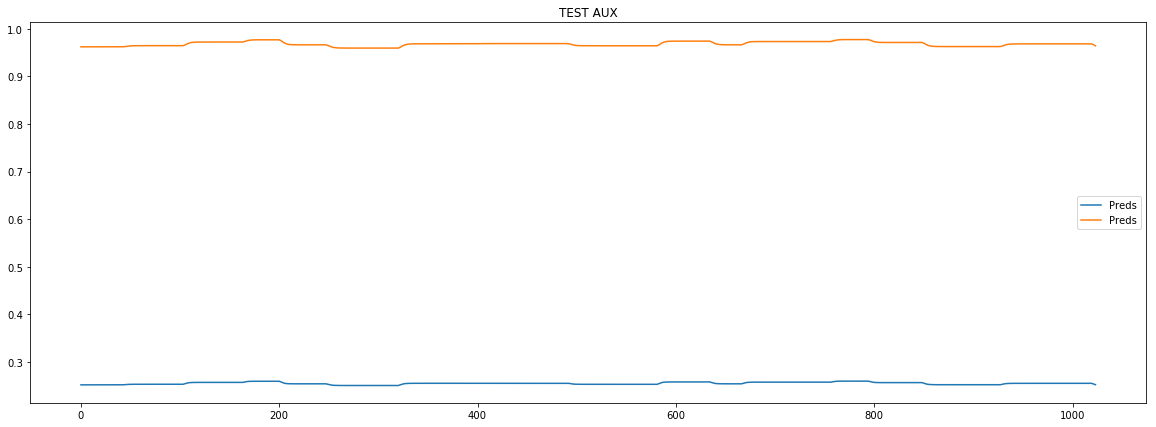

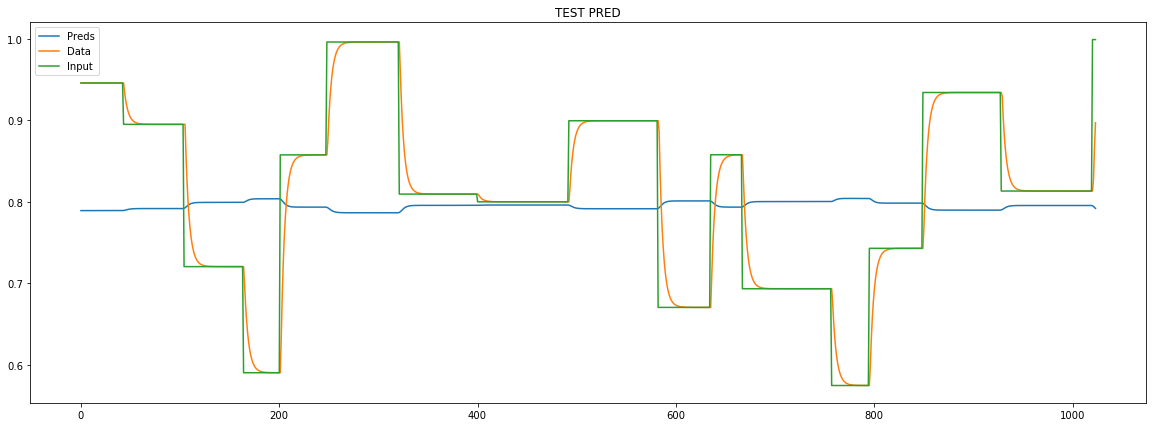

loss rate [0.027017170995917383]
Epoch [28] 
     train_loss[8198.40735054661] 
     eval_train[8128.361728630458] 
     eval_test[9254.600277976471]



aux preds: 0.2562881410121918 0.9667108058929443
main loss 0.0
aux loss 8083.973313551683
const loss 0.033641372270022445
combined loss 8084.006954923952 


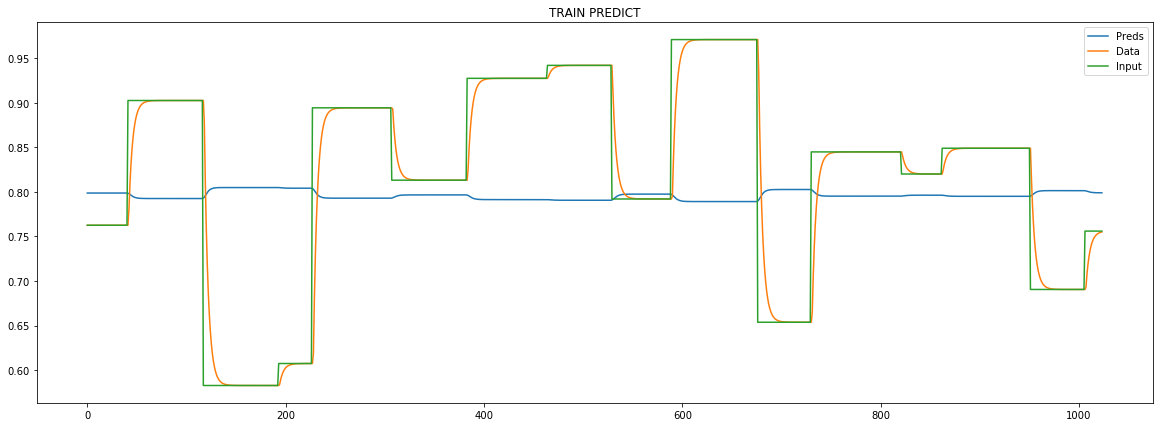

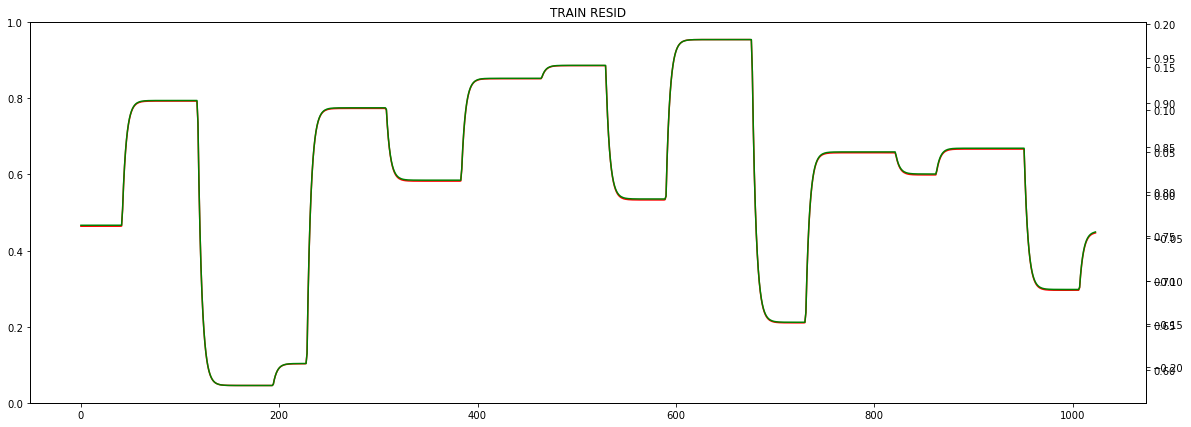

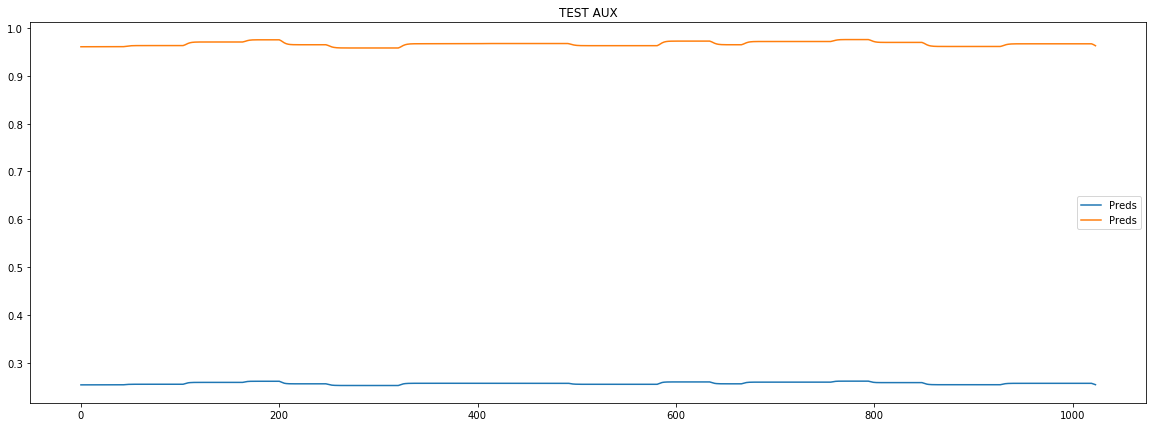

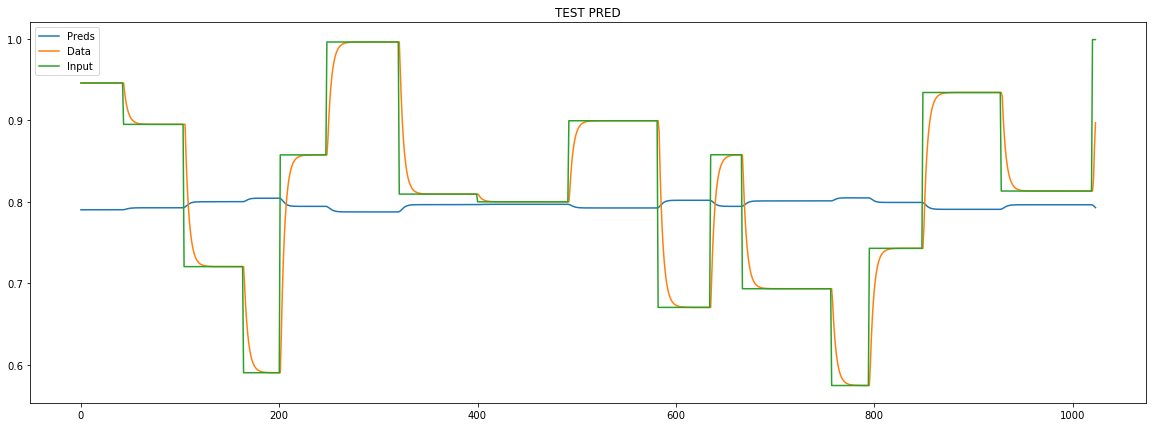

loss rate [0.02772155151182365]
Epoch [29] 
     train_loss[8084.006954923952] 
     eval_train[8013.117286541213] 
     eval_test[9123.506521806628]



aux preds: 0.25789692997932434 0.965700626373291
main loss 0.0
aux loss 7968.302518404447
const loss 0.032697889309089914
combined loss 7968.335216293756 


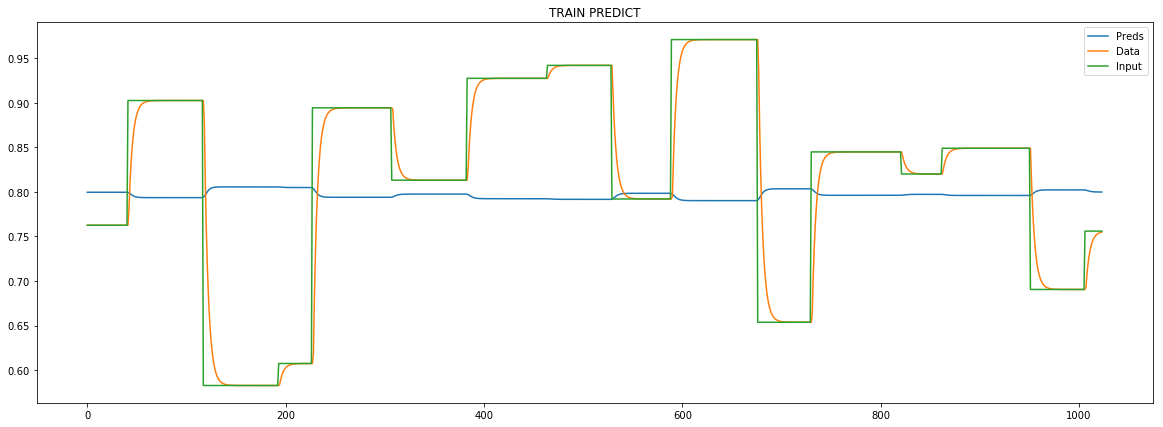

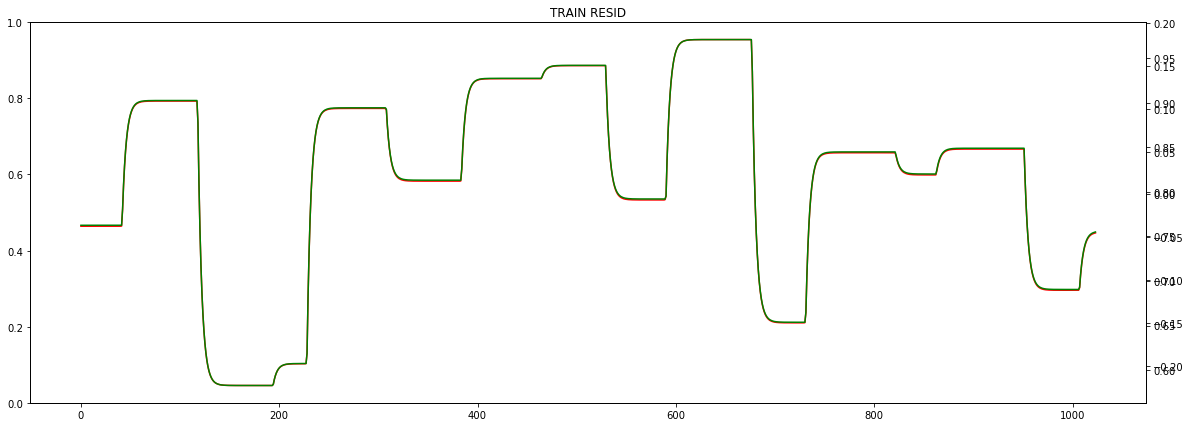

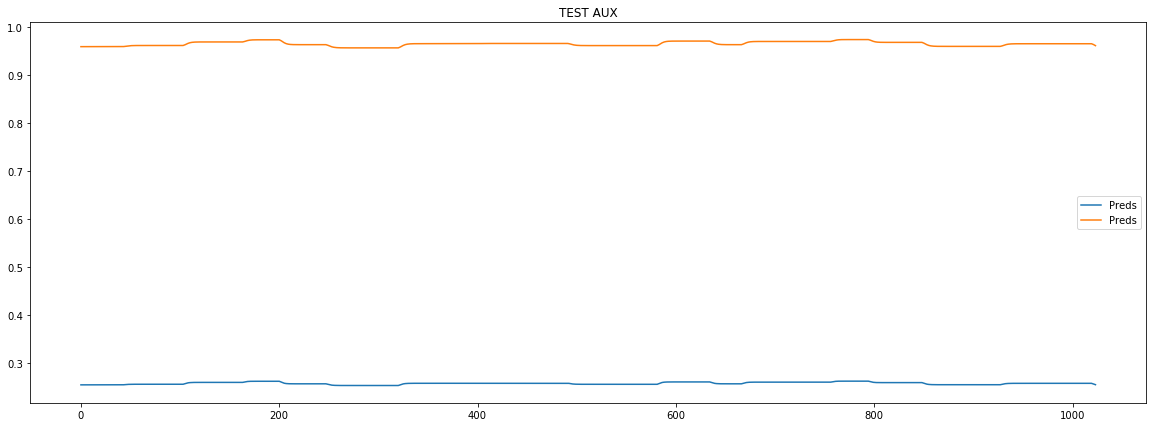

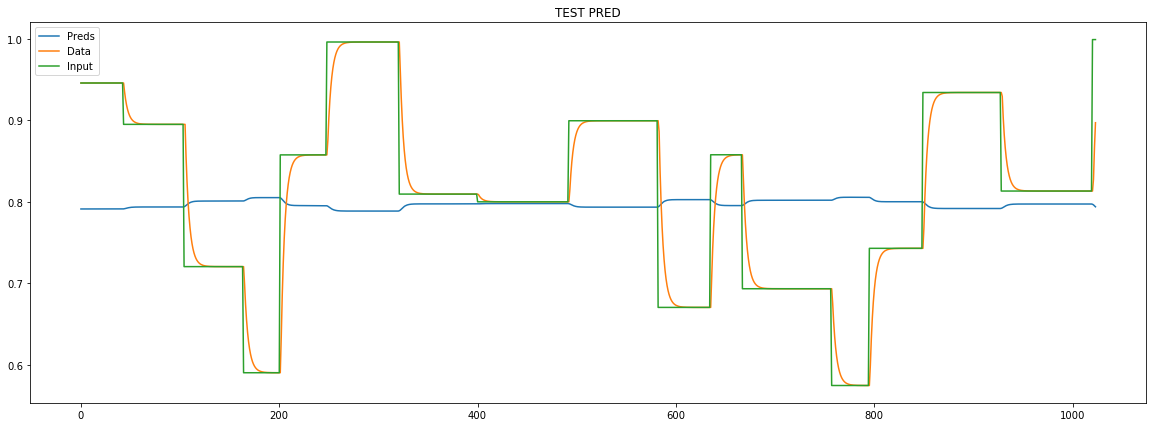

loss rate [0.028422422024277583]
Epoch [30] 
     train_loss[7968.335216293756] 
     eval_train[7896.624066113316] 
     eval_test[8991.072312880646]



aux preds: 0.2595585584640503 0.964654266834259
main loss 0.0
aux loss 7851.419931265024
const loss 0.031746272499171585
combined loss 7851.451677537523 


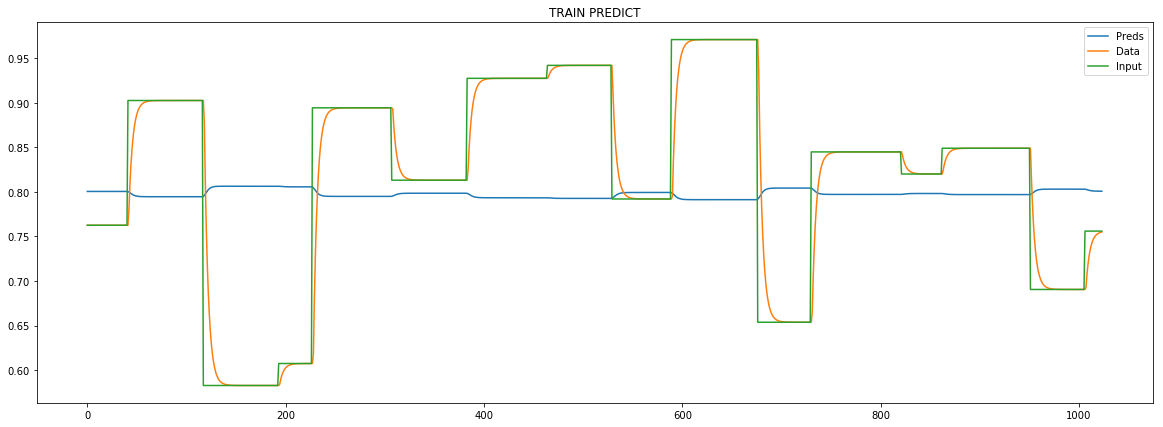

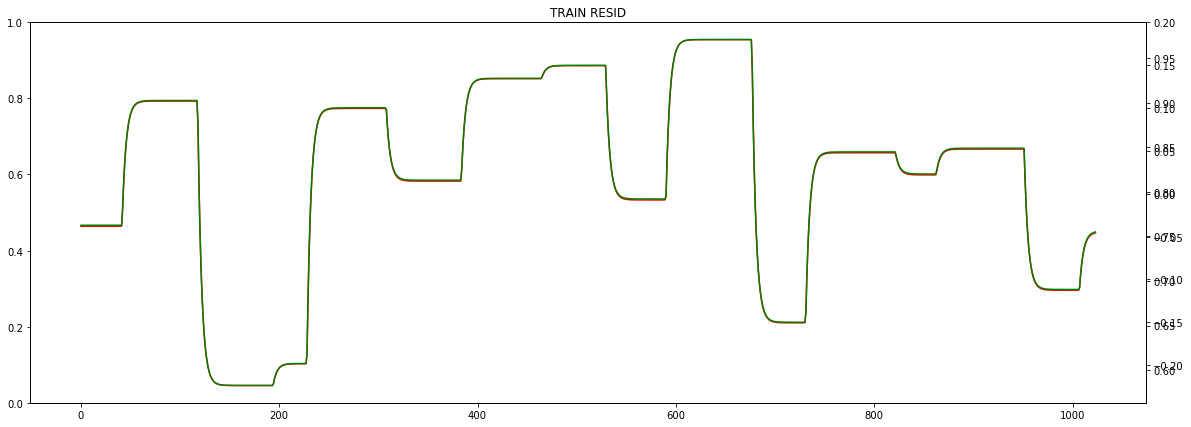

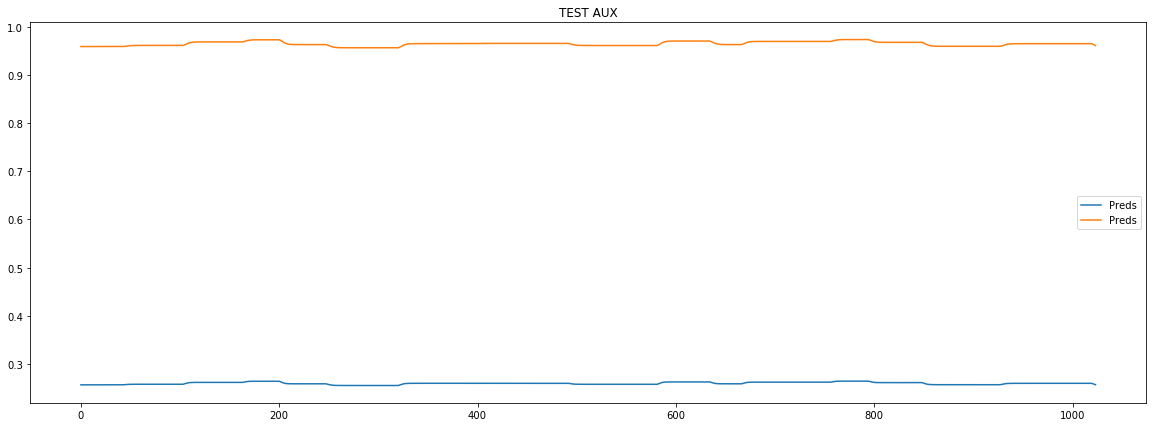

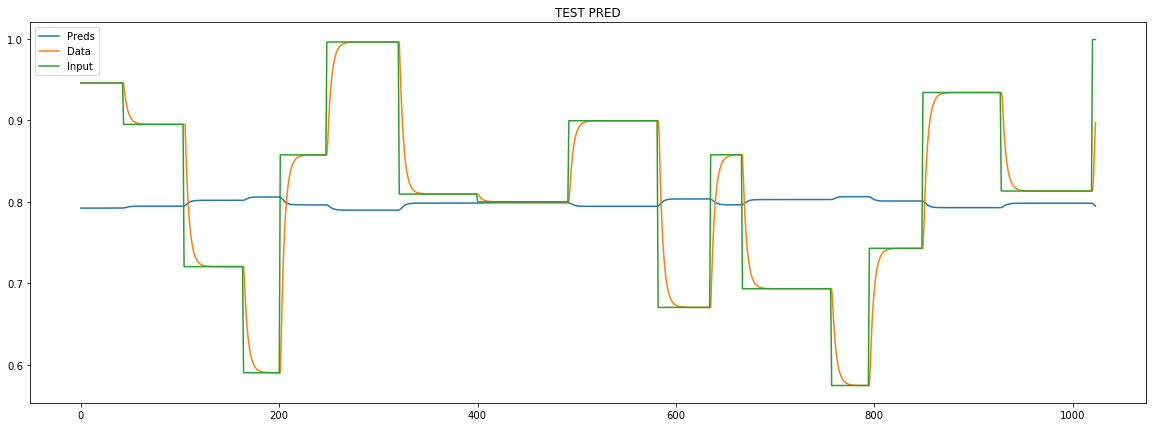

loss rate [0.029136639028317868]
Epoch [31] 
     train_loss[7851.451677537523] 
     eval_train[7778.986344087833] 
     eval_test[8857.244406785561]



aux preds: 0.2612736225128174 0.9635912179946899
main loss 0.0
aux loss 7733.3721923828125
const loss 0.030786899133370474
combined loss 7733.402979281946 


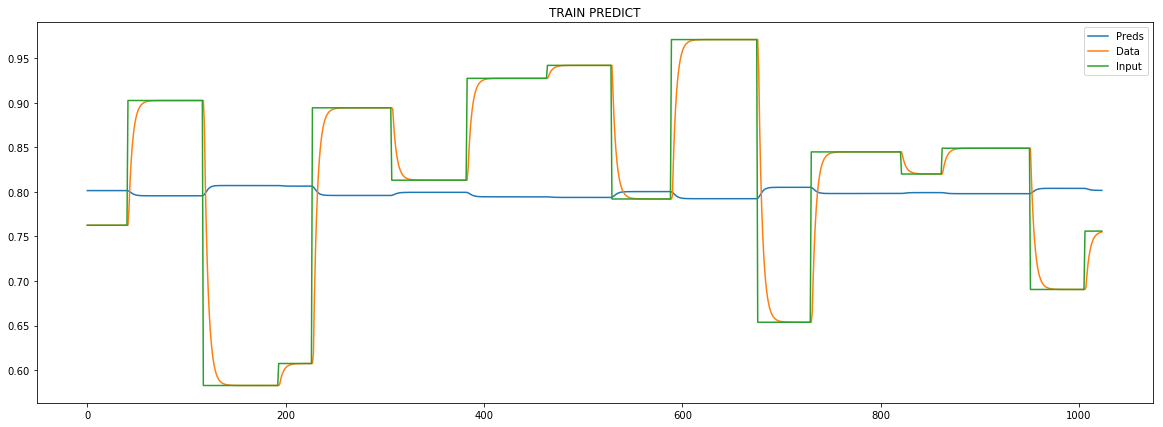

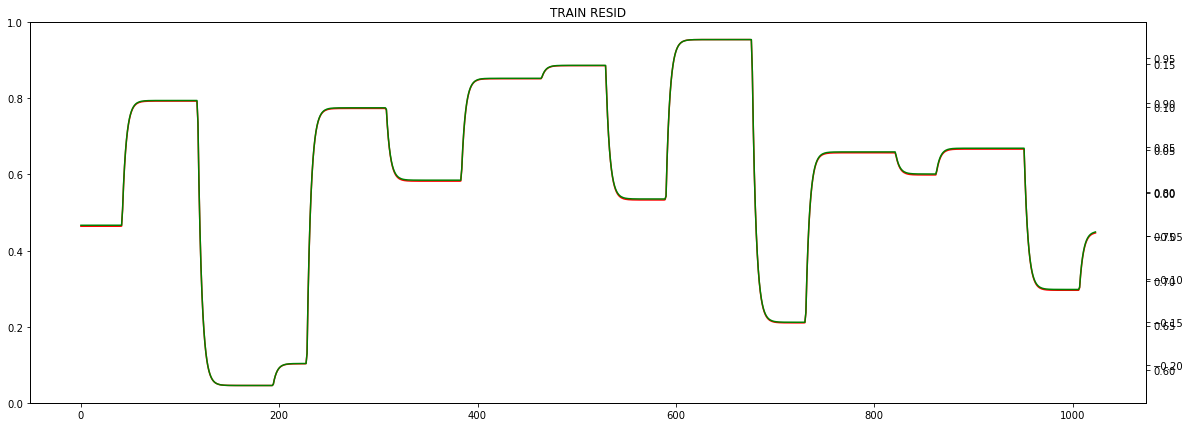

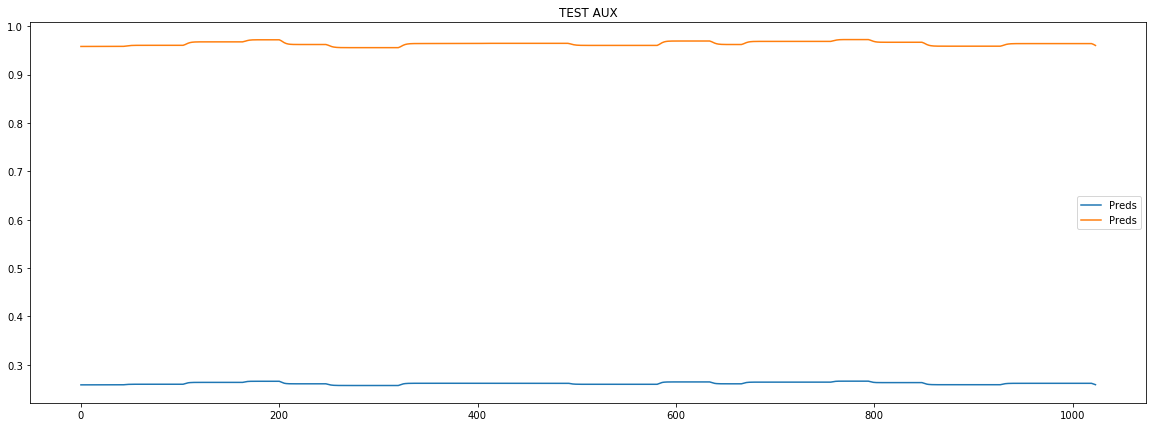

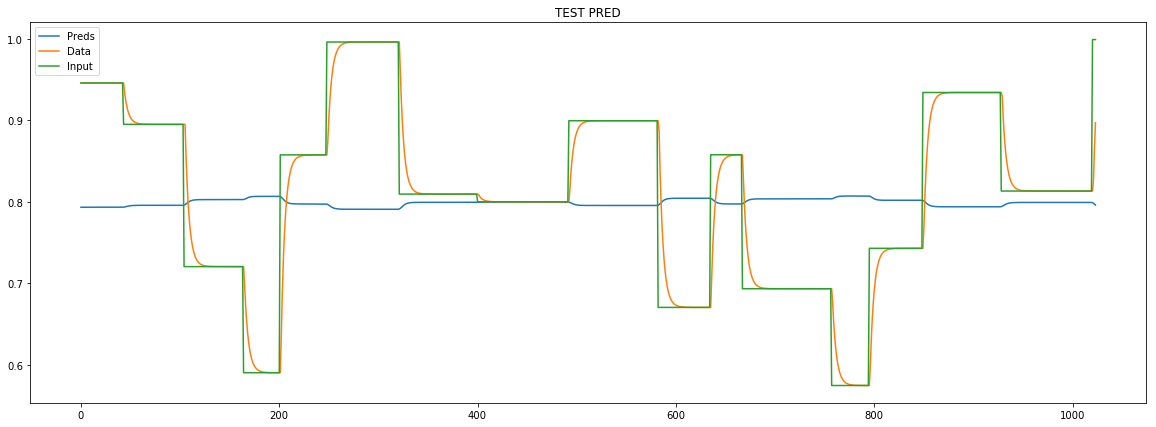

loss rate [0.029858686253606215]
Epoch [32] 
     train_loss[7733.402979281946] 
     eval_train[7660.2258306916165] 
     eval_test[8722.160011205991]



aux preds: 0.26304250955581665 0.9624854922294617
main loss 0.0
aux loss 7614.280592698317
const loss 0.02982060070364521
combined loss 7614.310413299021 


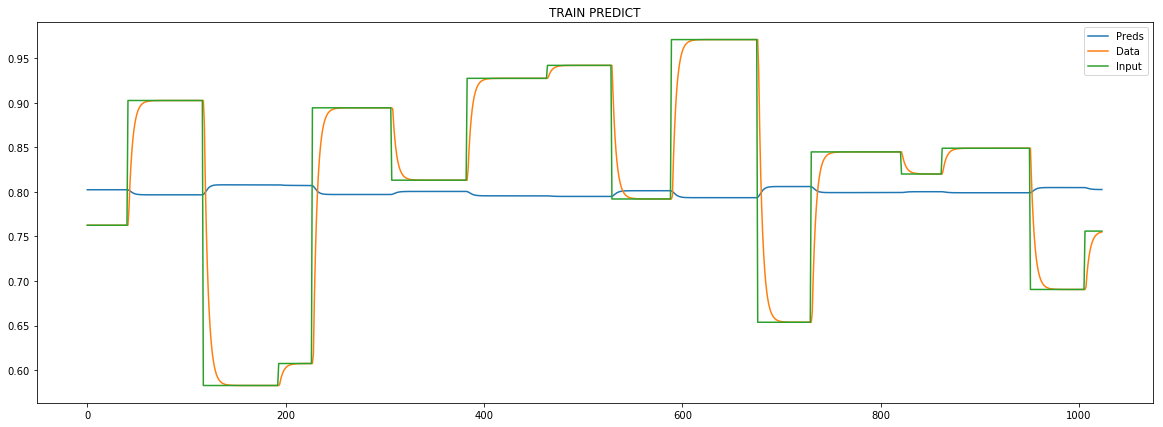

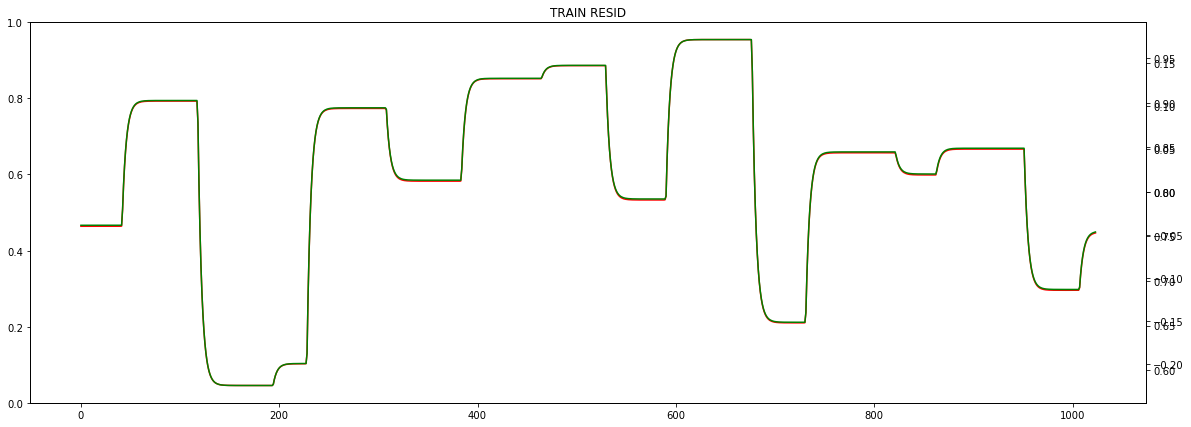

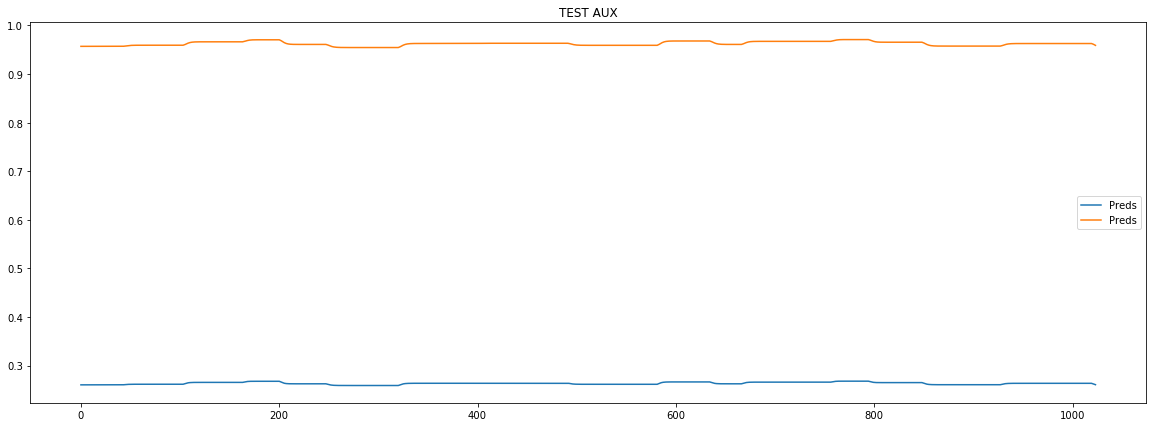

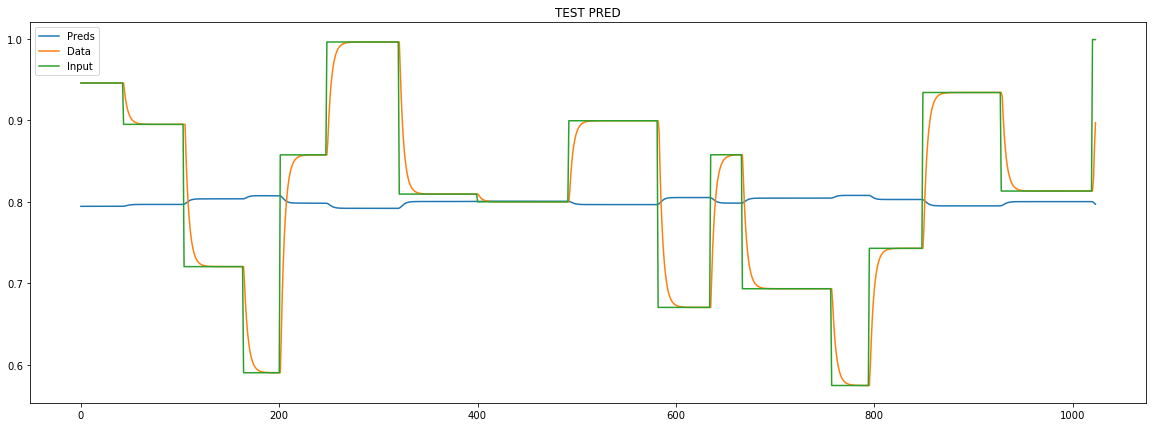

loss rate [0.030580074649590783]
Epoch [33] 
     train_loss[7614.310413299021] 
     eval_train[7540.46574271764] 
     eval_test[8585.983189655639]



aux preds: 0.2648686468601227 0.9613574743270874
main loss 0.0
aux loss 7494.196936974158
const loss 0.028847977787686083
combined loss 7494.225784951946 


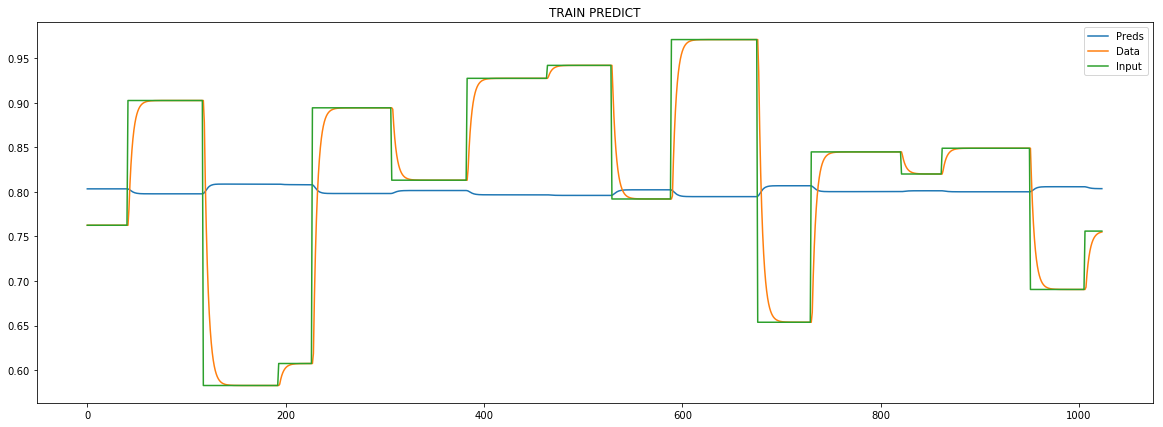

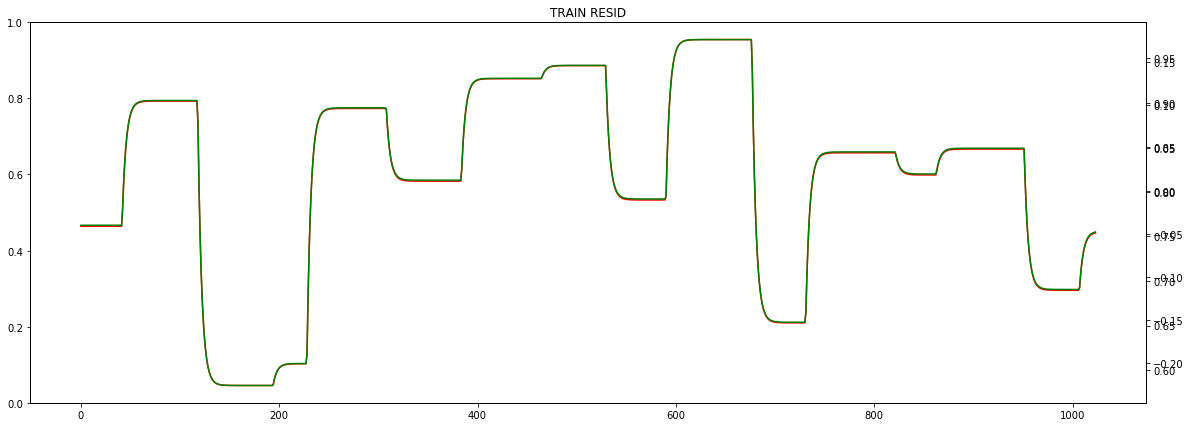

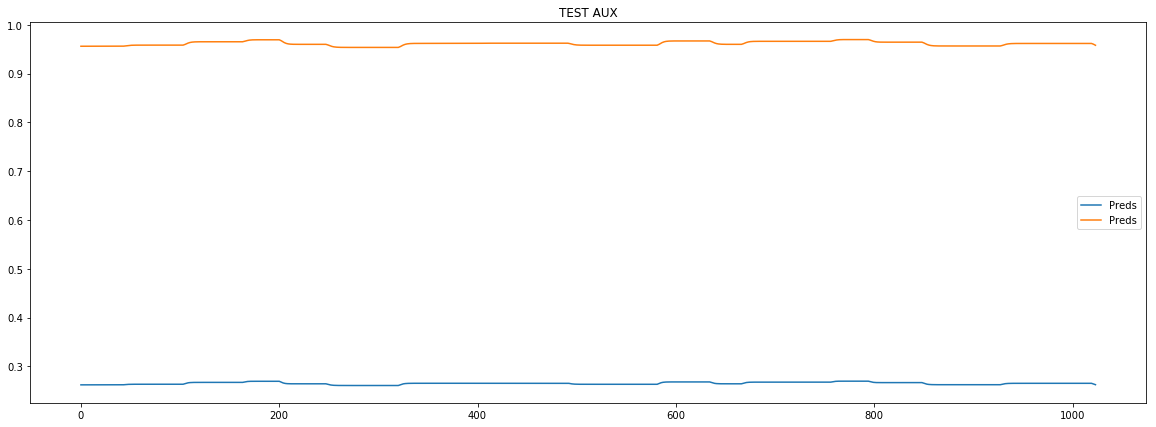

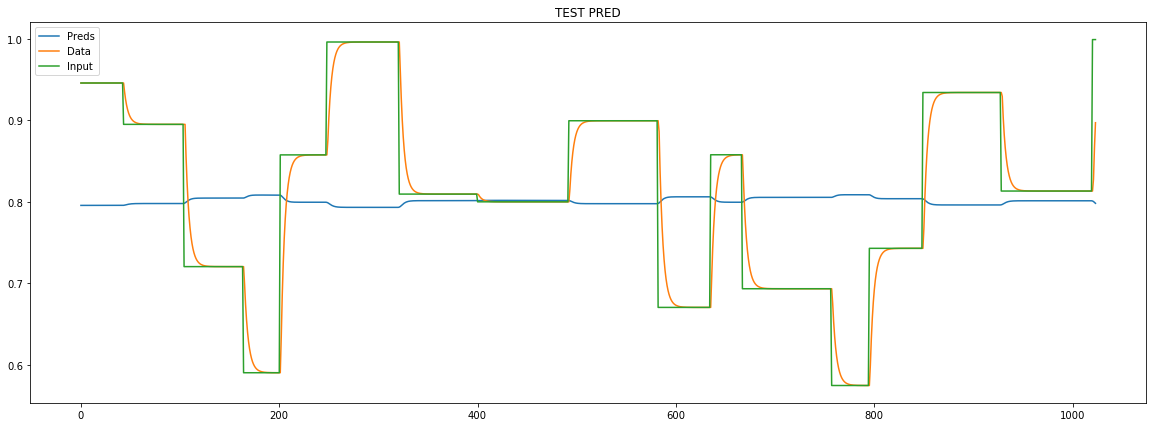

loss rate [0.031316828913459105]
Epoch [34] 
     train_loss[7494.225784951946] 
     eval_train[7419.746082086349] 
     eval_test[8448.656880161387]



aux preds: 0.26675286889076233 0.9601967334747314
main loss 0.0
aux loss 7373.13002366286
const loss 0.027869540803994123
combined loss 7373.157893203665 


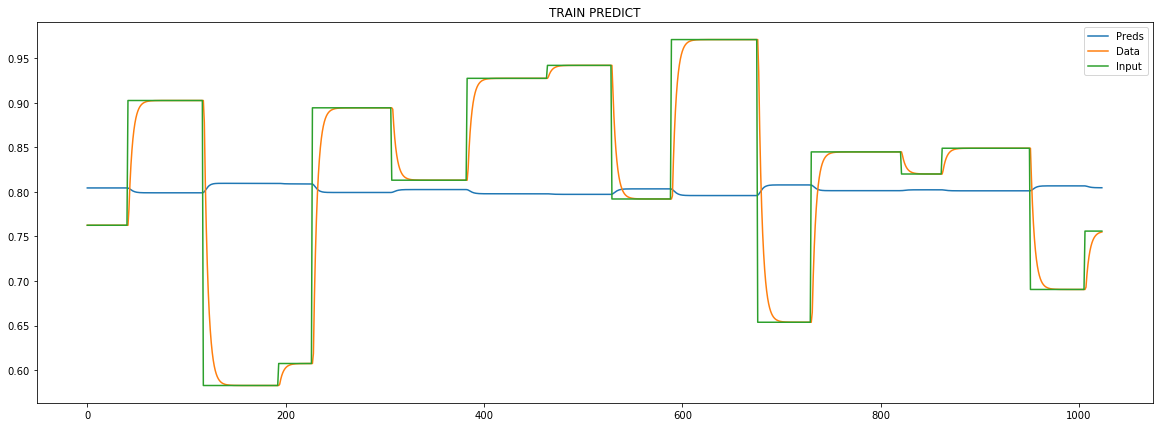

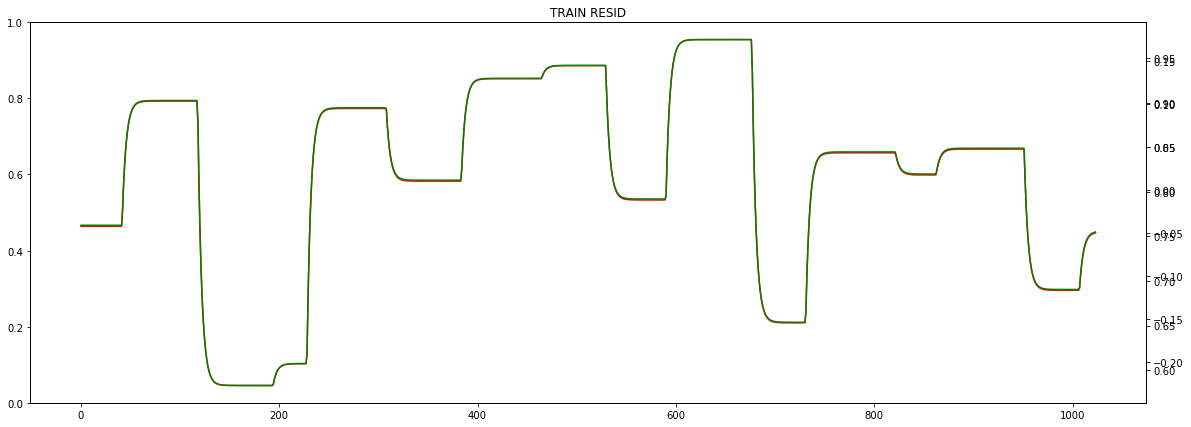

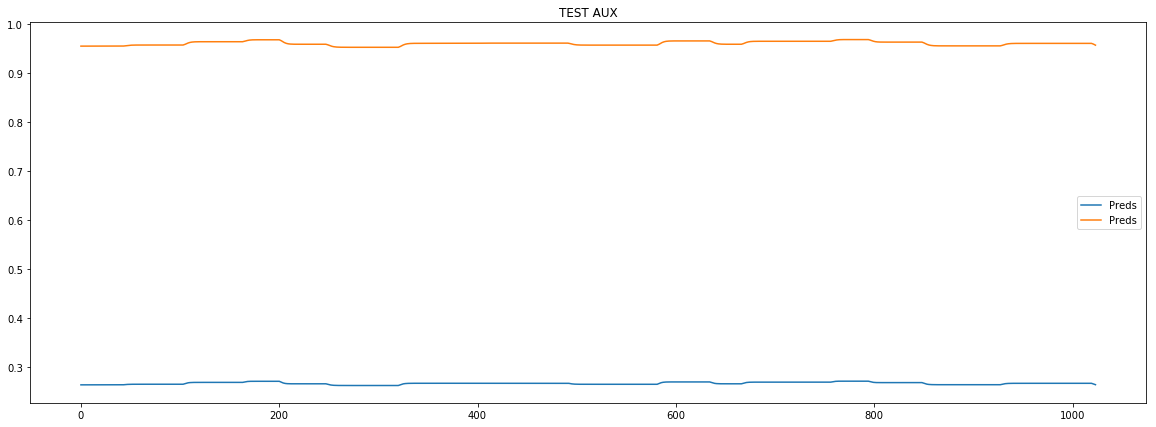

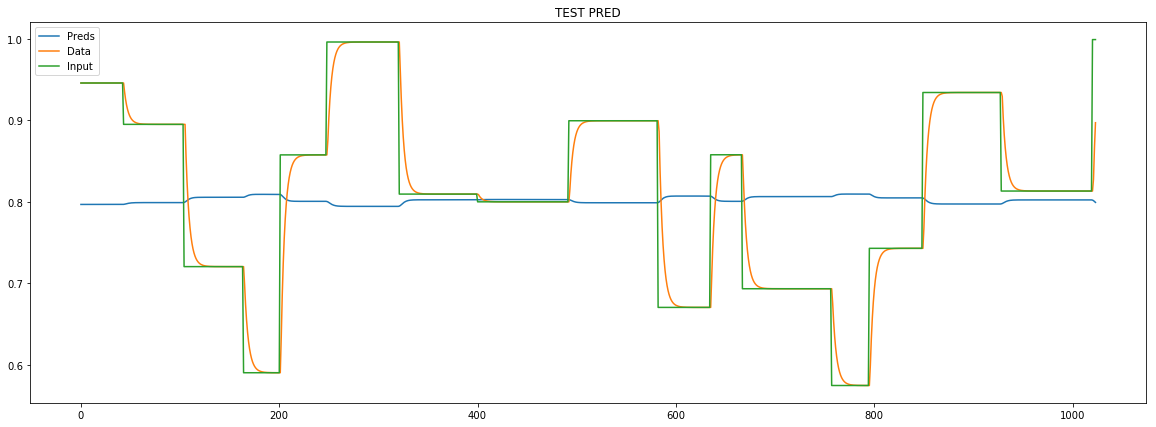

loss rate [0.03206468810898977]
Epoch [35] 
     train_loss[7373.157893203665] 
     eval_train[7298.127217929452] 
     eval_test[8310.305439913138]



aux preds: 0.2686983346939087 0.9590026140213013
main loss 0.0
aux loss 7251.251615084135
const loss 0.026885958316807564
combined loss 7251.278501042451 


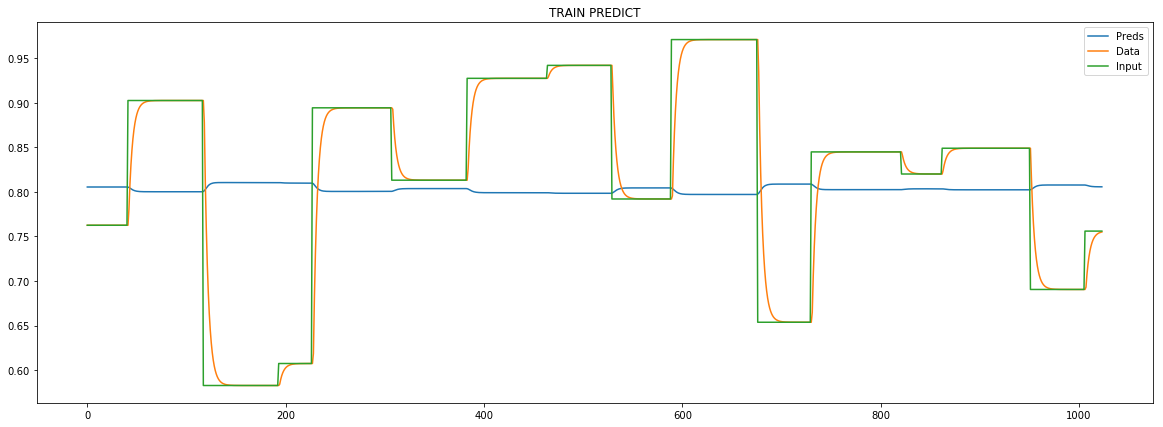

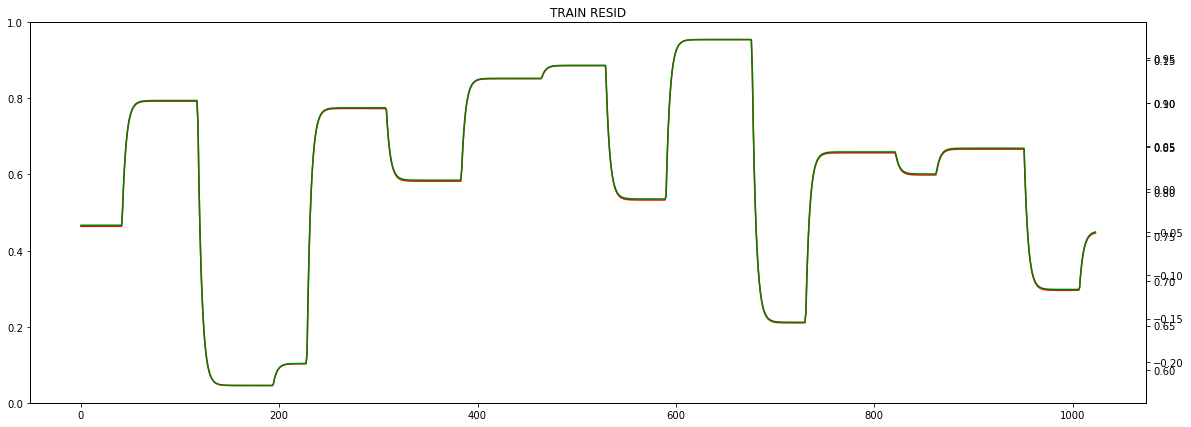

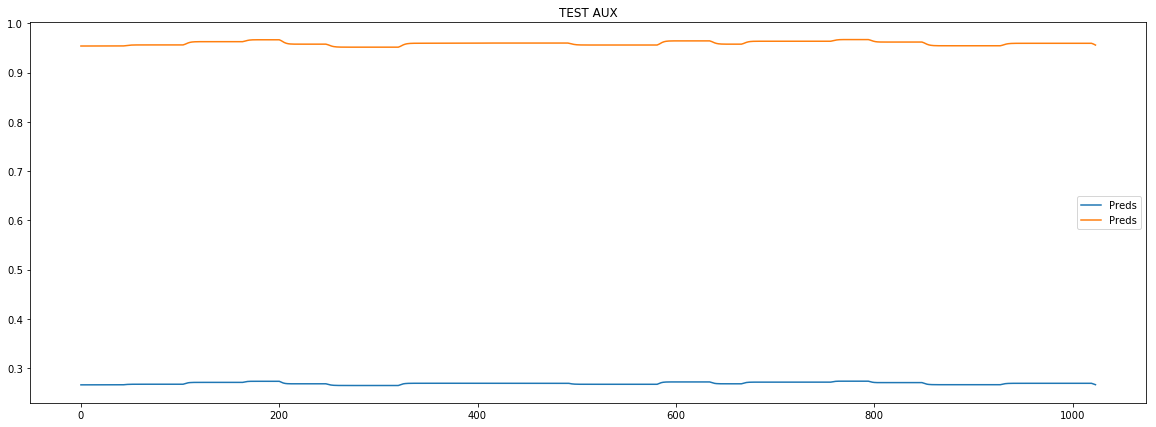

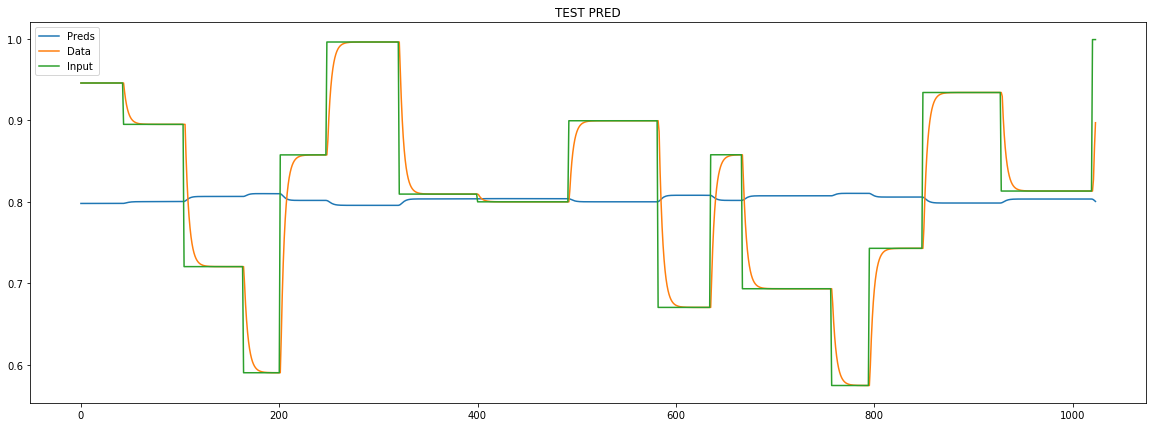

loss rate [0.03281968513390887]
Epoch [36] 
     train_loss[7251.278501042451] 
     eval_train[7175.697154187024] 
     eval_test[8171.044126121581]



aux preds: 0.2707047760486603 0.9577802419662476
main loss 0.0
aux loss 7128.577880859375
const loss 0.025897849906379215
combined loss 7128.603778709281 


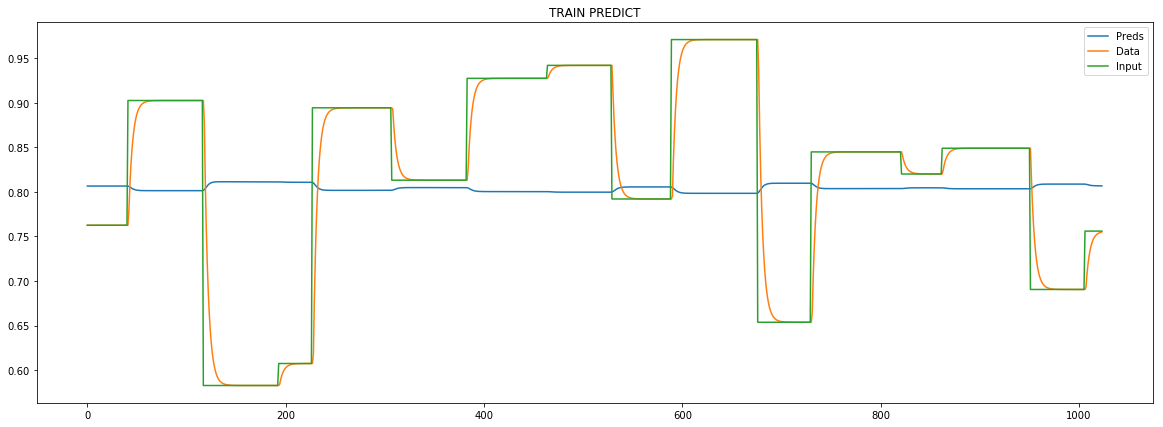

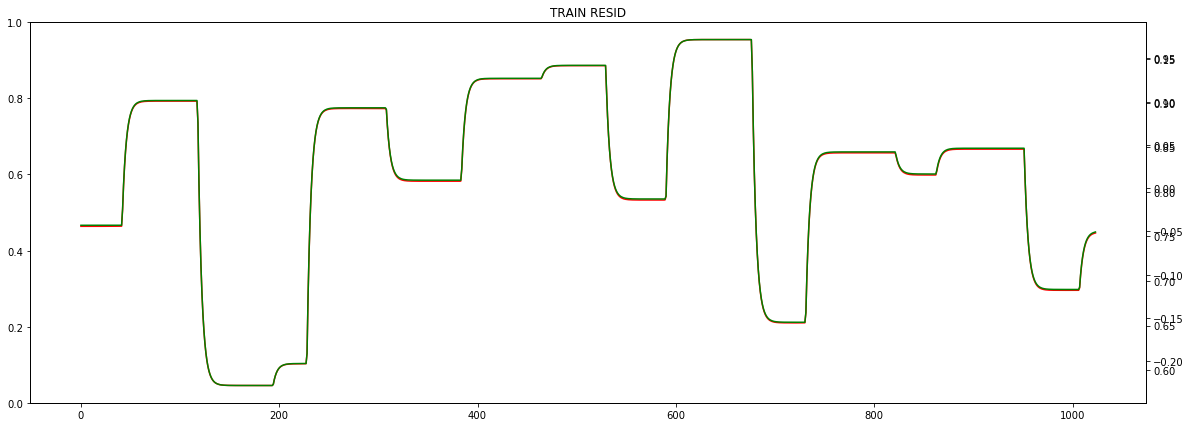

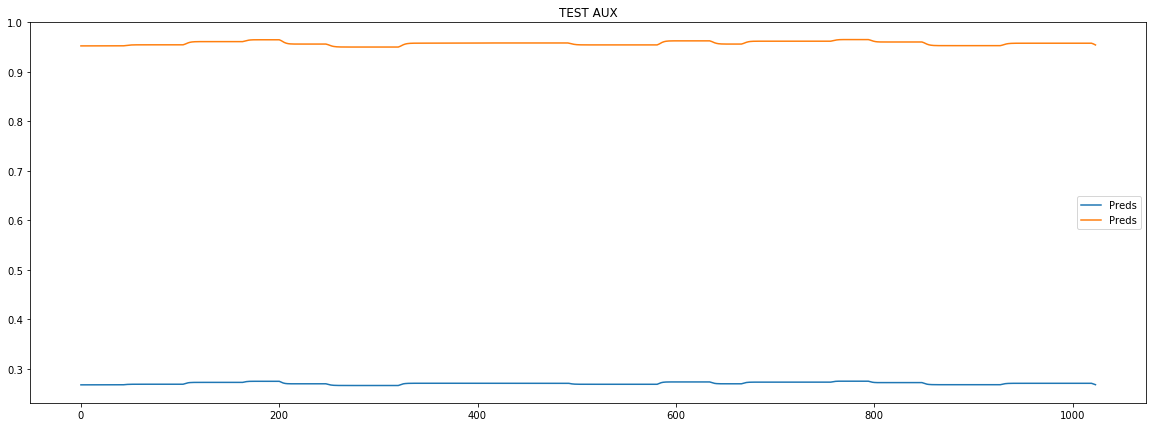

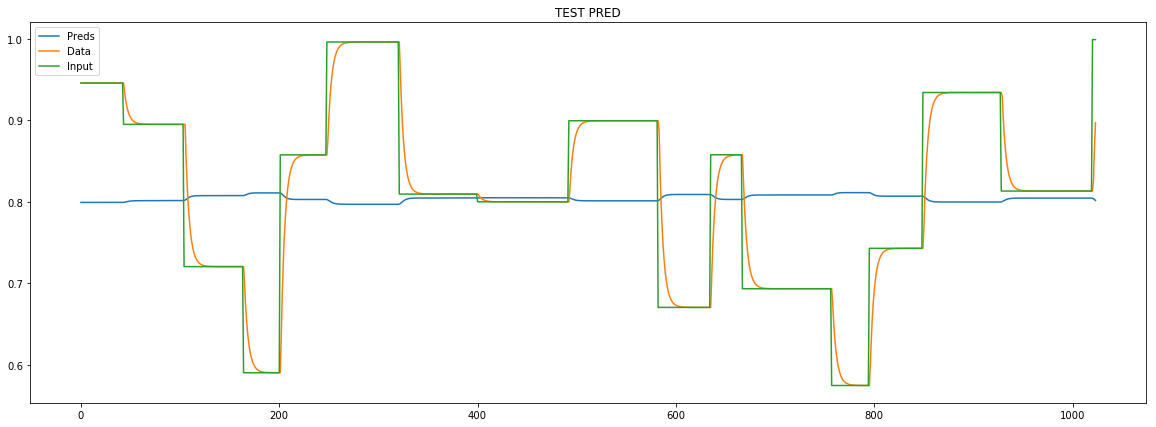

loss rate [0.033577611256250695]
Epoch [37] 
     train_loss[7128.603778709281] 
     eval_train[7052.518443043667] 
     eval_test[8030.972127043303]



aux preds: 0.2727758288383484 0.9565237164497375
main loss 0.0
aux loss 7005.129267765926
const loss 0.024905777500512507
combined loss 7005.154173543427 


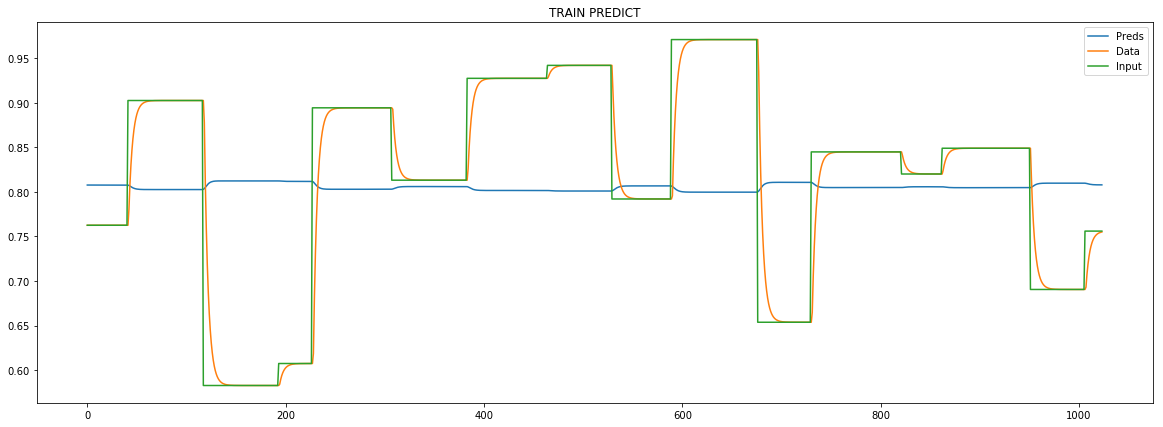

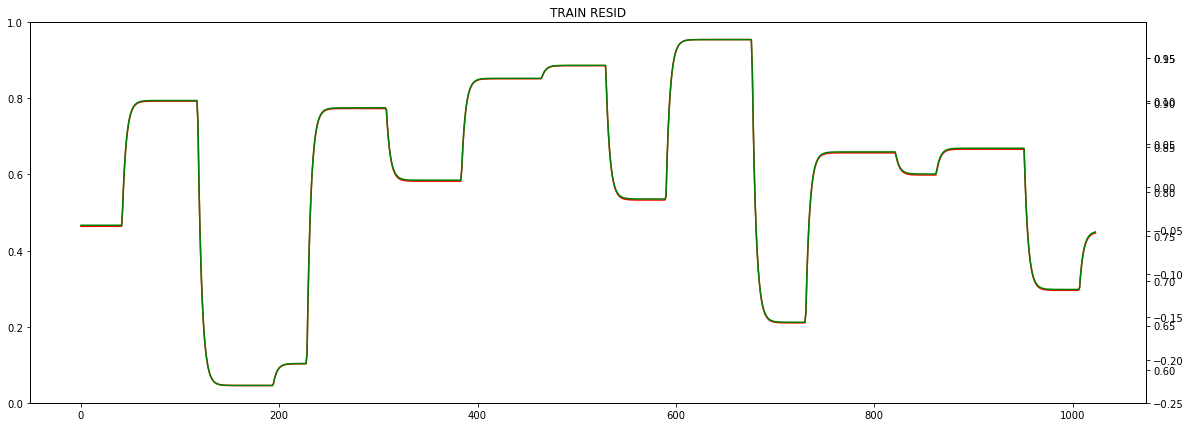

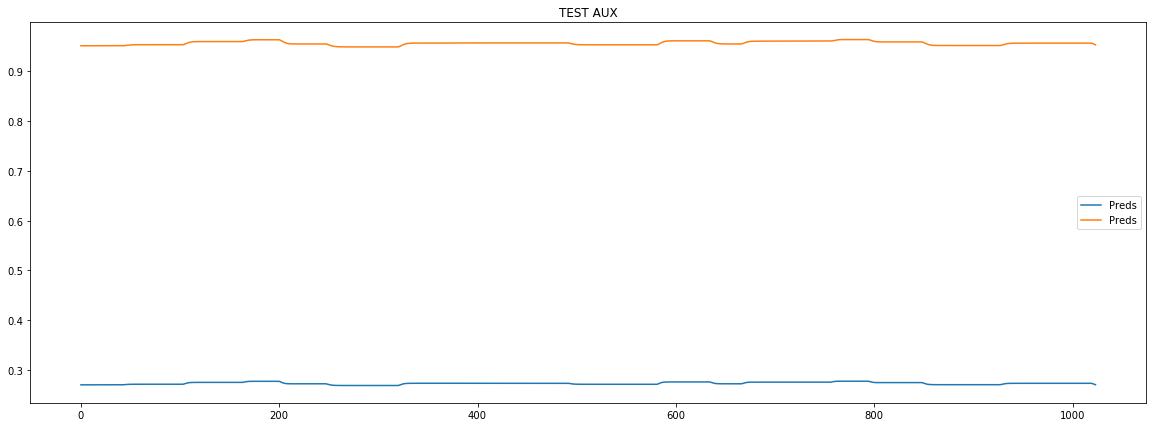

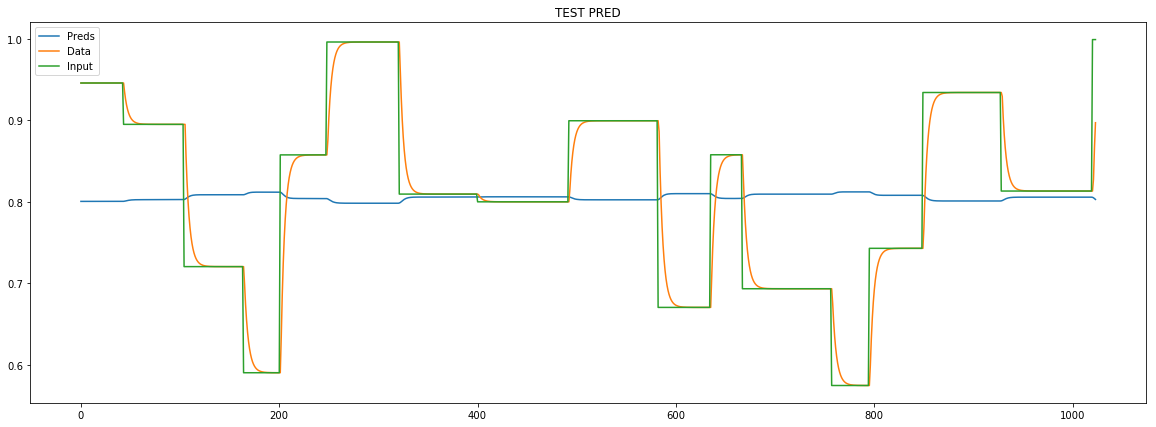

loss rate [0.034363564629049104]
Epoch [38] 
     train_loss[7005.154173543427] 
     eval_train[6928.6296781897545] 
     eval_test[7889.996980789964]



aux preds: 0.2749137878417969 0.9552299976348877
main loss 0.0
aux loss 6881.029052734375
const loss 0.023910418242359392
combined loss 6881.052963152617 


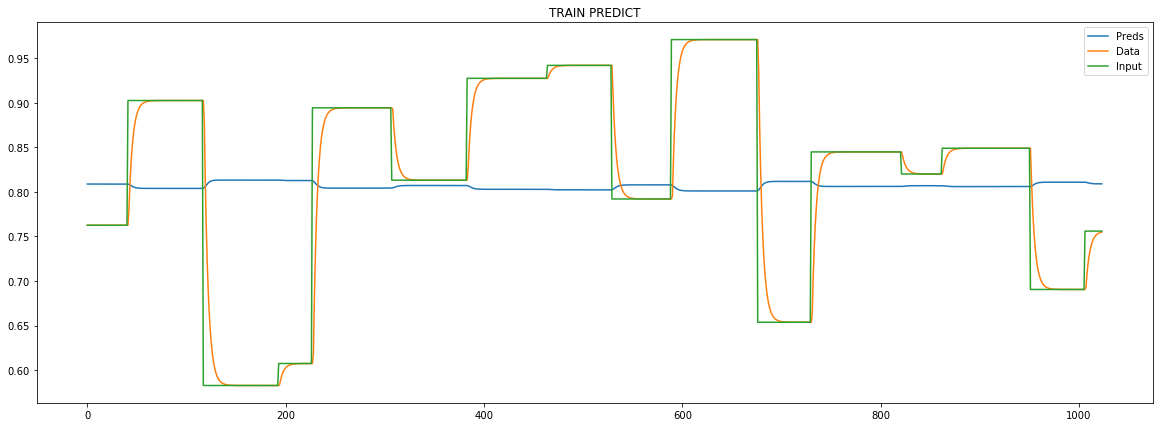

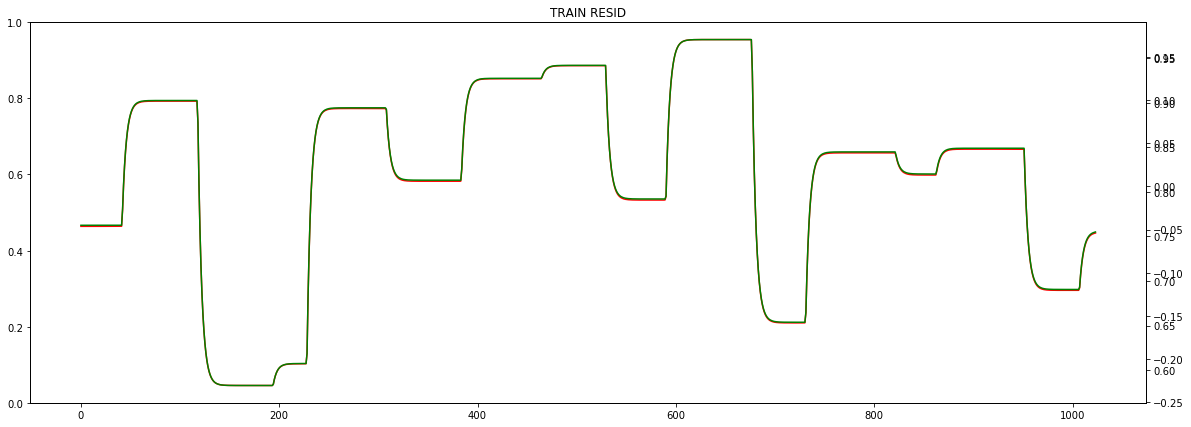

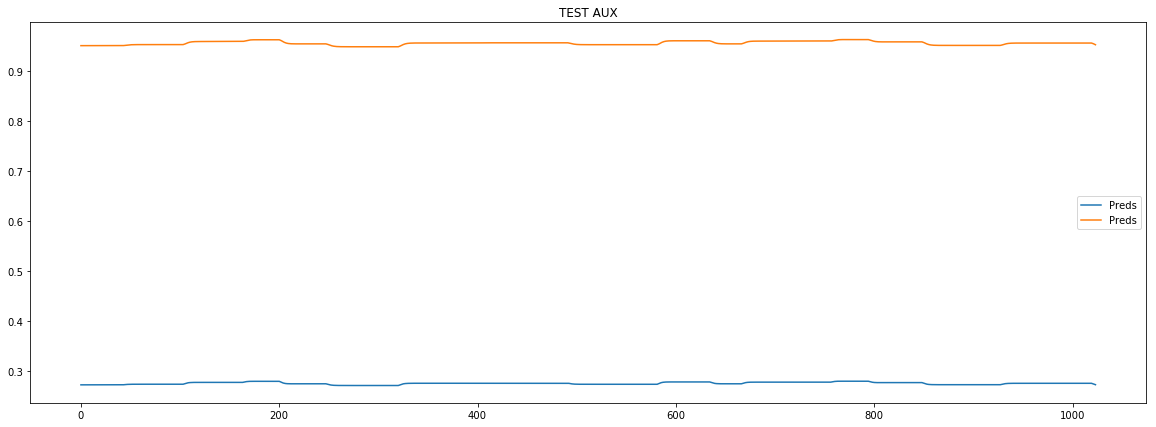

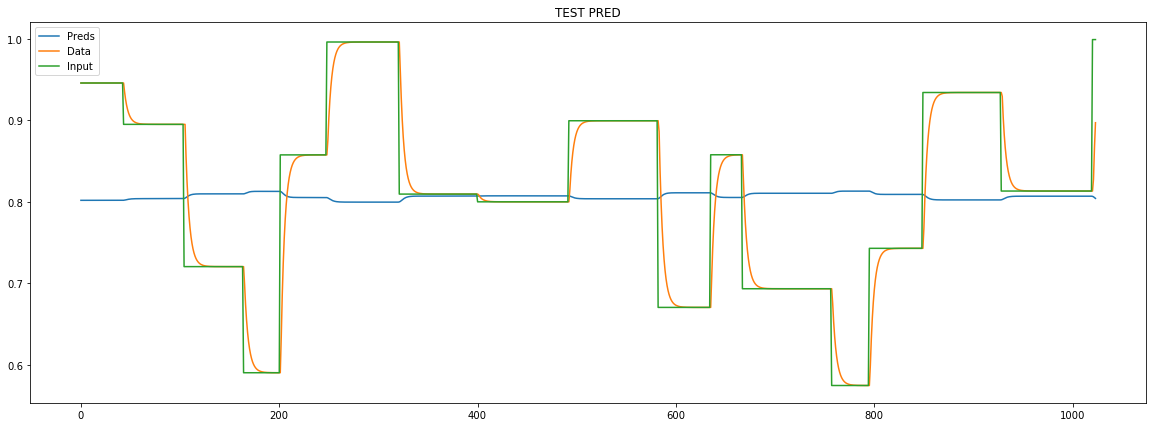

loss rate [0.03515632600737906]
Epoch [39] 
     train_loss[6881.052963152617] 
     eval_train[6804.092252181502] 
     eval_test[7748.34218750928]



aux preds: 0.27711978554725647 0.9539053440093994
main loss 0.0
aux loss 6756.313504732572
const loss 0.02291237346183222
combined loss 6756.336417106034 


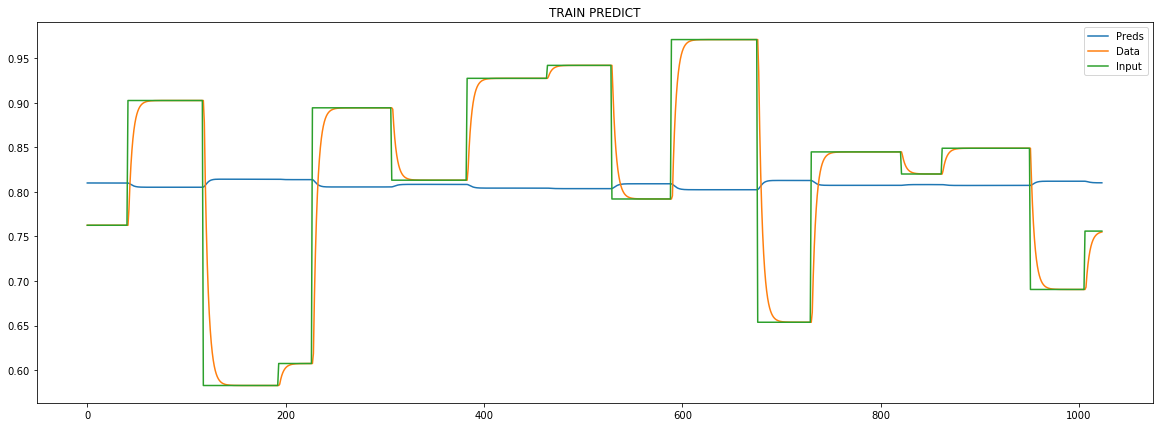

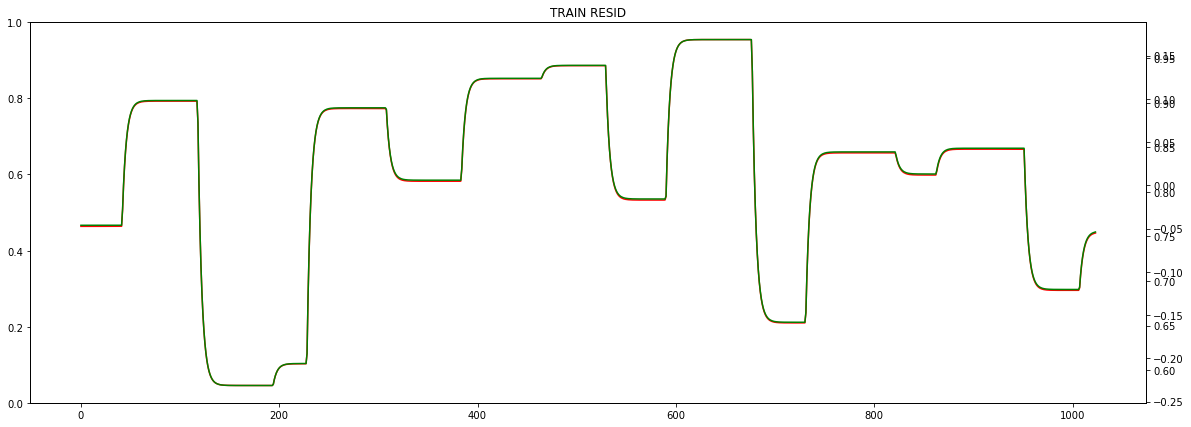

KeyboardInterrupt: 

In [24]:
logging.info("Training process STARTED")

model.hidden = model.init_hidden()
# todo try init hidden each batch
    

for t in range(num_epochs):
            
    
    batch_local_hist = hist["train"]["batches"]
    long_term_hist = hist["train"]["epochs"]
    
    for i, data in enumerate(tqdm(train_dl)):
        y_pred = batch_iteration(
            iter_index=i,
            model=model,
            optimizer=optimizer,
            batch_data=data,
            backprop=True,
            hist_part=batch_local_hist
        )
        
    hist['mean_params_sample']['1'][t] = y_pred[:, 1].mean()
    hist['mean_params_sample']['2'][t] = y_pred[:, 2].mean()
    
    print(f"aux preds: {hist['mean_params_sample']['1'][t]} {hist['mean_params_sample']['2'][t]}")
    
    mean_losses = update_long_term_hist(batches_hist=batch_local_hist,
                                                            long_term_hist=long_term_hist)
    mean_main, mean_aux, mean_const = mean_losses
    # TODO add w8 decay
    print(f"main loss {mean_main}")
    print(f"aux loss {mean_aux}")
    print(f"const loss {mean_const}")
    print(f"combined loss {mean_main + mean_aux + mean_const} ")
    
    # VISUALISE TRAINING PROGRESS
    x_batch, y_batch, indexes = data
    plot_shared_scale([
        (y_pred[:, 0].detach().numpy(),"Preds" ),
         (y_batch[:, 0].detach().numpy(), "Data"),
         (x_batch[-1].detach().numpy(), "Input")
        ],
        title="TRAIN PREDICT")
          
    residuals = y_batch[:, 0] - y_pred[:, 0]
    plot_multiscale([
        (residuals.detach().numpy(), "Red"),
        (y_batch[:, 0].detach().numpy(), "Green")
    ],
        title="TRAIN RESID"
    ) 
    # /VISUALISE TRAINING PROGRESS

    # EVAL
    with torch.no_grad():
          
          model = model.eval()
          
          for i, data in enumerate(tqdm(train_dl)):
              batch_local_hist = hist['eval_train']['batches']
              long_term_hist=hist["eval_train"]["epochs"]
              y_pred = batch_iteration(
                iter_index=i,
                model=model,
                optimizer=optimizer,
                batch_data=data,
                backprop=False,
                hist_part=batch_local_hist
              )
          
          update_long_term_hist(batches_hist=batch_local_hist,
                                long_term_hist=long_term_hist)
          
          
          for i, data in enumerate(tqdm(test_dl)):
              batch_local_hist = hist['eval_test']['batches']
              long_term_hist=hist["eval_test"]["epochs"]
          
              y_pred_test = batch_iteration(
                iter_index=i,
                model=model,
                optimizer=optimizer,
                batch_data=data,
                backprop=False,
                hist_part=batch_local_hist
              )
          
          update_long_term_hist(batches_hist=batch_local_hist,
                                long_term_hist=long_term_hist)
          
          model = model.train()
    # /EVAL
          
    # VISUALISE ITERATION PRED
    x_batch_test, y_batch_test, indexes = data
    plot_shared_scale([
            (y_pred_test[:, 1].detach().numpy(),"Preds" ),
            (y_pred_test[:, 2].detach().numpy(),"Preds" ),
    ],
        title = 'TEST AUX'
    )
          
    plot_shared_scale([
            (y_pred_test[:, 0].detach().numpy(),"Preds" ),
             (y_batch_test[:, 0].detach().numpy(), "Data"),
             (x_batch_test[-1].detach().numpy(), "Input")
    ],
        title = 'TEST PRED'
    )
    # /VISUALISE ITERATION PRED
    
    visualise_resid = False
    if visualise_resid:
        residuals = y_batch_test[:, 0] - y_pred_test[:, 0]
        plot_multiscale(
                [
                 (residuals.detach().numpy(), "Red"), 
                 (y_batch_test[:, 0].detach().numpy(),"Green")
                ],
            title = 'TEST RESID'
        )
    
    
    # UPDATE LR
    val_loss = slice_loss_sum(hist['eval_test']['epochs'], t)
    scheduler.step(val_loss)
    hist['weights_sum'][t] = torch.as_tensor([p.sum() for p in model.parameters(recurse=True)]).sum().item()
    hist['weights_var'][t] = torch.as_tensor([p.var() for p in model.parameters(recurse=True)]).sum().item()
    
    hist['lr'][t] = scheduler.optimizer.param_groups[0]['lr']
    if hist['lr'][t] <= 10**p_sched['early_stop_order'] * 1.0001: # 1+eps 
          print("Loss critically low, EARLY STOPPING")
          break
    if t > 3:
          h = hist["eval_test"]["epochs"]
          loss_rate = 1 - slice_loss_sum(h, t) / np.mean([slice_loss_sum(h, k) for k in range(t-3,t)])          
          hist['loss_rate'][t] = loss_rate              
          print(f"loss rate [{loss_rate}]")

    # /UPDATE LR
                       
    # FINAL PROGRESS LOGGING
    msg = "Epoch [{t}] \n \
    train_loss[{train_loss}] \n \
    eval_train[{eval_train}] \n \
    eval_test[{eval_test}]".format(t=t,
                                train_loss=sum([val[t] for val in hist['train']['epochs'].values()]), 
                                eval_train=sum([val[t] for val in hist['eval_train']['epochs'].values()]),
                                eval_test=sum([val[t] for val in hist['eval_test']['epochs'].values()])
                               )
    print(msg)
    logging.info(msg)
                       
    # /FINAL PROGRESS LOGGING

In [ ]:
hist['lr'][t-1] <= 10**p_sched['early_stop_order'] * 1.0001

In [ ]:
hist['lr'][t-1] 

In [25]:
s, e = 0, t

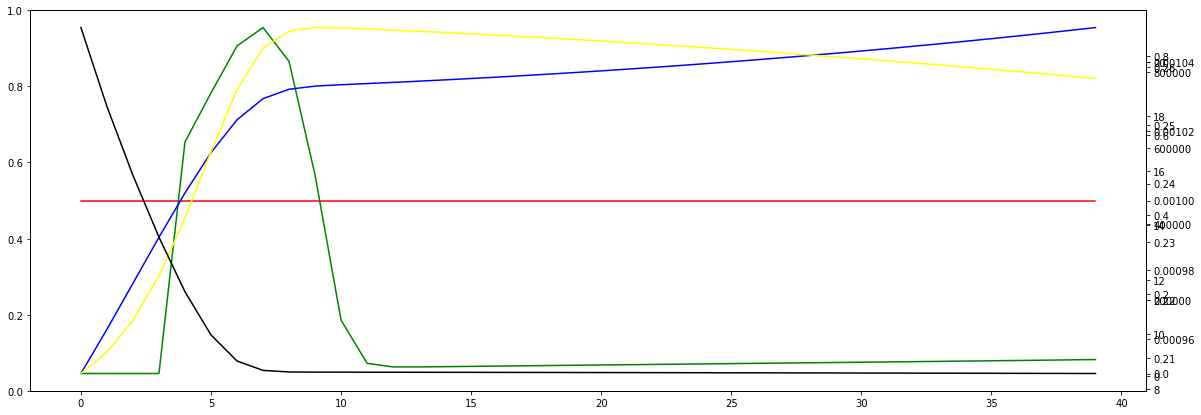

In [26]:
plot_multiscale([
    (hist['lr'][s:e],"Red" ),
    (hist['loss_rate'][s:e], "Green"),
    (hist['weights_sum'][s:e], "Blue"),
    (hist['weights_var'][s:e], "Yellow"),
    (hist['eval_test']["epochs"]['aux'][s:e], "Black")
])

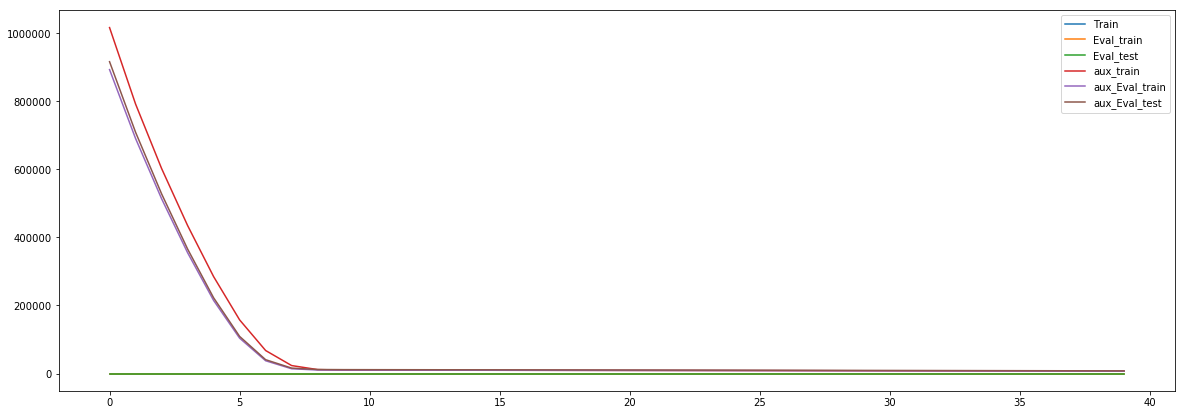

In [27]:
plot_shared_scale([
    (hist['train']["epochs"]['main'][s:e],"Train" ),
    (hist['eval_train']["epochs"]['main'][s:e], "Eval_train"),
    (hist['eval_test']["epochs"]['main'][s:e], "Eval_test"),
    (hist['train']["epochs"]['aux'][s:e], "aux_train"),
    (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
    (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])

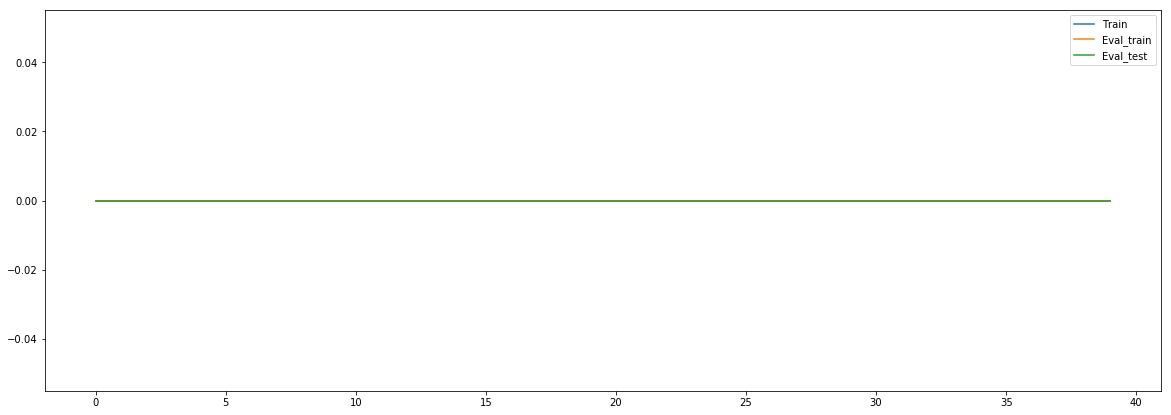

In [28]:
plot_shared_scale([
    (hist['train']["epochs"]['main'][s:e],"Train" ),
    (hist['eval_train']["epochs"]['main'][s:e], "Eval_train"),
    (hist['eval_test']["epochs"]['main'][s:e], "Eval_test"),
#     (hist['train']["epochs"]['aux'][s:e], "aux_train"),
#     (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
#     (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])

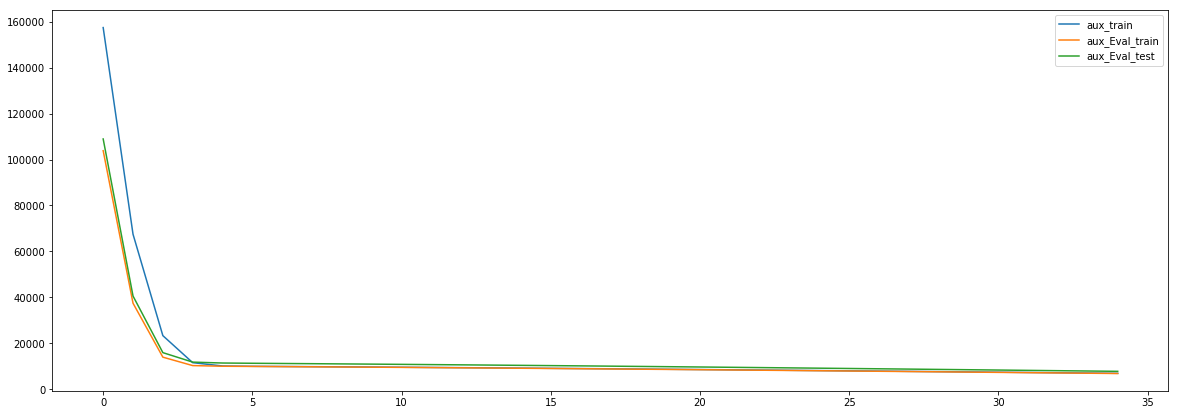

In [31]:
s = 5
plot_shared_scale([
#     (hist['train']["epochs"]['main'][s:e],"Train" ),
#     (hist['eval_train']["epochs"]['main'][s:e], "Eval_train"),
#     (hist['eval_test']["epochs"]['main'][s:e], "Eval_test"),
    (hist['train']["epochs"]['aux'][s:e], "aux_train"),
    (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
    (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])

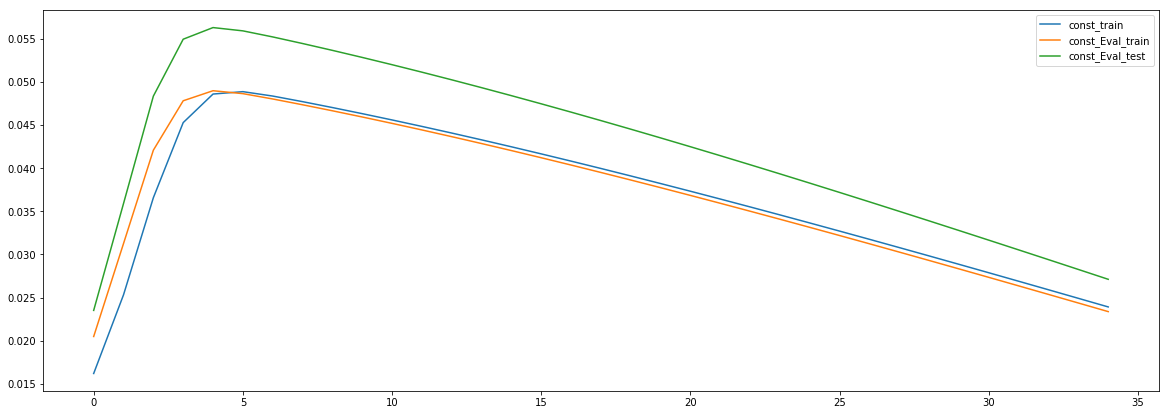

In [32]:
plot_shared_scale([
    (hist['train']["epochs"]['const'][s:e], "const_train"),
    (hist['eval_train']['epochs']['const'][s:e], "const_Eval_train"),
    (hist['eval_test']['epochs']['const'][s:e], "const_Eval_test")
])

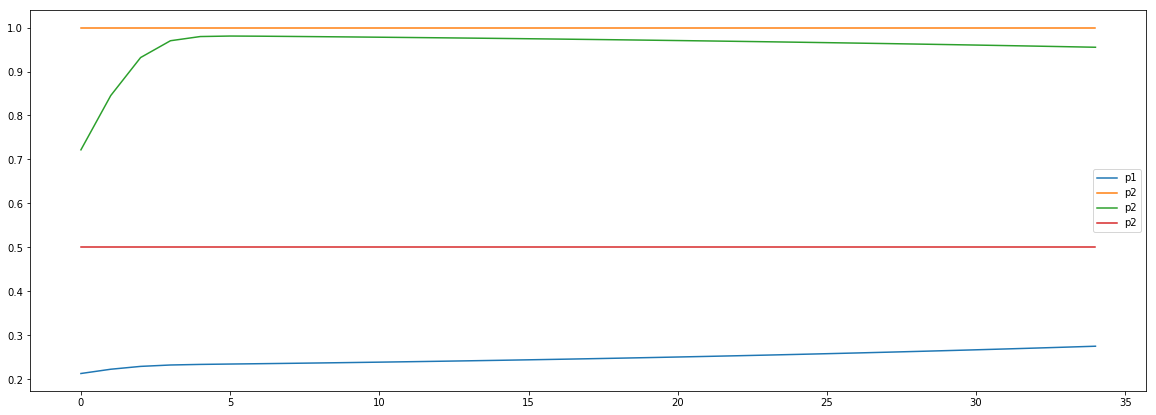

In [33]:
plot_shared_scale([
                  (hist['mean_params_sample']['1'][s:e], "p1"),
                  ((hist['mean_params_sample']['2']*0 + 1)[s:e], "p2"),
                  (hist['mean_params_sample']['2'][s:e], "p2"),
                  ((hist['mean_params_sample']['2']*0 + 0.5)[s:e], "p2"),
])

In [ ]:
model.buffers

In [ ]:
logging.info("Training process END")